Note that many of the cell output plots are not shown here (need to be re-run if desired) to reduce the notebook file size.


# Supercell Generation (Subfigure **a**)

## Generation Functions
(For testing)

- `get_pmg_cubic_supercell_dict` in `doped.utils.supercells`
- a more-efficient version of ASE's `find_optimal_cell_shape` approach is below
- `find_optimal_cell_shape` in `doped.utils.supercells` is an updated version of ASE's `find_optimal_cell_shape`, which is fixed to be rotationally-invariant (major improvement in performance, see below) and more efficient again. _Note that this has now been added to ASE with SK's MR in https://gitlab.com/ase/ase/-/merge_requests/3404_
- `find_ideal_supercell` in `doped.utils.supercells` -> current `doped` supercell optimisation function based on minimum image distances

In [5]:
from ase.build import get_deviation_from_optimal_cell_shape
import numpy as np


def old_efficient_find_optimal_cell_shape(  # confirmed same as ASE for both SC and FCC now
    cell,  # checked, and should be fairly well optimised here
    target_size,
    target_shape="sc",
    limit=None,
    verbose=False,
):
    # Set up target metric
    if target_shape in ["sc", "simple-cubic"]:
        target_metric = np.eye(3)
    elif target_shape in ["fcc", "face-centered cubic"]:
        target_metric = 0.5 * np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]], dtype=float)

    # Normalize cell metric to reduce computation time during looping
    norm = (target_size * np.linalg.det(cell) / np.linalg.det(target_metric)) ** (-1.0 / 3)
    norm_cell = norm * cell
    if verbose:
        print("normalization factor (Q): %g" % norm)

    # Approximate initial P matrix
    ideal_P = np.dot(target_metric, np.linalg.inv(norm_cell))
    if verbose:
        print("idealized transformation matrix:")
        print(ideal_P)
    starting_P = np.array(np.around(ideal_P, 0), dtype=int)
    if verbose:
        print("closest integer transformation matrix (P_0):")
        print(starting_P)

    # Prepare run.
    indices = np.indices([2 * limit + 1] * 9).reshape(9, -1).T - limit
    dP_array = indices.reshape(-1, 3, 3)
    P_array = starting_P[None, :, :] + dP_array

    # Compute determinants and filter to only those with the correct size:
    dets = np.abs(np.linalg.det(P_array))
    rounded_dets = np.around(dets, 0).astype(int)
    valid_P = P_array[rounded_dets == target_size]

    # any P in valid_P that are all negative, flip the sign of the matrix:
    valid_P[np.all(valid_P <= 0, axis=(1, 2))] *= -1

    # can't use this with the non-fixed metric, because it can get rid of aligned matrices...
    # # get unique lattices before computing metrics:
    # cell_matrices = np.einsum('ijk,kl->ijl', valid_P, norm_cell)
    # # Compute the lengths and angles for each matrix
    # lengths_angles = vectorized_lengths_and_angles_from_matrices(cell_matrices)
    # lengths_angles = [frozenset(entry) for entry in lengths_angles]
    # unique_entries_dict = {}
    # P_cell_matrix_list = [(P, cell_matrices[i]) for i, P in enumerate(valid_P)]
    # for key, P_cell in zip(lengths_angles, P_cell_matrix_list):
    #     if key not in unique_entries_dict:
    #         unique_entries_dict[key] = P_cell
    #
    # unique_P_matrix_list = list(unique_entries_dict.values())
    # return unique_P_matrix_list

    min_dist_P_list = []
    for P in valid_P:
        cell_matrix = np.dot(P, norm_cell)
        # ase_metric = fixed_ase_metric(cell_matrix)
        ase_metric = get_deviation_from_optimal_cell_shape(cell_matrix, target_shape="fcc", norm=1.0)
        min_dist_P_list.append((ase_metric, P))

    if len(min_dist_P_list) == 0:
        raise ValueError("No valid P matrices found with given settings")

    min_dist_P_list.sort(key=lambda x: x[0])  # get cell with min metric
    best_min_dist, optimal_P = min_dist_P_list[0]

    # Finalize.
    if verbose:
        # print("smallest score (|Q P h_p - h_target|_2): %f" % best_metric)
        print("optimal transformation matrix (P_opt):")
        print(optimal_P)
        print("supercell metric:")
        print(np.round(np.dot(optimal_P, cell), 4))
        print("determinant of optimal transformation matrix: %g" % np.linalg.det(optimal_P))
        print("minimum image distance: %g" % (best_min_dist / norm))
    return optimal_P, norm_cell, min_dist_P_list

Define a function to quantitatively score the performance of a supercell generation algorithm, based on the typical supercell optimisation goal (i.e. to reach a given threshold minimum image distance (e.g. 10/15 Å) for the smallest number of atoms):

In [205]:
def score_algo(struct_dict, struct, max_min_dist=50, cube=False):
    """
    For a range of minimum image distances from that of the primitive
    structure to `max_min_dist`, get the first supercell that reaches
    this minimum image distance requirement and get the number of unit
    cells required as compared to (divided by) the ideal case (i.e. 
    perfect FCC).
    """
    min_vector_norm = np.linalg.norm(struct.lattice.matrix, axis=0).min()
    min_dists = np.array([subdict["min_dist"] for subdict in struct_dict.values()])
    # use same max_min_dist for consistent comparison across algos
    required_min_dists = np.linspace(min_vector_norm, max_min_dist, 100)
    
    num_ucs_vs_ideal = []
    for required_min_dist in required_min_dists:  # get index of first min_image_dist above
        idx = np.where(min_dists > required_min_dist)[0]
        if np.any(idx):
            num_ucs_vs_ideal.append(
                int(list(struct_dict.keys())[idx[0]])/(
                    ((required_min_dist / (2 ** (1 / 6)))**3)/struct.lattice.volume))
        else:
            break
    
    if cube:
        num_ucs_vs_ideal = np.array(num_ucs_vs_ideal)**3
    
    return np.mean(num_ucs_vs_ideal)

In [206]:
def score_algo2(struct_dict, struct, max_min_dist=100, max_num_ucs=2000, cube=False, return_list=False):
    """
    Better scoring algorithm:
    For each number of unit cells, get the best min image distance up
    to that point, and compare to (divide by) the ideal case (i.e. 
    perfect FCC).
    """
    dev_from_ideal_min_dist = []
    dict_max_num_ucs = np.max([int(key) for key in struct_dict.keys()])
    
    for num_ucs in range(2, dict_max_num_ucs):  # start from 2
        if num_ucs < max_num_ucs:
            ideal_min_dist = ((num_ucs * struct.lattice.volume)**(1/3)) * (2 ** (1 / 6))
            if ideal_min_dist < max_min_dist:
                min_dists = np.array([subdict["min_dist"] for key, subdict in 
                                      struct_dict.items() if int(key) <= num_ucs])
                if np.any(min_dists):
                    dev_from_ideal_min_dist.append(np.max(min_dists[:num_ucs])/ideal_min_dist)    
    
    if cube:
        dev_from_ideal_min_dist = np.array(dev_from_ideal_min_dist)**3
    
    if return_list:
        return dev_from_ideal_min_dist
    
    return np.mean(dev_from_ideal_min_dist)

In [7]:
def ideal_num_ucs(min_dist, struct):
    # ideal is FCC, where min_dist = 1.12 * eff cubic length
    ideal_cubic_length = min_dist/(2**(1/6))
    return (ideal_cubic_length**3)/struct.lattice.volume

## LiGa5O8  (Simple Cubic Cell) 

In [32]:
from pymatgen.core.structure import Structure

liga5o8 = Structure.from_file("../../tests/data/LiGa5O8_CONTCAR")

In [39]:
from doped.utils.supercells import get_pmg_cubic_supercell_dict

liga5o8_pmg_supercell_dict = get_pmg_cubic_supercell_dict(liga5o8, uc_range=(1, 200))

100%|██████████| 199/199 [17:21<00:00,  5.24s/it]


In [40]:
from monty.serialization import dumpfn

dumpfn(liga5o8_pmg_supercell_dict, "data/liga5o8_pmg_supercell_dict.json.gz")

In [41]:
from tqdm import tqdm
from doped.utils.supercells import _get_min_image_distance_from_matrix
from monty.serialization import dumpfn

liga5o8_old_ase_sc_dict = {}
for i in tqdm(range(1, 2000)):
    optimal_P, norm_cell, min_dist_P_list = old_efficient_find_optimal_cell_shape(
        liga5o8.lattice.matrix, i, target_shape="sc", limit=2
    )  # same settings as ASE default
    liga5o8_old_ase_sc_dict[i] = {
        "P": optimal_P,
        "dev": min_dist_P_list[0][0],
        "min_dist": _get_min_image_distance_from_matrix(np.dot(optimal_P, liga5o8.lattice.matrix)),
    }
dumpfn(liga5o8_old_ase_sc_dict, "data/liga5o8_old_ase_sc_dict.json.gz")

100%|██████████| 1999/1999 [09:35<00:00,  3.47it/s]


In [42]:
from tqdm import tqdm
from doped.utils.supercells import _get_min_image_distance_from_matrix
from monty.serialization import dumpfn

liga5o8_old_ase_fcc_dict = {}
for i in tqdm(range(1, 2000)):
    optimal_P, norm_cell, min_dist_P_list = old_efficient_find_optimal_cell_shape(
        liga5o8.lattice.matrix, i, target_shape="fcc", limit=2
    )  # same settings as ASE default
    liga5o8_old_ase_fcc_dict[i] = {
        "P": optimal_P,
        "dev": min_dist_P_list[0][0],
        "min_dist": _get_min_image_distance_from_matrix(np.dot(optimal_P, liga5o8.lattice.matrix)),
    }
dumpfn(liga5o8_old_ase_fcc_dict, "data/liga5o8_old_ase_fcc_dict.json.gz")

100%|██████████| 1999/1999 [10:11<00:00,  3.27it/s]


In [43]:
from tqdm import tqdm
from doped.utils.supercells import find_optimal_cell_shape
from monty.serialization import dumpfn

liga5o8_doped_sc_dict = {}
for i in tqdm(range(1, 2000)):
    optimal_P, best_score = find_optimal_cell_shape(
        liga5o8.lattice.matrix, i, limit=2, target_shape="sc", return_score=True
    )
    liga5o8_doped_sc_dict[i] = {
        "P": optimal_P,
        "dev": best_score,
        "min_dist": _get_min_image_distance_from_matrix(np.dot(optimal_P, liga5o8.lattice.matrix)),
    }
dumpfn(liga5o8_doped_sc_dict, "data/liga5o8_doped_sc_dict.json.gz")

100%|██████████| 1999/1999 [09:18<00:00,  3.58it/s]


In [44]:
from tqdm import tqdm
from doped.utils.supercells import find_optimal_cell_shape
from monty.serialization import dumpfn

liga5o8_doped_fcc_dict = {}
for i in tqdm(range(1, 2000)):
    optimal_P, best_score = find_optimal_cell_shape(
        liga5o8.lattice.matrix, i, limit=2, target_shape="fcc", return_score=True
    )
    liga5o8_doped_fcc_dict[i] = {
        "P": optimal_P,
        "dev": best_score,
        "min_dist": _get_min_image_distance_from_matrix(np.dot(optimal_P, liga5o8.lattice.matrix)),
    }
dumpfn(liga5o8_doped_fcc_dict, "data/liga5o8_doped_fcc_dict.json.gz")

100%|██████████| 1999/1999 [09:57<00:00,  3.34it/s]


In [45]:
from tqdm import tqdm
from doped.utils.supercells import find_ideal_supercell
from monty.serialization import dumpfn

liga5o8_doped_lim2_dict = {}
for i in tqdm(range(1, 2000)):
    optimal_P, best_min_dist = find_ideal_supercell(
        liga5o8.lattice.matrix, i, limit=2, return_min_dist=True
    )
    liga5o8_doped_lim2_dict[i] = {
        "P": optimal_P,
        "min_dist": best_min_dist,
    }
dumpfn(liga5o8_doped_lim2_dict, "data/liga5o8_doped_lim2_dict.json.gz")

100%|██████████| 1999/1999 [21:11<00:00,  1.57it/s]


### Plotting

In [33]:
from monty.serialization import loadfn

liga5o8_pmg_supercell_dict = loadfn("data/liga5o8_pmg_supercell_dict.json.gz")
liga5o8_old_ase_sc_dict = loadfn("data/liga5o8_old_ase_sc_dict.json.gz")
liga5o8_old_ase_fcc_dict = loadfn("data/liga5o8_old_ase_fcc_dict.json.gz")
liga5o8_doped_sc_dict = loadfn("data/liga5o8_doped_sc_dict.json.gz")
liga5o8_doped_fcc_dict = loadfn("data/liga5o8_doped_fcc_dict.json.gz")
liga5o8_doped_lim2_dict = loadfn("data/liga5o8_doped_lim2_dict.json.gz")

In [34]:
import numpy as np
from doped.utils.supercells import _get_min_image_distance_from_matrix

liga5o8_pmg_supercell_dict_w_min_dist = {}
for k, v in liga5o8_pmg_supercell_dict.items():
    if v:
        liga5o8_pmg_supercell_dict_w_min_dist[int(k)] = {
            "P": v["P"],
            "min_dist": _get_min_image_distance_from_matrix(np.dot(v["P"], liga5o8.lattice.matrix)),
        }

In [ ]:
import numpy as np

required_min_dists = np.linspace(1, 4.9, 100)

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.style.use("../../doped/utils/doped.mplstyle")

f, ax = plt.subplots(figsize=(4, 3))
ax.set_ylabel(r"Number of Primitive Unit Cells $N_{uc}$")
ax.set_xlabel(r"Minimum Image Distance (in Unit Cell Length)")

for struct_dict, label in [
    (liga5o8_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (liga5o8_old_ase_sc_dict, "ASE (SC)"),
    (liga5o8_old_ase_fcc_dict, "ASE (FCC)"),
    (liga5o8_doped_sc_dict, "doped (SC)"),
    (liga5o8_doped_fcc_dict, "doped (FCC)"),
    (liga5o8_doped_lim2_dict, "doped (Min Image)"),
]:
    min_dists = np.array([subdict["min_dist"] for subdict in struct_dict.values()])
    num_ucs = []
    for required_min_dist in required_min_dists:  # get index of first min_image_dist above
        idx = np.where(min_dists > required_min_dist * liga5o8.lattice.a)[0][0]
        num_ucs.append(int(list(struct_dict.keys())[idx]))
    ax.plot(required_min_dists, num_ucs, "o", alpha=0.4, label=label)

ax.plot(
    (np.linspace(1, 120) ** (1 / 3)) * (2 ** (1 / 6)),
    np.linspace(1, 120),
    ls="dashed",
    c="k",
    alpha=0.4,
    zorder=0,
    label="Ideal (Pure FCC/HCP)",
)
ax.legend()
plt.show()

In [ ]:
eff_cubic_length = liga5o8.lattice.volume**(1/3)
f, ax = plt.subplots(figsize=(4, 3))
ax.set_ylabel(r"Number of Primitive Unit Cells $N_{uc}$")
ax.set_xlabel(r"Minimum Image Distance ($\AA$)")
required_min_dists = np.linspace(eff_cubic_length, np.max([
    subdict["min_dist"] for subdict in liga5o8_doped_lim2_dict.values()
]), 1000)

for struct_dict, label in [
    (liga5o8_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (liga5o8_old_ase_sc_dict, "ASE (SC)"),
    (liga5o8_old_ase_fcc_dict, "ASE (FCC)"),
    (liga5o8_doped_sc_dict, "doped (SC)"),
    (liga5o8_doped_fcc_dict, "doped (FCC)"),
    (liga5o8_doped_lim2_dict, "doped (Min Image)"),
]:
    min_dists = np.array([subdict["min_dist"] for subdict in struct_dict.values()])
    num_ucs = []
    for required_min_dist in required_min_dists:  # get index of first min_image_dist above
        idx = np.where(min_dists > required_min_dist)[0]
        if np.any(idx):
            num_ucs.append(int(list(struct_dict.keys())[idx[0]]))
    ax.plot(required_min_dists[:len(num_ucs)], num_ucs, "o", alpha=0.4, label=label)

ax.plot(
    (np.linspace(1, 2000) ** (1 / 3)) * (2 ** (1 / 6))*eff_cubic_length,
    np.linspace(1, 2000),
    ls="dashed",
    c="k",
    alpha=0.4,
    zorder=0,
    label="Ideal (Pure FCC/HCP)",
)
ax.legend()
# ax.set_ylim(0,100)
plt.show()

In [ ]:
struct = liga5o8
eff_cubic_length = struct.lattice.volume**(1/3)
f, ax = plt.subplots(figsize=(4, 3))
ax.set_ylabel(r"$N_{uc}$/$N_{uc, ideal}$")
ax.set_xlabel(r"Minimum Image Distance ($\AA$)")
required_min_dists = np.linspace(eff_cubic_length, np.max([
    subdict["min_dist"] for subdict in liga5o8_doped_lim2_dict.values()
]), 100)

for struct_dict, label in [
    (liga5o8_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (liga5o8_old_ase_sc_dict, "ASE (SC)"),
    (liga5o8_old_ase_fcc_dict, "ASE (FCC)"),
    (liga5o8_doped_sc_dict, "doped (SC)"),
    (liga5o8_doped_fcc_dict, "doped (FCC)"),
    (liga5o8_doped_lim2_dict, "doped (Min Image)"),
]:
    min_dists = np.array([subdict["min_dist"] for subdict in struct_dict.values()])
    num_ucs = []
    for required_min_dist in required_min_dists:  # get index of first min_image_dist above
        idx = np.where(min_dists > required_min_dist)[0]
        if np.any(idx):
            num_ucs.append(
                int(list(struct_dict.keys())[idx[0]])/(ideal_num_ucs(required_min_dist, struct)))
        else:
            break
    ax.plot(required_min_dists[:len(num_ucs)], num_ucs, "o", alpha=0.3, label=label)

ax.axhline(1, ls="dashed", c="k", alpha=0.4, zorder=0, label="Ideal (Pure FCC/HCP)")
ax.legend()
# ax.set_xlim(struct.lattice.a, ax.get_xlim()[1])
# ax.set_xlim(5, 16)
# ax.set_ylim(1,2)
plt.show()

In [ ]:
struct = liga5o8
eff_cubic_length = struct.lattice.volume**(1/3)
f, ax = plt.subplots(figsize=(4, 3))
ax.set_ylabel(r"$N_{uc}$/$N_{uc, ideal}$")
ax.set_xlabel(r"Minimum Image Distance ($\AA$)")
required_min_dists = np.linspace(eff_cubic_length, np.max([
    subdict["min_dist"] for subdict in liga5o8_doped_lim2_dict.values()
]), 100)

for struct_dict, label in [
    #(liga5o8_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (liga5o8_old_ase_sc_dict, "ASE (SC)"),
    (liga5o8_old_ase_fcc_dict, "ASE (FCC)"),
    # (liga5o8_doped_sc_dict, "doped (SC)"),
    # (liga5o8_doped_fcc_dict, "doped (FCC)"),
    (liga5o8_doped_lim2_dict, "doped (Min Image)"),
]:
    min_dists = np.array([subdict["min_dist"] for subdict in struct_dict.values()])
    num_ucs = []
    for required_min_dist in required_min_dists:  # get index of first min_image_dist above
        idx = np.where(min_dists > required_min_dist)[0]
        if np.any(idx):
            num_ucs.append(
                int(list(struct_dict.keys())[idx[0]])/(ideal_num_ucs(required_min_dist, struct)))
        else:
            break
    ax.plot(required_min_dists[:len(num_ucs)], num_ucs, "o", alpha=0.3, label=label)

ax.axhline(1, ls="dashed", c="k", alpha=0.4, zorder=0, label="Ideal (Pure FCC/HCP)")
ax.legend()
# ax.set_xlim(struct.lattice.a, ax.get_xlim()[1])
# ax.set_xlim(5, 16)
# ax.set_ylim(1,2)
plt.show()

In [ ]:
struct = liga5o8
eff_cubic_length = struct.lattice.volume**(1/3)
f, ax = plt.subplots(figsize=(4, 3))
ax.set_ylabel(r"$N_{uc}$/$N_{uc, ideal}$")
ax.set_xlabel(r"Minimum Image Distance ($\AA$)")
required_min_dists = np.linspace(eff_cubic_length, np.max([
    subdict["min_dist"] for subdict in liga5o8_doped_lim2_dict.values()
]), 100)

for struct_dict, label in [
    #(liga5o8_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (liga5o8_old_ase_sc_dict, "ASE (SC)"),
    (liga5o8_old_ase_fcc_dict, "ASE (FCC)"),
    # (liga5o8_doped_sc_dict, "doped (SC)"),
    # (liga5o8_doped_fcc_dict, "doped (FCC)"),
    (liga5o8_doped_lim2_dict, "doped (Min Image)"),
]:
    min_dists = np.array([subdict["min_dist"] for subdict in struct_dict.values()])
    num_ucs = []
    for required_min_dist in required_min_dists:  # get index of first min_image_dist above
        idx = np.where(min_dists > required_min_dist)[0]
        if np.any(idx):
            num_ucs.append(
                int(list(struct_dict.keys())[idx[0]])/(ideal_num_ucs(required_min_dist, struct)))
        else:
            break
    ax.plot(required_min_dists[:len(num_ucs)], num_ucs, "o", alpha=0.3, label=label)

ax.axhline(1, ls="dashed", c="k", alpha=0.4, zorder=0, label="Ideal (Pure FCC/HCP)")
ax.legend()
# ax.set_xlim(struct.lattice.a, ax.get_xlim()[1])
# ax.set_xlim(5, 16)
ax.set_ylim(1,1.4)
plt.show()

Using `limit=3` (dictates range of supercell transformation search) rather than default `limit = 2` was also tested: (but TLDR; is much slower and minimal performance improvement):

In [41]:
import numpy as np

liga5o8_doped_lim3_dict_sc_target = loadfn("data/liga5o8_lim3_min_image_sc2sc_sc_target.json.gz")
liga5o8_doped_lim3_dict_fcc_target = loadfn("data/liga5o8_lim3_min_image_sc2sc_fcc_target.json.gz")
liga5o8_doped_lim3_dict = {}
for k, v in liga5o8_doped_lim3_dict_sc_target.items():
    if v["min_dist"] > liga5o8_doped_lim3_dict_fcc_target[k]["min_dist"]:
        liga5o8_doped_lim3_dict[k] = {
            "P": v["P"],
            "min_dist": v["min_dist"],
        }
    else:
        liga5o8_doped_lim3_dict[k] = {
            "P": liga5o8_doped_lim3_dict_fcc_target[k]["P"],
            "min_dist": liga5o8_doped_lim3_dict_fcc_target[k]["min_dist"],
        }

In [85]:
for struct_dict, label in [  # closer to 1 best
    (liga5o8_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (liga5o8_old_ase_sc_dict, "ASE (SC)"),
    (liga5o8_old_ase_fcc_dict, "ASE (FCC)"),
    (liga5o8_doped_sc_dict, "doped (SC)"),
    (liga5o8_doped_fcc_dict, "doped (FCC)"),
    (liga5o8_doped_lim2_dict, "doped (Min Image)"),
    (liga5o8_doped_lim3_dict, "doped (Min Image, lim3)"),
]:
    print(f"{label}: {score_algo(struct_dict, liga5o8):.2f}")

pymatgen: 2.84
ASE (SC): 1.44
ASE (FCC): 1.47
doped (SC): 1.49
doped (FCC): 1.36
doped (Min Image): 1.26
doped (Min Image, lim3): 1.26


In [162]:
for struct_dict, label in [  # closer to 1 best
    (liga5o8_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (liga5o8_old_ase_sc_dict, "ASE (SC)"),
    (liga5o8_old_ase_fcc_dict, "ASE (FCC)"),
    (liga5o8_doped_sc_dict, "doped (SC)"),
    (liga5o8_doped_fcc_dict, "doped (FCC)"),
    (liga5o8_doped_lim2_dict, "doped (Min Image)"),
    (liga5o8_doped_lim3_dict, "doped (Min Image, lim3)"),
]:
    print(f"{label}: {score_algo2(struct_dict, liga5o8):.2f}")

pymatgen: 0.76
ASE (SC): 0.92
ASE (FCC): 0.96
doped (SC): 0.89
doped (FCC): 0.96
doped (Min Image): 0.98
doped (Min Image, lim3): 0.98


In [163]:
for struct_dict, label in [
    (liga5o8_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (liga5o8_old_ase_sc_dict, "ASE (SC)"),
    (liga5o8_old_ase_fcc_dict, "ASE (FCC)"),
    (liga5o8_doped_sc_dict, "doped (SC)"),
    (liga5o8_doped_fcc_dict, "doped (FCC)"),
    (liga5o8_doped_lim2_dict, "doped (Min Image)"),
    (liga5o8_doped_lim3_dict, "doped (Min Image, lim3)"),
]:
    print(f"{label}: {score_algo(struct_dict, liga5o8, cube=True):.2f}")

pymatgen: 66.95
ASE (SC): 3.85
ASE (FCC): 4.99
doped (SC): 3.60
doped (FCC): 2.95
doped (Min Image): 2.41
doped (Min Image, lim3): 2.41


In [164]:
for struct_dict, label in [  # closer to 1 best
    (liga5o8_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (liga5o8_old_ase_sc_dict, "ASE (SC)"),
    (liga5o8_old_ase_fcc_dict, "ASE (FCC)"),
    (liga5o8_doped_sc_dict, "doped (SC)"),
    (liga5o8_doped_fcc_dict, "doped (FCC)"),
    (liga5o8_doped_lim2_dict, "doped (Min Image)"),
    (liga5o8_doped_lim3_dict, "doped (Min Image, lim3)"),
]:
    print(f"{label}: {score_algo2(struct_dict, liga5o8, cube=True):.2f}")

pymatgen: 0.45
ASE (SC): 0.79
ASE (FCC): 0.90
doped (SC): 0.70
doped (FCC): 0.89
doped (Min Image): 0.94
doped (Min Image, lim3): 0.94


In [165]:
for struct_dict, label in [
    (liga5o8_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (liga5o8_old_ase_sc_dict, "ASE (SC)"),
    (liga5o8_old_ase_fcc_dict, "ASE (FCC)"),
    (liga5o8_doped_sc_dict, "doped (SC)"),
    (liga5o8_doped_fcc_dict, "doped (FCC)"),
    (liga5o8_doped_lim2_dict, "doped (Min Image)"),
    (liga5o8_doped_lim3_dict, "doped (Min Image, lim3)"),
]:
    print(f"{label}: {score_algo(struct_dict, liga5o8, 100, cube=True):.2f}")

pymatgen: 80.87
ASE (SC): 3.19
ASE (FCC): 3.41
doped (SC): 3.38
doped (FCC): 2.22
doped (Min Image): 1.88
doped (Min Image, lim3): 1.87


In [166]:
for struct_dict, label in [
    (liga5o8_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (liga5o8_old_ase_sc_dict, "ASE (SC)"),
    (liga5o8_old_ase_fcc_dict, "ASE (FCC)"),
    (liga5o8_doped_sc_dict, "doped (SC)"),
    (liga5o8_doped_fcc_dict, "doped (FCC)"),
    (liga5o8_doped_lim2_dict, "doped (Min Image)"),
    (liga5o8_doped_lim3_dict, "doped (Min Image, lim3)"),
]:
    print(f"{label}: {score_algo2(struct_dict, liga5o8, max_min_dist=20):.2f}")

pymatgen: 0.68
ASE (SC): 0.86
ASE (FCC): 0.82
doped (SC): 0.91
doped (FCC): 0.89
doped (Min Image): 0.91
doped (Min Image, lim3): 0.91


In [167]:
for struct_dict, label in [
    (liga5o8_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (liga5o8_old_ase_sc_dict, "ASE (SC)"),
    (liga5o8_old_ase_fcc_dict, "ASE (FCC)"),
    (liga5o8_doped_sc_dict, "doped (SC)"),
    (liga5o8_doped_fcc_dict, "doped (FCC)"),
    (liga5o8_doped_lim2_dict, "doped (Min Image)"),
    (liga5o8_doped_lim3_dict, "doped (Min Image, lim3)"),
]:
    print(f"{label}: {score_algo(struct_dict, liga5o8, 20, cube=True):.2f}")

pymatgen: 147.30
ASE (SC): 8.44
ASE (FCC): 13.50
doped (SC): 4.74
doped (FCC): 4.98
doped (Min Image): 4.53
doped (Min Image, lim3): 4.53


In [168]:
for struct_dict, label in [
    (liga5o8_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (liga5o8_old_ase_sc_dict, "ASE (SC)"),
    (liga5o8_old_ase_fcc_dict, "ASE (FCC)"),
    (liga5o8_doped_sc_dict, "doped (SC)"),
    (liga5o8_doped_fcc_dict, "doped (FCC)"),
    (liga5o8_doped_lim2_dict, "doped (Min Image)"),
    (liga5o8_doped_lim3_dict, "doped (Min Image, lim3)"),
]:
    print(f"{label}: {score_algo2(struct_dict, liga5o8, max_min_dist=20, cube=True):.2f}")

pymatgen: 0.37
ASE (SC): 0.65
ASE (FCC): 0.58
doped (SC): 0.75
doped (FCC): 0.73
doped (Min Image): 0.75
doped (Min Image, lim3): 0.75


In [169]:
for struct_dict, label in [
    (liga5o8_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (liga5o8_old_ase_sc_dict, "ASE (SC)"),
    (liga5o8_old_ase_fcc_dict, "ASE (FCC)"),
    (liga5o8_doped_sc_dict, "doped (SC)"),
    (liga5o8_doped_fcc_dict, "doped (FCC)"),
    (liga5o8_doped_lim2_dict, "doped (Min Image)"),
    (liga5o8_doped_lim3_dict, "doped (Min Image, lim3)"),
]:
    print(f"{label}: {score_algo(struct_dict, liga5o8, 15, cube=True):.2f}")

pymatgen: 222.54
ASE (SC): 11.60
ASE (FCC): 20.27
doped (SC): 5.64
doped (FCC): 6.05
doped (Min Image): 5.64
doped (Min Image, lim3): 5.64


`limit = 3` only marginally improved as expected.

## Sb2Si2Te6 (R-3, Trigonal) 

In [68]:
from pymatgen.core.structure import Structure

sb2si2te6_super = Structure.from_file("../../tests/data/Sb2Si2Te6_POSCAR")
sb2si2te6 = sb2si2te6_super.get_primitive_structure()

In [47]:
from doped.utils.supercells import get_pmg_cubic_supercell_dict
from monty.serialization import dumpfn

sb2si2te6_pmg_supercell_dict = get_pmg_cubic_supercell_dict(sb2si2te6, uc_range=(1, 200))
dumpfn(sb2si2te6_pmg_supercell_dict, "data/sb2si2te6_pmg_supercell_dict.json.gz")

100%|██████████| 199/199 [02:19<00:00,  1.42it/s]


In [48]:
from tqdm import tqdm
from doped.utils.supercells import _get_min_image_distance_from_matrix
from monty.serialization import dumpfn

sb2si2te6_old_ase_sc_dict = {}
for i in tqdm(range(1, 2000)):
    optimal_P, norm_cell, min_dist_P_list = old_efficient_find_optimal_cell_shape(
        sb2si2te6.lattice.matrix, i, target_shape="sc", limit=2
    )  # same settings as ASE default
    sb2si2te6_old_ase_sc_dict[i] = {
        "P": optimal_P,
        "dev": min_dist_P_list[0][0],
        "min_dist": _get_min_image_distance_from_matrix(np.dot(optimal_P, sb2si2te6.lattice.matrix)),
    }
dumpfn(sb2si2te6_old_ase_sc_dict, "data/sb2si2te6_old_ase_sc_dict.json.gz")

100%|██████████| 1999/1999 [10:12<00:00,  3.26it/s]


In [49]:
from tqdm import tqdm
from doped.utils.supercells import _get_min_image_distance_from_matrix
from monty.serialization import dumpfn

sb2si2te6_old_ase_fcc_dict = {}
for i in tqdm(range(1, 2000)):
    optimal_P, norm_cell, min_dist_P_list = old_efficient_find_optimal_cell_shape(
        sb2si2te6.lattice.matrix, i, target_shape="fcc", limit=2
    )  # same settings as ASE default
    sb2si2te6_old_ase_fcc_dict[i] = {
        "P": optimal_P,
        "dev": min_dist_P_list[0][0],
        "min_dist": _get_min_image_distance_from_matrix(np.dot(optimal_P, sb2si2te6.lattice.matrix)),
    }
dumpfn(sb2si2te6_old_ase_fcc_dict, "data/sb2si2te6_old_ase_fcc_dict.json.gz")

100%|██████████| 1999/1999 [09:28<00:00,  3.52it/s]


In [50]:
from tqdm import tqdm
from doped.utils.supercells import find_optimal_cell_shape
from monty.serialization import dumpfn

sb2si2te6_doped_sc_dict = {}
for i in tqdm(range(1, 2000)):
    optimal_P, best_score = find_optimal_cell_shape(
        sb2si2te6.lattice.matrix, i, limit=2, target_shape="sc", return_score=True
    )
    sb2si2te6_doped_sc_dict[i] = {
        "P": optimal_P,
        "dev": best_score,
        "min_dist": _get_min_image_distance_from_matrix(np.dot(optimal_P, sb2si2te6.lattice.matrix)),
    }
dumpfn(sb2si2te6_doped_sc_dict, "data/sb2si2te6_doped_sc_dict.json.gz")

100%|██████████| 1999/1999 [10:41<00:00,  3.11it/s]


In [51]:
from tqdm import tqdm
from doped.utils.supercells import find_optimal_cell_shape
from monty.serialization import dumpfn

sb2si2te6_doped_fcc_dict = {}
for i in tqdm(range(1, 2000)):
    optimal_P, best_score = find_optimal_cell_shape(
        sb2si2te6.lattice.matrix, i, limit=2, target_shape="fcc", return_score=True
    )
    sb2si2te6_doped_fcc_dict[i] = {
        "P": optimal_P,
        "dev": best_score,
        "min_dist": _get_min_image_distance_from_matrix(np.dot(optimal_P, sb2si2te6.lattice.matrix)),
    }
dumpfn(sb2si2te6_doped_fcc_dict, "data/sb2si2te6_doped_fcc_dict.json.gz")

100%|██████████| 1999/1999 [10:05<00:00,  3.30it/s]


In [52]:
from tqdm import tqdm
from doped.utils.supercells import find_ideal_supercell
from monty.serialization import dumpfn

sb2si2te6_doped_lim2_dict = {}
for i in tqdm(range(1, 2000)):
    optimal_P, best_min_dist = find_ideal_supercell(
        sb2si2te6.lattice.matrix, i, limit=2, return_min_dist=True
    )
    sb2si2te6_doped_lim2_dict[i] = {
        "P": optimal_P,
        "min_dist": best_min_dist,
    }
dumpfn(sb2si2te6_doped_lim2_dict, "data/sb2si2te6_doped_lim2_dict.json.gz")

100%|██████████| 1999/1999 [29:05<00:00,  1.15it/s]


In [ ]:
from tqdm import tqdm
from doped.utils.supercells import find_ideal_supercell
from monty.serialization import dumpfn

sb2si2te6_doped_lim3_dict = {}
for i in tqdm(range(1, 2000)):
    optimal_P, best_min_dist = find_ideal_supercell(
        sb2si2te6.lattice.matrix, i, limit=3, return_min_dist=True
    )
    sb2si2te6_doped_lim3_dict[i] = {
        "P": optimal_P,
        "min_dist": best_min_dist,
    }
dumpfn(sb2si2te6_doped_lim3_dict, "data/sb2si2te6_doped_lim3_dict.json.gz")

In [61]:
dumpfn(sb2si2te6_doped_lim3_dict, "data/sb2si2te6_doped_lim3_dict.json.gz")

### Plotting

In [69]:
from monty.serialization import loadfn

sb2si2te6_pmg_supercell_dict = loadfn("data/sb2si2te6_pmg_supercell_dict.json.gz")
sb2si2te6_old_ase_sc_dict = loadfn("data/sb2si2te6_old_ase_sc_dict.json.gz")
sb2si2te6_old_ase_fcc_dict = loadfn("data/sb2si2te6_old_ase_fcc_dict.json.gz")
sb2si2te6_doped_sc_dict = loadfn("data/sb2si2te6_doped_sc_dict.json.gz")
sb2si2te6_doped_fcc_dict = loadfn("data/sb2si2te6_doped_fcc_dict.json.gz")
sb2si2te6_doped_lim2_dict = loadfn("data/sb2si2te6_doped_lim2_dict.json.gz")

In [70]:
import numpy as np
from doped.utils.supercells import _get_min_image_distance_from_matrix

sb2si2te6_pmg_supercell_dict_w_min_dist = {}
for k, v in sb2si2te6_pmg_supercell_dict.items():
    if v:
        sb2si2te6_pmg_supercell_dict_w_min_dist[int(k)] = {
            "P": v["P"],
            "min_dist": _get_min_image_distance_from_matrix(np.dot(v["P"], sb2si2te6.lattice.matrix)),
        }

In [ ]:
required_min_dists = np.linspace(1, 4.9, 100)
eff_cubic_length = sb2si2te6.lattice.volume**(1/3)

f, ax = plt.subplots(figsize=(4, 3))
ax.set_ylabel(r"Number of Primitive Unit Cells $N_{uc}$")
ax.set_xlabel(r"Minimum Image Distance (in Unit Cell Length)")

for struct_dict, label in [
    (sb2si2te6_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (sb2si2te6_old_ase_sc_dict, "ASE (SC)"),
    (sb2si2te6_old_ase_fcc_dict, "ASE (FCC)"),
    (sb2si2te6_doped_sc_dict, "doped (SC)"),
    (sb2si2te6_doped_fcc_dict, "doped (FCC)"),
    (sb2si2te6_doped_lim2_dict, "doped (Min Image)"),
]:
    min_dists = np.array([subdict["min_dist"] for subdict in struct_dict.values()])
    num_ucs = []
    for required_min_dist in required_min_dists:  # get index of first min_image_dist above
        idx = np.where(min_dists > required_min_dist * eff_cubic_length)[0][0]
        num_ucs.append(int(list(struct_dict.keys())[idx]))
    ax.plot(required_min_dists, num_ucs, "o", alpha=0.4, label=label)

ax.plot(
    (np.linspace(1, 120) ** (1 / 3)) * (2 ** (1 / 6)),
    np.linspace(1, 120),
    ls="dashed",
    c="k",
    alpha=0.4,
    zorder=0,
    label="Ideal (Pure FCC/HCP)",
)
ax.legend()
plt.show()

In [ ]:
eff_cubic_length = sb2si2te6.lattice.volume**(1/3)
f, ax = plt.subplots(figsize=(4, 3))
ax.set_ylabel(r"Number of Primitive Unit Cells $N_{uc}$")
ax.set_xlabel(r"Minimum Image Distance ($\AA$)")
required_min_dists = np.linspace(eff_cubic_length, np.max([
    subdict["min_dist"] for subdict in sb2si2te6_doped_lim2_dict.values()
]), 1000)

for struct_dict, label in [
    (sb2si2te6_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (sb2si2te6_old_ase_sc_dict, "ASE (SC)"),
    (sb2si2te6_old_ase_fcc_dict, "ASE (FCC)"),
    (sb2si2te6_doped_sc_dict, "doped (SC)"),
    (sb2si2te6_doped_fcc_dict, "doped (FCC)"),
    (sb2si2te6_doped_lim2_dict, "doped (Min Image)"),
]:
    min_dists = np.array([subdict["min_dist"] for subdict in struct_dict.values()])
    num_ucs = []
    for required_min_dist in required_min_dists:  # get index of first min_image_dist above
        idx = np.where(min_dists > required_min_dist)[0]
        if np.any(idx):
            num_ucs.append(int(list(struct_dict.keys())[idx[0]]))
    ax.plot(required_min_dists[:len(num_ucs)], num_ucs, "o", alpha=0.4, label=label)

ax.plot(
    (np.linspace(1, 2000) ** (1 / 3)) * (2 ** (1 / 6))*eff_cubic_length,
    np.linspace(1, 2000),
    ls="dashed",
    c="k",
    alpha=0.4,
    zorder=0,
    label="Ideal (Pure FCC/HCP)",
)
ax.legend()
# ax.set_ylim(0,100)
plt.show()

In [ ]:
struct = sb2si2te6
eff_cubic_length = struct.lattice.volume**(1/3)
f, ax = plt.subplots(figsize=(4, 3))
ax.set_ylabel(r"$N_{uc}$/$N_{uc, ideal}$")
ax.set_xlabel(r"Minimum Image Distance ($\AA$)")
required_min_dists = np.linspace(eff_cubic_length, np.max([
    subdict["min_dist"] for subdict in sb2si2te6_doped_lim2_dict.values()
]), 100)

for struct_dict, label in [
    (sb2si2te6_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (sb2si2te6_old_ase_sc_dict, "ASE (SC)"),
    (sb2si2te6_old_ase_fcc_dict, "ASE (FCC)"),
    (sb2si2te6_doped_sc_dict, "doped (SC)"),
    (sb2si2te6_doped_fcc_dict, "doped (FCC)"),
    (sb2si2te6_doped_lim2_dict, "doped (Min Image)"),
]:
    min_dists = np.array([subdict["min_dist"] for subdict in struct_dict.values()])
    num_ucs = []
    for required_min_dist in required_min_dists:  # get index of first min_image_dist above
        idx = np.where(min_dists > required_min_dist)[0]
        if np.any(idx):
            num_ucs.append(
                int(list(struct_dict.keys())[idx[0]])/(ideal_num_ucs(required_min_dist, struct)))
        else:
            break
    ax.plot(required_min_dists[:len(num_ucs)], num_ucs, "o", alpha=0.3, label=label)

ax.axhline(1, ls="dashed", c="k", alpha=0.4, zorder=0, label="Ideal (Pure FCC/HCP)")
ax.legend()
# ax.set_xlim(struct.lattice.a, ax.get_xlim()[1])
# ax.set_xlim(5, 16)
# ax.set_ylim(1,2)
plt.show()

In [ ]:
struct = sb2si2te6
eff_cubic_length = struct.lattice.volume**(1/3)
f, ax = plt.subplots(figsize=(4, 3))
ax.set_ylabel(r"$N_{uc}$/$N_{uc, ideal}$")
ax.set_xlabel(r"Minimum Image Distance ($\AA$)")
required_min_dists = np.linspace(eff_cubic_length, np.max([
    subdict["min_dist"] for subdict in sb2si2te6_doped_lim2_dict.values()
]), 100)

for struct_dict, label in [
    #(liga5o8_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (sb2si2te6_old_ase_sc_dict, "ASE (SC)"),
    (sb2si2te6_old_ase_fcc_dict, "ASE (FCC)"),
    # (sb2si2te6_doped_sc_dict, "doped (SC)"),
    # (sb2si2te6_doped_fcc_dict, "doped (FCC)"),
    (sb2si2te6_doped_lim2_dict, "doped (Min Image)"),
]:
    min_dists = np.array([subdict["min_dist"] for subdict in struct_dict.values()])
    num_ucs = []
    for required_min_dist in required_min_dists:  # get index of first min_image_dist above
        idx = np.where(min_dists > required_min_dist)[0]
        if np.any(idx):
            num_ucs.append(
                int(list(struct_dict.keys())[idx[0]])/(ideal_num_ucs(required_min_dist, struct)))
        else:
            break
    ax.plot(required_min_dists[:len(num_ucs)], num_ucs, "o", alpha=0.3, label=label)

ax.axhline(1, ls="dashed", c="k", alpha=0.4, zorder=0, label="Ideal (Pure FCC/HCP)")
ax.legend()
# ax.set_xlim(struct.lattice.a, ax.get_xlim()[1])
# ax.set_xlim(5, 16)
# ax.set_ylim(1,2)
plt.show()

In [ ]:
struct = sb2si2te6
eff_cubic_length = struct.lattice.volume**(1/3)
f, ax = plt.subplots(figsize=(4, 3))
ax.set_ylabel(r"$N_{uc}$/$N_{uc, ideal}$")
ax.set_xlabel(r"Minimum Image Distance ($\AA$)")
required_min_dists = np.linspace(eff_cubic_length, 20, 100)

for struct_dict, label in [
    #(liga5o8_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (sb2si2te6_old_ase_sc_dict, "ASE (SC)"),
    (sb2si2te6_old_ase_fcc_dict, "ASE (FCC)"),
    # (sb2si2te6_doped_sc_dict, "doped (SC)"),
    # (sb2si2te6_doped_fcc_dict, "doped (FCC)"),
    (sb2si2te6_doped_lim2_dict, "doped (Min Image)"),
]:
    min_dists = np.array([subdict["min_dist"] for subdict in struct_dict.values()])
    num_ucs = []
    for required_min_dist in required_min_dists:  # get index of first min_image_dist above
        idx = np.where(min_dists > required_min_dist)[0]
        if np.any(idx):
            num_ucs.append(
                int(list(struct_dict.keys())[idx[0]])/(ideal_num_ucs(required_min_dist, struct)))
        else:
            break
    ax.plot(required_min_dists[:len(num_ucs)], num_ucs, "o", alpha=0.3, label=label)

ax.axhline(1, ls="dashed", c="k", alpha=0.4, zorder=0, label="Ideal (Pure FCC/HCP)")
ax.legend()
# ax.set_xlim(struct.lattice.a, ax.get_xlim()[1])
# ax.set_xlim(5, 16)
# ax.set_ylim(1,2)
plt.show()

In [78]:
for struct_dict, label in [
    (sb2si2te6_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (sb2si2te6_old_ase_sc_dict, "ASE (SC)"),
    (sb2si2te6_old_ase_fcc_dict, "ASE (FCC)"),
    (sb2si2te6_doped_sc_dict, "doped (SC)"),
    (sb2si2te6_doped_fcc_dict, "doped (FCC)"),
    (sb2si2te6_doped_lim2_dict, "doped (Min Image)"),
]:
    print(f"{label}: {score_algo(struct_dict, sb2si2te6):.2f}")

pymatgen: 3.82
ASE (SC): 1.53
ASE (FCC): 1.47
doped (SC): 1.66
doped (FCC): 1.69
doped (Min Image): 1.29


In [92]:
for struct_dict, label in [
    (sb2si2te6_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (sb2si2te6_old_ase_sc_dict, "ASE (SC)"),
    (sb2si2te6_old_ase_fcc_dict, "ASE (FCC)"),
    (sb2si2te6_doped_sc_dict, "doped (SC)"),
    (sb2si2te6_doped_fcc_dict, "doped (FCC)"),
    (sb2si2te6_doped_lim2_dict, "doped (Min Image)"),
]:
    print(f"{label}: {score_algo2(struct_dict, sb2si2te6):.2f}")

pymatgen: 1.32
ASE (SC): 0.94
ASE (FCC): 0.96
doped (SC): 0.88
doped (FCC): 0.94
doped (Min Image): 0.98


In [81]:
for struct_dict, label in [
    (sb2si2te6_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (sb2si2te6_old_ase_sc_dict, "ASE (SC)"),
    (sb2si2te6_old_ase_fcc_dict, "ASE (FCC)"),
    (sb2si2te6_doped_sc_dict, "doped (SC)"),
    (sb2si2te6_doped_fcc_dict, "doped (FCC)"),
    (sb2si2te6_doped_lim2_dict, "doped (Min Image)"),
]:
    print(f"{label}: {score_algo(struct_dict, sb2si2te6, cube=True):.2f}")

pymatgen: 109.78
ASE (SC): 5.07
ASE (FCC): 4.55
doped (SC): 5.59
doped (FCC): 6.57
doped (Min Image): 2.97


In [141]:
for struct_dict, label in [
    (sb2si2te6_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (sb2si2te6_old_ase_sc_dict, "ASE (SC)"),
    (sb2si2te6_old_ase_fcc_dict, "ASE (FCC)"),
    (sb2si2te6_doped_sc_dict, "doped (SC)"),
    (sb2si2te6_doped_fcc_dict, "doped (FCC)"),
    (sb2si2te6_doped_lim2_dict, "doped (Min Image)"),
]:
    print(f"{label}: {score_algo(struct_dict, sb2si2te6, 100, cube=True):.2f}")

pymatgen: 141.95
ASE (SC): 3.60
ASE (FCC): 3.17
doped (SC): 4.58
doped (FCC): 4.32
doped (Min Image): 2.38


In [142]:
for struct_dict, label in [
    (sb2si2te6_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (sb2si2te6_old_ase_sc_dict, "ASE (SC)"),
    (sb2si2te6_old_ase_fcc_dict, "ASE (FCC)"),
    (sb2si2te6_doped_sc_dict, "doped (SC)"),
    (sb2si2te6_doped_fcc_dict, "doped (FCC)"),
    (sb2si2te6_doped_lim2_dict, "doped (Min Image)"),
]:
    print(f"{label}: {score_algo(struct_dict, sb2si2te6, 20, cube=True):.2f}")

pymatgen: 197.47
ASE (SC): 11.94
ASE (FCC): 10.74
doped (SC): 10.81
doped (FCC): 14.62
doped (Min Image): 7.35


In [94]:
for struct_dict, label in [
    (sb2si2te6_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (sb2si2te6_old_ase_sc_dict, "ASE (SC)"),
    (sb2si2te6_old_ase_fcc_dict, "ASE (FCC)"),
    (sb2si2te6_doped_sc_dict, "doped (SC)"),
    (sb2si2te6_doped_fcc_dict, "doped (FCC)"),
    (sb2si2te6_doped_lim2_dict, "doped (Min Image)"),
]:
    print(f"{label}: {score_algo2(struct_dict, sb2si2te6, max_min_dist=20, cube=True):.2f}")

pymatgen: 4.98
ASE (SC): 0.54
ASE (FCC): 0.59
doped (SC): 0.57
doped (FCC): 0.46
doped (Min Image): 0.73


In [143]:
for struct_dict, label in [
    (sb2si2te6_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (sb2si2te6_old_ase_sc_dict, "ASE (SC)"),
    (sb2si2te6_old_ase_fcc_dict, "ASE (FCC)"),
    (sb2si2te6_doped_sc_dict, "doped (SC)"),
    (sb2si2te6_doped_fcc_dict, "doped (FCC)"),
    (sb2si2te6_doped_lim2_dict, "doped (Min Image)"),
]:
    print(f"{label}: {score_algo(struct_dict, sb2si2te6, 15, cube=True):.2f}")

pymatgen: 252.50
ASE (SC): 14.92
ASE (FCC): 13.88
doped (SC): 13.72
doped (FCC): 17.67
doped (Min Image): 9.76


In [95]:
for struct_dict, label in [
    (sb2si2te6_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (sb2si2te6_old_ase_sc_dict, "ASE (SC)"),
    (sb2si2te6_old_ase_fcc_dict, "ASE (FCC)"),
    (sb2si2te6_doped_sc_dict, "doped (SC)"),
    (sb2si2te6_doped_fcc_dict, "doped (FCC)"),
    (sb2si2te6_doped_lim2_dict, "doped (Min Image)"),
]:
    print(f"{label}: {score_algo2(struct_dict, sb2si2te6, max_min_dist=15, cube=True):.2f}")

pymatgen: 1.08
ASE (SC): 0.56
ASE (FCC): 0.52
doped (SC): 0.58
doped (FCC): 0.52
doped (Min Image): 0.64


## Na2FePO4F (Pbcn, Orthorhombic) 

In [125]:
from pymatgen.core.structure import Structure

na2fepo4f = Structure.from_file("data/Na2FePO4F_POSCAR")
na2fepo4f = na2fepo4f.get_primitive_structure()

In [4]:
from doped.utils.supercells import get_pmg_cubic_supercell_dict
from monty.serialization import dumpfn

na2fepo4f_pmg_supercell_dict = get_pmg_cubic_supercell_dict(na2fepo4f, uc_range=(1, 200))
dumpfn(na2fepo4f_pmg_supercell_dict, "data/na2fepo4f_pmg_supercell_dict.json.gz")

100%|██████████| 199/199 [27:03<00:00,  8.16s/it]


In [5]:
from tqdm import tqdm
from doped.utils.supercells import _get_min_image_distance_from_matrix
from monty.serialization import dumpfn

na2fepo4f_old_ase_sc_dict = {}
for i in tqdm(range(1, 2000)):
    optimal_P, norm_cell, min_dist_P_list = old_efficient_find_optimal_cell_shape(
        na2fepo4f.lattice.matrix, i, target_shape="sc", limit=2
    )  # same settings as ASE default
    na2fepo4f_old_ase_sc_dict[i] = {
        "P": optimal_P,
        "dev": min_dist_P_list[0][0],
        "min_dist": _get_min_image_distance_from_matrix(np.dot(optimal_P, na2fepo4f.lattice.matrix)),
    }
dumpfn(na2fepo4f_old_ase_sc_dict, "data/na2fepo4f_old_ase_sc_dict.json.gz")

100%|██████████| 1999/1999 [09:33<00:00,  3.49it/s]


In [6]:
from tqdm import tqdm
from doped.utils.supercells import _get_min_image_distance_from_matrix
from monty.serialization import dumpfn

na2fepo4f_old_ase_fcc_dict = {}
for i in tqdm(range(1, 2000)):
    optimal_P, norm_cell, min_dist_P_list = old_efficient_find_optimal_cell_shape(
        na2fepo4f.lattice.matrix, i, target_shape="fcc", limit=2
    )  # same settings as ASE default
    na2fepo4f_old_ase_fcc_dict[i] = {
        "P": optimal_P,
        "dev": min_dist_P_list[0][0],
        "min_dist": _get_min_image_distance_from_matrix(np.dot(optimal_P, na2fepo4f.lattice.matrix)),
    }
dumpfn(na2fepo4f_old_ase_fcc_dict, "data/na2fepo4f_old_ase_fcc_dict.json.gz")

100%|██████████| 1999/1999 [10:18<00:00,  3.23it/s]


In [7]:
from tqdm import tqdm
from doped.utils.supercells import find_optimal_cell_shape
from monty.serialization import dumpfn

na2fepo4f_doped_sc_dict = {}
for i in tqdm(range(1, 2000)):
    optimal_P, best_score = find_optimal_cell_shape(
        na2fepo4f.lattice.matrix, i, limit=2, target_shape="sc", return_score=True
    )
    na2fepo4f_doped_sc_dict[i] = {
        "P": optimal_P,
        "dev": best_score,
        "min_dist": _get_min_image_distance_from_matrix(np.dot(optimal_P, na2fepo4f.lattice.matrix)),
    }
dumpfn(na2fepo4f_doped_sc_dict, "data/na2fepo4f_doped_sc_dict.json.gz")

100%|██████████| 1999/1999 [10:23<00:00,  3.20it/s]


In [8]:
from tqdm import tqdm
from doped.utils.supercells import find_optimal_cell_shape
from monty.serialization import dumpfn

na2fepo4f_doped_fcc_dict = {}
for i in tqdm(range(1, 2000)):
    optimal_P, best_score = find_optimal_cell_shape(
        na2fepo4f.lattice.matrix, i, limit=2, target_shape="fcc", return_score=True
    )
    na2fepo4f_doped_fcc_dict[i] = {
        "P": optimal_P,
        "dev": best_score,
        "min_dist": _get_min_image_distance_from_matrix(np.dot(optimal_P, na2fepo4f.lattice.matrix)),
    }
dumpfn(na2fepo4f_doped_fcc_dict, "data/na2fepo4f_doped_fcc_dict.json.gz")

100%|██████████| 1999/1999 [11:29<00:00,  2.90it/s]


In [9]:
from tqdm import tqdm
from doped.utils.supercells import find_ideal_supercell
from monty.serialization import dumpfn

na2fepo4f_doped_lim2_dict = {}
for i in tqdm(range(1, 2000)):
    optimal_P, best_min_dist = find_ideal_supercell(
        na2fepo4f.lattice.matrix, i, limit=2, return_min_dist=True
    )
    na2fepo4f_doped_lim2_dict[i] = {
        "P": optimal_P,
        "min_dist": best_min_dist,
    }
dumpfn(na2fepo4f_doped_lim2_dict, "data/na2fepo4f_doped_lim2_dict.json.gz")

100%|██████████| 1999/1999 [29:24<00:00,  1.13it/s]


In [0]:
from tqdm import tqdm
from doped.utils.supercells import find_ideal_supercell
from monty.serialization import dumpfn

na2fepo4f_doped_lim3_dict = {}
for i in tqdm(range(1, 2000)):
    optimal_P, best_min_dist = find_ideal_supercell(
        na2fepo4f.lattice.matrix, i, limit=3, return_min_dist=True
    )
    na2fepo4f_doped_lim3_dict[i] = {
        "P": optimal_P,
        "min_dist": best_min_dist,
    }
dumpfn(na2fepo4f_doped_lim3_dict, "data/na2fepo4f_doped_lim3_dict.json.gz")

### Plotting

In [100]:
from monty.serialization import loadfn

na2fepo4f_pmg_supercell_dict = loadfn("data/na2fepo4f_pmg_supercell_dict.json.gz")
na2fepo4f_old_ase_sc_dict = loadfn("data/na2fepo4f_old_ase_sc_dict.json.gz")
na2fepo4f_old_ase_fcc_dict = loadfn("data/na2fepo4f_old_ase_fcc_dict.json.gz")
na2fepo4f_doped_sc_dict = loadfn("data/na2fepo4f_doped_sc_dict.json.gz")
na2fepo4f_doped_fcc_dict = loadfn("data/na2fepo4f_doped_fcc_dict.json.gz")
na2fepo4f_doped_lim2_dict = loadfn("data/na2fepo4f_doped_lim2_dict.json.gz")

In [101]:
import numpy as np
from doped.utils.supercells import _get_min_image_distance_from_matrix

na2fepo4f_pmg_supercell_dict_w_min_dist = {}
for k, v in na2fepo4f_pmg_supercell_dict.items():
    if v:
        na2fepo4f_pmg_supercell_dict_w_min_dist[int(k)] = {
            "P": v["P"],
            "min_dist": _get_min_image_distance_from_matrix(np.dot(v["P"], na2fepo4f.lattice.matrix)),
        }

In [ ]:
required_min_dists = np.linspace(1, 4.9, 100)
eff_cubic_length = na2fepo4f.lattice.volume**(1/3)

f, ax = plt.subplots(figsize=(4, 3))
ax.set_ylabel(r"Number of Primitive Unit Cells $N_{uc}$")
ax.set_xlabel(r"Minimum Image Distance (in Unit Cell Length)")

for struct_dict, label in [
    (na2fepo4f_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (na2fepo4f_old_ase_sc_dict, "ASE (SC)"),
    (na2fepo4f_old_ase_fcc_dict, "ASE (FCC)"),
    (na2fepo4f_doped_sc_dict, "doped (SC)"),
    (na2fepo4f_doped_fcc_dict, "doped (FCC)"),
    (na2fepo4f_doped_lim2_dict, "doped (Min Image)"),
]:
    min_dists = np.array([subdict["min_dist"] for subdict in struct_dict.values()])
    num_ucs = []
    for required_min_dist in required_min_dists:  # get index of first min_image_dist above
        idx = np.where(min_dists > required_min_dist * eff_cubic_length)[0][0]
        num_ucs.append(int(list(struct_dict.keys())[idx]))
    ax.plot(required_min_dists, num_ucs, "o", alpha=0.4, label=label)

ax.plot(
    (np.linspace(1, 120) ** (1 / 3)) * (2 ** (1 / 6)),
    np.linspace(1, 120),
    ls="dashed",
    c="k",
    alpha=0.4,
    zorder=0,
    label="Ideal (Pure FCC/HCP)",
)
ax.legend()
plt.show()

In [ ]:
eff_cubic_length = na2fepo4f.lattice.volume**(1/3)
f, ax = plt.subplots(figsize=(4, 3))
ax.set_ylabel(r"Number of Primitive Unit Cells $N_{uc}$")
ax.set_xlabel(r"Minimum Image Distance ($\AA$)")
required_min_dists = np.linspace(eff_cubic_length, np.max([
    subdict["min_dist"] for subdict in na2fepo4f_doped_lim2_dict.values()
]), 1000)

for struct_dict, label in [
    (na2fepo4f_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (na2fepo4f_old_ase_sc_dict, "ASE (SC)"),
    (na2fepo4f_old_ase_fcc_dict, "ASE (FCC)"),
    (na2fepo4f_doped_sc_dict, "doped (SC)"),
    (na2fepo4f_doped_fcc_dict, "doped (FCC)"),
    (na2fepo4f_doped_lim2_dict, "doped (Min Image)"),
]:
    min_dists = np.array([subdict["min_dist"] for subdict in struct_dict.values()])
    num_ucs = []
    for required_min_dist in required_min_dists:  # get index of first min_image_dist above
        idx = np.where(min_dists > required_min_dist)[0]
        if np.any(idx):
            num_ucs.append(int(list(struct_dict.keys())[idx[0]]))
    ax.plot(required_min_dists[:len(num_ucs)], num_ucs, "o", alpha=0.4, label=label)

ax.plot(
    (np.linspace(1, 2000) ** (1 / 3)) * (2 ** (1 / 6))*eff_cubic_length,
    np.linspace(1, 2000),
    ls="dashed",
    c="k",
    alpha=0.4,
    zorder=0,
    label="Ideal (Pure FCC/HCP)",
)
ax.legend()
# ax.set_ylim(0,100)
plt.show()

In [ ]:
struct = na2fepo4f
eff_cubic_length = struct.lattice.volume**(1/3)
f, ax = plt.subplots(figsize=(4, 3))
ax.set_ylabel(r"$N_{uc}$/$N_{uc, ideal}$")
ax.set_xlabel(r"Minimum Image Distance ($\AA$)")
required_min_dists = np.linspace(eff_cubic_length, np.max([
    subdict["min_dist"] for subdict in na2fepo4f_doped_lim2_dict.values()
]), 100)

for struct_dict, label in [
    (na2fepo4f_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (na2fepo4f_old_ase_sc_dict, "ASE (SC)"),
    (na2fepo4f_old_ase_fcc_dict, "ASE (FCC)"),
    # (na2fepo4f_doped_sc_dict, "doped (SC)"),
    # (na2fepo4f_doped_fcc_dict, "doped (FCC)"),
    (na2fepo4f_doped_lim2_dict, "doped (Min Image)"),
]:
    min_dists = np.array([subdict["min_dist"] for subdict in struct_dict.values()])
    num_ucs = []
    for required_min_dist in required_min_dists:  # get index of first min_image_dist above
        idx = np.where(min_dists > required_min_dist)[0]
        if np.any(idx):
            num_ucs.append(
                int(list(struct_dict.keys())[idx[0]])/(ideal_num_ucs(required_min_dist, struct)))
        else:
            break
    ax.plot(required_min_dists[:len(num_ucs)], num_ucs, "o", alpha=0.3, label=label)

ax.axhline(1, ls="dashed", c="k", alpha=0.4, zorder=0, label="Ideal (Pure FCC/HCP)")
ax.legend()
# ax.set_xlim(struct.lattice.a, ax.get_xlim()[1])
# ax.set_xlim(5, 16)
# ax.set_ylim(1,2)
plt.show()

In [ ]:
struct = na2fepo4f
eff_cubic_length = struct.lattice.volume**(1/3)
f, ax = plt.subplots(figsize=(4, 3))
ax.set_ylabel(r"$N_{uc}$/$N_{uc, ideal}$")
ax.set_xlabel(r"Minimum Image Distance ($\AA$)")
required_min_dists = np.linspace(eff_cubic_length, np.max([
    subdict["min_dist"] for subdict in na2fepo4f_doped_lim2_dict.values()
]), 100)

for struct_dict, label in [
    #(liga5o8_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (na2fepo4f_old_ase_sc_dict, "ASE (SC)"),
    (na2fepo4f_old_ase_fcc_dict, "ASE (FCC)"),
    # (na2fepo4f_doped_sc_dict, "doped (SC)"),
    # (na2fepo4f_doped_fcc_dict, "doped (FCC)"),
    (na2fepo4f_doped_lim2_dict, "doped (Min Image)"),
]:
    min_dists = np.array([subdict["min_dist"] for subdict in struct_dict.values()])
    num_ucs = []
    for required_min_dist in required_min_dists:  # get index of first min_image_dist above
        idx = np.where(min_dists > required_min_dist)[0]
        if np.any(idx):
            num_ucs.append(
                int(list(struct_dict.keys())[idx[0]])/(ideal_num_ucs(required_min_dist, struct)))
        else:
            break
    ax.plot(required_min_dists[:len(num_ucs)], num_ucs, "o", alpha=0.3, label=label)

ax.axhline(1, ls="dashed", c="k", alpha=0.4, zorder=0, label="Ideal (Pure FCC/HCP)")
ax.legend()
# ax.set_xlim(struct.lattice.a, ax.get_xlim()[1])
# ax.set_xlim(5, 16)
# ax.set_ylim(1,2)
plt.show()

In [ ]:
struct = na2fepo4f
eff_cubic_length = struct.lattice.volume**(1/3)
f, ax = plt.subplots(figsize=(4, 3))
ax.set_ylabel(r"$N_{uc}$/$N_{uc, ideal}$")
ax.set_xlabel(r"Minimum Image Distance ($\AA$)")
required_min_dists = np.linspace(eff_cubic_length, 30, 100)

for struct_dict, label in [
    #(liga5o8_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (na2fepo4f_old_ase_sc_dict, "ASE (SC)"),
    (na2fepo4f_old_ase_fcc_dict, "ASE (FCC)"),
    # (na2fepo4f_doped_sc_dict, "doped (SC)"),
    # (na2fepo4f_doped_fcc_dict, "doped (FCC)"),
    (na2fepo4f_doped_lim2_dict, "doped (Min Image)"),
]:
    min_dists = np.array([subdict["min_dist"] for subdict in struct_dict.values()])
    num_ucs = []
    for required_min_dist in required_min_dists:  # get index of first min_image_dist above
        idx = np.where(min_dists > required_min_dist)[0]
        if np.any(idx):
            num_ucs.append(
                int(list(struct_dict.keys())[idx[0]])/(ideal_num_ucs(required_min_dist, struct)))
        else:
            break
    ax.plot(required_min_dists[:len(num_ucs)], num_ucs, "o", alpha=0.3, label=label)

ax.axhline(1, ls="dashed", c="k", alpha=0.4, zorder=0, label="Ideal (Pure FCC/HCP)")
ax.legend()
# ax.set_xlim(struct.lattice.a, ax.get_xlim()[1])
# ax.set_xlim(5, 16)
# ax.set_ylim(1,2)
plt.show()

In [170]:
for struct_dict, label in [
    (na2fepo4f_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (na2fepo4f_old_ase_sc_dict, "ASE (SC)"),
    (na2fepo4f_old_ase_fcc_dict, "ASE (FCC)"),
    (na2fepo4f_doped_sc_dict, "doped (SC)"),
    (na2fepo4f_doped_fcc_dict, "doped (FCC)"),
    (na2fepo4f_doped_lim2_dict, "doped (Min Image)"),
]:
    print(f"{label}: {score_algo(struct_dict, na2fepo4f):.2f}")

pymatgen: 3.22
ASE (SC): 2.17
ASE (FCC): 2.09
doped (SC): 2.42
doped (FCC): 2.29
doped (Min Image): 1.91


In [181]:
for struct_dict, label in [
    (na2fepo4f_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (na2fepo4f_old_ase_sc_dict, "ASE (SC)"),
    (na2fepo4f_old_ase_fcc_dict, "ASE (FCC)"),
    (na2fepo4f_doped_sc_dict, "doped (SC)"),
    (na2fepo4f_doped_fcc_dict, "doped (FCC)"),
    (na2fepo4f_doped_lim2_dict, "doped (Min Image)"),
]:
    print(f"{label}: {score_algo2(struct_dict, na2fepo4f):.2f}")

pymatgen: 0.76
ASE (SC): 0.93
ASE (FCC): 0.95
doped (SC): 0.86
doped (FCC): 0.91
doped (Min Image): 0.97


In [172]:
for struct_dict, label in [
    (na2fepo4f_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (na2fepo4f_old_ase_sc_dict, "ASE (SC)"),
    (na2fepo4f_old_ase_fcc_dict, "ASE (FCC)"),
    (na2fepo4f_doped_sc_dict, "doped (SC)"),
    (na2fepo4f_doped_fcc_dict, "doped (FCC)"),
    (na2fepo4f_doped_lim2_dict, "doped (Min Image)"),
]:
    print(f"{label}: {score_algo(struct_dict, na2fepo4f, 25):.2f}")

pymatgen: 4.27
ASE (SC): 3.09
ASE (FCC): 2.98
doped (SC): 3.27
doped (FCC): 3.21
doped (Min Image): 2.85


In [173]:
for struct_dict, label in [
    (na2fepo4f_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (na2fepo4f_old_ase_sc_dict, "ASE (SC)"),
    (na2fepo4f_old_ase_fcc_dict, "ASE (FCC)"),
    (na2fepo4f_doped_sc_dict, "doped (SC)"),
    (na2fepo4f_doped_fcc_dict, "doped (FCC)"),
    (na2fepo4f_doped_lim2_dict, "doped (Min Image)"),
]:
    print(f"{label}: {score_algo(struct_dict, na2fepo4f, cube=True):.2f}")

pymatgen: 130.52
ASE (SC): 60.74
ASE (FCC): 60.04
doped (SC): 63.05
doped (FCC): 61.87
doped (Min Image): 58.98


In [174]:
for struct_dict, label in [
    (na2fepo4f_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (na2fepo4f_old_ase_sc_dict, "ASE (SC)"),
    (na2fepo4f_old_ase_fcc_dict, "ASE (FCC)"),
    (na2fepo4f_doped_sc_dict, "doped (SC)"),
    (na2fepo4f_doped_fcc_dict, "doped (FCC)"),
    (na2fepo4f_doped_lim2_dict, "doped (Min Image)"),
]:
    print(f"{label}: {score_algo(struct_dict, na2fepo4f, 100, cube=True):.2f}")

pymatgen: 168.71
ASE (SC): 24.71
ASE (FCC): 24.25
doped (SC): 26.83
doped (FCC): 25.40
doped (Min Image): 23.59


In [175]:
for struct_dict, label in [
    (na2fepo4f_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (na2fepo4f_old_ase_sc_dict, "ASE (SC)"),
    (na2fepo4f_old_ase_fcc_dict, "ASE (FCC)"),
    (na2fepo4f_doped_sc_dict, "doped (SC)"),
    (na2fepo4f_doped_fcc_dict, "doped (FCC)"),
    (na2fepo4f_doped_lim2_dict, "doped (Min Image)"),
]:
    print(f"{label}: {score_algo(struct_dict, na2fepo4f, 20, cube=True):.2f}")

pymatgen: 296.08
ASE (SC): 206.80
ASE (FCC): 205.33
doped (SC): 208.14
doped (FCC): 207.53
doped (Min Image): 204.99


In [182]:
for struct_dict, label in [
    (na2fepo4f_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (na2fepo4f_old_ase_sc_dict, "ASE (SC)"),
    (na2fepo4f_old_ase_fcc_dict, "ASE (FCC)"),
    (na2fepo4f_doped_sc_dict, "doped (SC)"),
    (na2fepo4f_doped_fcc_dict, "doped (FCC)"),
    (na2fepo4f_doped_lim2_dict, "doped (Min Image)"),
]:
    print(f"{label}: {score_algo2(struct_dict, na2fepo4f, max_min_dist=30, cube=True):.2f}")

pymatgen: 0.33
ASE (SC): 0.57
ASE (FCC): 0.62
doped (SC): 0.49
doped (FCC): 0.51
doped (Min Image): 0.76


In [177]:
for struct_dict, label in [
    (na2fepo4f_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (na2fepo4f_old_ase_sc_dict, "ASE (SC)"),
    (na2fepo4f_old_ase_fcc_dict, "ASE (FCC)"),
    (na2fepo4f_doped_sc_dict, "doped (SC)"),
    (na2fepo4f_doped_fcc_dict, "doped (FCC)"),
    (na2fepo4f_doped_lim2_dict, "doped (Min Image)"),
]:
    print(f"{label}: {score_algo(struct_dict, na2fepo4f, 15, cube=True):.2f}")

pymatgen: 396.37
ASE (SC): 317.54
ASE (FCC): 317.54
doped (SC): 319.79
doped (FCC): 319.95
doped (Min Image): 317.54


## LiNiO2 (P2_1/c, monoclinic) 

In [126]:
from pymatgen.core.structure import Structure

linio2 = Structure.from_file("data/LiNiO2_Supercell_POSCAR")
linio2 = linio2.get_primitive_structure()

In [11]:
from doped.utils.supercells import get_pmg_cubic_supercell_dict
from monty.serialization import dumpfn

linio2_pmg_supercell_dict = get_pmg_cubic_supercell_dict(linio2, uc_range=(1, 200))
dumpfn(linio2_pmg_supercell_dict, "data/linio2_pmg_supercell_dict.json.gz")

100%|██████████| 199/199 [01:04<00:00,  3.10it/s]


In [12]:
from tqdm import tqdm
from doped.utils.supercells import _get_min_image_distance_from_matrix
from monty.serialization import dumpfn

linio2_old_ase_sc_dict = {}
for i in tqdm(range(1, 2000)):
    optimal_P, norm_cell, min_dist_P_list = old_efficient_find_optimal_cell_shape(
        linio2.lattice.matrix, i, target_shape="sc", limit=2
    )  # same settings as ASE default
    linio2_old_ase_sc_dict[i] = {
        "P": optimal_P,
        "dev": min_dist_P_list[0][0],
        "min_dist": _get_min_image_distance_from_matrix(np.dot(optimal_P, linio2.lattice.matrix)),
    }
dumpfn(linio2_old_ase_sc_dict, "data/linio2_old_ase_sc_dict.json.gz")

100%|██████████| 1999/1999 [10:16<00:00,  3.24it/s]


In [13]:
from tqdm import tqdm
from doped.utils.supercells import _get_min_image_distance_from_matrix
from monty.serialization import dumpfn

linio2_old_ase_fcc_dict = {}
for i in tqdm(range(1, 2000)):
    optimal_P, norm_cell, min_dist_P_list = old_efficient_find_optimal_cell_shape(
        linio2.lattice.matrix, i, target_shape="fcc", limit=2
    )  # same settings as ASE default
    linio2_old_ase_fcc_dict[i] = {
        "P": optimal_P,
        "dev": min_dist_P_list[0][0],
        "min_dist": _get_min_image_distance_from_matrix(np.dot(optimal_P, linio2.lattice.matrix)),
    }
dumpfn(linio2_old_ase_fcc_dict, "data/linio2_old_ase_fcc_dict.json.gz")

100%|██████████| 1999/1999 [10:09<00:00,  3.28it/s]


In [14]:
from tqdm import tqdm
from doped.utils.supercells import find_optimal_cell_shape
from monty.serialization import dumpfn

linio2_doped_sc_dict = {}
for i in tqdm(range(1, 2000)):
    optimal_P, best_score = find_optimal_cell_shape(
        linio2.lattice.matrix, i, limit=2, target_shape="sc", return_score=True
    )
    linio2_doped_sc_dict[i] = {
        "P": optimal_P,
        "dev": best_score,
        "min_dist": _get_min_image_distance_from_matrix(np.dot(optimal_P, linio2.lattice.matrix)),
    }
dumpfn(linio2_doped_sc_dict, "data/linio2_doped_sc_dict.json.gz")

100%|██████████| 1999/1999 [11:00<00:00,  3.03it/s]


In [15]:
from tqdm import tqdm
from doped.utils.supercells import find_optimal_cell_shape
from monty.serialization import dumpfn

linio2_doped_fcc_dict = {}
for i in tqdm(range(1, 2000)):
    optimal_P, best_score = find_optimal_cell_shape(
        linio2.lattice.matrix, i, limit=2, target_shape="fcc", return_score=True
    )
    linio2_doped_fcc_dict[i] = {
        "P": optimal_P,
        "dev": best_score,
        "min_dist": _get_min_image_distance_from_matrix(np.dot(optimal_P, linio2.lattice.matrix)),
    }
dumpfn(linio2_doped_fcc_dict, "data/linio2_doped_fcc_dict.json.gz")

100%|██████████| 1999/1999 [10:48<00:00,  3.08it/s]


In [16]:
from tqdm import tqdm
from doped.utils.supercells import find_ideal_supercell
from monty.serialization import dumpfn

linio2_doped_lim2_dict = {}
for i in tqdm(range(1, 2000)):
    optimal_P, best_min_dist = find_ideal_supercell(
        linio2.lattice.matrix, i, limit=2, return_min_dist=True
    )
    linio2_doped_lim2_dict[i] = {
        "P": optimal_P,
        "min_dist": best_min_dist,
    }
dumpfn(linio2_doped_lim2_dict, "data/linio2_doped_lim2_dict.json.gz")

100%|██████████| 1999/1999 [30:49<00:00,  1.08it/s]


In [23]:
from tqdm import tqdm
from doped.utils.supercells import find_ideal_supercell
from monty.serialization import dumpfn

linio2_doped_lim3_dict = {}
for i in tqdm(range(1, 2000)):
    optimal_P, best_min_dist = find_ideal_supercell(
        linio2.lattice.matrix, i, limit=3, return_min_dist=True
    )
    linio2_doped_lim3_dict[i] = {
        "P": optimal_P,
        "min_dist": best_min_dist,
    }
dumpfn(linio2_doped_lim3_dict, "data/linio2_doped_lim3_dict.json.gz")

100%|██████████| 131/131 [41:44<00:00, 19.12s/it]


### Plotting

In [128]:
from monty.serialization import loadfn

linio2_pmg_supercell_dict = loadfn("data/linio2_pmg_supercell_dict.json.gz")
linio2_old_ase_sc_dict = loadfn("data/linio2_old_ase_sc_dict.json.gz")
linio2_old_ase_fcc_dict = loadfn("data/linio2_old_ase_fcc_dict.json.gz")
linio2_doped_sc_dict = loadfn("data/linio2_doped_sc_dict.json.gz")
linio2_doped_fcc_dict = loadfn("data/linio2_doped_fcc_dict.json.gz")
linio2_doped_lim2_dict = loadfn("data/linio2_doped_lim2_dict.json.gz")
linio2_doped_lim3_dict = loadfn("data/linio2_doped_lim3_dict.json.gz")

In [129]:
import numpy as np
from doped.utils.supercells import _get_min_image_distance_from_matrix

linio2_pmg_supercell_dict_w_min_dist = {}
for k, v in linio2_pmg_supercell_dict.items():
    if v:
        linio2_pmg_supercell_dict_w_min_dist[int(k)] = {
            "P": v["P"],
            "min_dist": _get_min_image_distance_from_matrix(np.dot(v["P"], linio2.lattice.matrix)),
        }

In [131]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.style.use("../../doped/utils/doped.mplstyle")

In [ ]:
required_min_dists = np.linspace(1, 4.49, 100)
eff_cubic_length = linio2.lattice.volume**(1/3)

f, ax = plt.subplots(figsize=(4, 3))
ax.set_ylabel(r"Number of Primitive Unit Cells $N_{uc}$")
ax.set_xlabel(r"Minimum Image Distance (in Unit Cell Length)")

for struct_dict, label in [
    (linio2_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (linio2_old_ase_sc_dict, "ASE (SC)"),
    (linio2_old_ase_fcc_dict, "ASE (FCC)"),
    (linio2_doped_sc_dict, "doped (SC)"),
    (linio2_doped_fcc_dict, "doped (FCC)"),
    (linio2_doped_lim2_dict, "doped (Min Image)"),
    (linio2_doped_lim3_dict, "doped (Min Image, lim3)"),
]:
    min_dists = np.array([subdict["min_dist"] for subdict in struct_dict.values()])
    num_ucs = []
    for required_min_dist in required_min_dists:  # get index of first min_image_dist above
        idx = np.where(min_dists > required_min_dist * eff_cubic_length)[0][0]
        num_ucs.append(int(list(struct_dict.keys())[idx]))
    ax.plot(required_min_dists, num_ucs, "o", alpha=0.4, label=label)

ax.plot(
    (np.linspace(1, 120) ** (1 / 3)) * (2 ** (1 / 6)),
    np.linspace(1, 120),
    ls="dashed",
    c="k",
    alpha=0.4,
    zorder=0,
    label="Ideal (Pure FCC/HCP)",
)
ax.legend()
plt.show()

In [ ]:
eff_cubic_length = linio2.lattice.volume**(1/3)
f, ax = plt.subplots(figsize=(4, 3))
ax.set_ylabel(r"Number of Primitive Unit Cells $N_{uc}$")
ax.set_xlabel(r"Minimum Image Distance ($\AA$)")
required_min_dists = np.linspace(eff_cubic_length, np.max([
    subdict["min_dist"] for subdict in linio2_doped_lim2_dict.values()
]), 1000)

for struct_dict, label in [
    (linio2_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (linio2_old_ase_sc_dict, "ASE (SC)"),
    (linio2_old_ase_fcc_dict, "ASE (FCC)"),
    # (linio2_doped_sc_dict, "doped (SC)"),
    # (linio2_doped_fcc_dict, "doped (FCC)"),
    (linio2_doped_lim2_dict, "doped (Min Image)"),
]:
    min_dists = np.array([subdict["min_dist"] for subdict in struct_dict.values()])
    num_ucs = []
    for required_min_dist in required_min_dists:  # get index of first min_image_dist above
        idx = np.where(min_dists > required_min_dist)[0]
        if np.any(idx):
            num_ucs.append(int(list(struct_dict.keys())[idx[0]]))
    ax.plot(required_min_dists[:len(num_ucs)], num_ucs, "o", alpha=0.4, label=label)

ax.plot(
    (np.linspace(1, 2000) ** (1 / 3)) * (2 ** (1 / 6))*eff_cubic_length,
    np.linspace(1, 2000),
    ls="dashed",
    c="k",
    alpha=0.4,
    zorder=0,
    label="Ideal (Pure FCC/HCP)",
)
ax.plot(
    (np.linspace(1, 2000) ** (1 / 3))*eff_cubic_length,
    np.linspace(1, 2000),
    ls="dashed",
    c="k",
    alpha=0.4,
    label="Ideal (Pure SC)",
)
ax.legend()
plt.show()

In [ ]:
struct = linio2
eff_cubic_length = struct.lattice.volume**(1/3)
f, ax = plt.subplots(figsize=(4, 3))
ax.set_ylabel(r"$N_{uc}$/$N_{uc, ideal}$")
ax.set_xlabel(r"Minimum Image Distance ($\AA$)")
required_min_dists = np.linspace(eff_cubic_length, np.max([
    subdict["min_dist"] for subdict in linio2_doped_lim2_dict.values()
]), 100)

for struct_dict, label in [
    (linio2_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (linio2_old_ase_sc_dict, "ASE (SC)"),
    (linio2_old_ase_fcc_dict, "ASE (FCC)"),
    # (linio2_doped_sc_dict, "doped (SC)"),
    # (linio2_doped_fcc_dict, "doped (FCC)"),
    (linio2_doped_lim2_dict, "doped (Min Image)"),
]:
    min_dists = np.array([subdict["min_dist"] for subdict in struct_dict.values()])
    num_ucs = []
    for required_min_dist in required_min_dists:  # get index of first min_image_dist above
        idx = np.where(min_dists > required_min_dist)[0]
        if np.any(idx):
            num_ucs.append(
                int(list(struct_dict.keys())[idx[0]])/(ideal_num_ucs(required_min_dist, struct)))
        else:
            break
    ax.plot(required_min_dists[:len(num_ucs)], num_ucs, "o", alpha=0.3, label=label)

ax.axhline(1, ls="dashed", c="k", alpha=0.4, zorder=0, label="Ideal (Pure FCC/HCP)")
ax.legend()
# ax.set_xlim(struct.lattice.a, ax.get_xlim()[1])
# ax.set_xlim(5, 16)
# ax.set_ylim(1,2)
plt.show()

In [ ]:
struct = linio2
eff_cubic_length = struct.lattice.volume**(1/3)
f, ax = plt.subplots(figsize=(4, 3))
ax.set_ylabel(r"$N_{uc}$/$N_{uc, ideal}$")
ax.set_xlabel(r"Minimum Image Distance ($\AA$)")
required_min_dists = np.linspace(eff_cubic_length, np.max([
    subdict["min_dist"] for subdict in linio2_doped_lim2_dict.values()
]), 100)

for struct_dict, label in [
    #(liga5o8_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (linio2_old_ase_sc_dict, "ASE (SC)"),
    (linio2_old_ase_fcc_dict, "ASE (FCC)"),
    # (linio2_doped_sc_dict, "doped (SC)"),
    # (linio2_doped_fcc_dict, "doped (FCC)"),
    (linio2_doped_lim2_dict, "doped (Min Image)"),
    (linio2_doped_lim3_dict, "doped (Min Image, lim3)"),
]:
    min_dists = np.array([subdict["min_dist"] for subdict in struct_dict.values()])
    num_ucs = []
    for required_min_dist in required_min_dists:  # get index of first min_image_dist above
        idx = np.where(min_dists > required_min_dist)[0]
        if np.any(idx):
            num_ucs.append(
                int(list(struct_dict.keys())[idx[0]])/(ideal_num_ucs(required_min_dist, struct)))
        else:
            break
    ax.plot(required_min_dists[:len(num_ucs)], num_ucs, "o", alpha=0.3, label=label)

ax.axhline(1, ls="dashed", c="k", alpha=0.4, zorder=0, label="Ideal (Pure FCC/HCP)")
ax.legend()
# ax.set_xlim(struct.lattice.a, ax.get_xlim()[1])
# ax.set_xlim(5, 16)
# ax.set_ylim(1,2)
plt.show()

In [183]:
for struct_dict, label in [
    (linio2_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (linio2_old_ase_sc_dict, "ASE (SC)"),
    (linio2_old_ase_fcc_dict, "ASE (FCC)"),
    (linio2_doped_sc_dict, "doped (SC)"),
    (linio2_doped_fcc_dict, "doped (FCC)"),
    (linio2_doped_lim2_dict, "doped (Min Image)"),
    (linio2_doped_lim3_dict, "doped (Min Image, lim3)"),
]:
    print(f"{label}: {score_algo(struct_dict, linio2):.2f}")

pymatgen: 2.82
ASE (SC): 1.56
ASE (FCC): 1.38
doped (SC): 1.70
doped (FCC): 1.55
doped (Min Image): 1.29
doped (Min Image, lim3): 1.28


In [184]:
for struct_dict, label in [
    (linio2_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (linio2_old_ase_sc_dict, "ASE (SC)"),
    (linio2_old_ase_fcc_dict, "ASE (FCC)"),
    (linio2_doped_sc_dict, "doped (SC)"),
    (linio2_doped_fcc_dict, "doped (FCC)"),
    (linio2_doped_lim2_dict, "doped (Min Image)"),
    (linio2_doped_lim3_dict, "doped (Min Image, lim3)"),
]:
    print(f"{label}: {score_algo(struct_dict, linio2, 25):.2f}")

pymatgen: 2.87
ASE (SC): 1.83
ASE (FCC): 1.64
doped (SC): 1.90
doped (FCC): 1.91
doped (Min Image): 1.49
doped (Min Image, lim3): 1.49


In [185]:
for struct_dict, label in [
    (linio2_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (linio2_old_ase_sc_dict, "ASE (SC)"),
    (linio2_old_ase_fcc_dict, "ASE (FCC)"),
    (linio2_doped_sc_dict, "doped (SC)"),
    (linio2_doped_fcc_dict, "doped (FCC)"),
    (linio2_doped_lim2_dict, "doped (Min Image)"),
    (linio2_doped_lim3_dict, "doped (Min Image, lim3)"),
]:
    print(f"{label}: {score_algo2(struct_dict, linio2, max_min_dist=25):.2f}")

pymatgen: 0.77
ASE (SC): 0.89
ASE (FCC): 0.91
doped (SC): 0.85
doped (FCC): 0.87
doped (Min Image): 0.96
doped (Min Image, lim3): 0.96


In [186]:
for struct_dict, label in [
    (linio2_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (linio2_old_ase_sc_dict, "ASE (SC)"),
    (linio2_old_ase_fcc_dict, "ASE (FCC)"),
    (linio2_doped_sc_dict, "doped (SC)"),
    (linio2_doped_fcc_dict, "doped (FCC)"),
    (linio2_doped_lim2_dict, "doped (Min Image)"),
    (linio2_doped_lim3_dict, "doped (Min Image, lim3)"),
]:
    print(f"{label}: {score_algo2(struct_dict, linio2, max_min_dist=35, cube=True):.2f}")

pymatgen: 0.47
ASE (SC): 0.80
ASE (FCC): 0.83
doped (SC): 0.65
doped (FCC): 0.74
doped (Min Image): 0.91
doped (Min Image, lim3): 0.92


In [187]:
for struct_dict, label in [
    (linio2_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (linio2_old_ase_sc_dict, "ASE (SC)"),
    (linio2_old_ase_fcc_dict, "ASE (FCC)"),
    (linio2_doped_sc_dict, "doped (SC)"),
    (linio2_doped_fcc_dict, "doped (FCC)"),
    (linio2_doped_lim2_dict, "doped (Min Image)"),
    (linio2_doped_lim3_dict, "doped (Min Image, lim3)"),
]:
    print(f"{label}: {score_algo(struct_dict, linio2, 15):.2f}")

pymatgen: 3.16
ASE (SC): 2.26
ASE (FCC): 1.91
doped (SC): 2.17
doped (FCC): 2.33
doped (Min Image): 1.78
doped (Min Image, lim3): 1.78


In [188]:
for struct_dict, label in [
    (linio2_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (linio2_old_ase_sc_dict, "ASE (SC)"),
    (linio2_old_ase_fcc_dict, "ASE (FCC)"),
    (linio2_doped_sc_dict, "doped (SC)"),
    (linio2_doped_fcc_dict, "doped (FCC)"),
    (linio2_doped_lim2_dict, "doped (Min Image)"),
    (linio2_doped_lim3_dict, "doped (Min Image, lim3)"),
]:
    print(f"{label}: {score_algo(struct_dict, linio2, cube=True):.2f}")

pymatgen: 48.17
ASE (SC): 9.51
ASE (FCC): 8.11
doped (SC): 10.07
doped (FCC): 9.98
doped (Min Image): 7.62
doped (Min Image, lim3): 7.59


In [189]:
for struct_dict, label in [
    (linio2_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (linio2_old_ase_sc_dict, "ASE (SC)"),
    (linio2_old_ase_fcc_dict, "ASE (FCC)"),
    (linio2_doped_sc_dict, "doped (SC)"),
    (linio2_doped_fcc_dict, "doped (FCC)"),
    (linio2_doped_lim2_dict, "doped (Min Image)"),
    (linio2_doped_lim3_dict, "doped (Min Image, lim3)"),
]:
    print(f"{label}: {score_algo(struct_dict, linio2, 100, cube=True):.2f}")

pymatgen: 48.28
ASE (SC): 12.99
ASE (FCC): 10.71
doped (SC): 13.71
doped (FCC): 14.48
doped (Min Image): 10.28
doped (Min Image, lim3): 10.26


In [190]:
for struct_dict, label in [
    (linio2_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (linio2_old_ase_sc_dict, "ASE (SC)"),
    (linio2_old_ase_fcc_dict, "ASE (FCC)"),
    (linio2_doped_sc_dict, "doped (SC)"),
    (linio2_doped_fcc_dict, "doped (FCC)"),
    (linio2_doped_lim2_dict, "doped (Min Image)"),
    (linio2_doped_lim3_dict, "doped (Min Image, lim3)"),
]:
    print(f"{label}: {score_algo(struct_dict, linio2, 20, cube=True):.2f}")

pymatgen: 50.86
ASE (SC): 17.39
ASE (FCC): 14.62
doped (SC): 17.04
doped (FCC): 20.85
doped (Min Image): 13.79
doped (Min Image, lim3): 13.79


In [191]:
for struct_dict, label in [
    (linio2_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (linio2_old_ase_sc_dict, "ASE (SC)"),
    (linio2_old_ase_fcc_dict, "ASE (FCC)"),
    (linio2_doped_sc_dict, "doped (SC)"),
    (linio2_doped_fcc_dict, "doped (FCC)"),
    (linio2_doped_lim2_dict, "doped (Min Image)"),
    (linio2_doped_lim3_dict, "doped (Min Image, lim3)"),
]:
    print(f"{label}: {score_algo(struct_dict, linio2, 15, cube=True):.2f}")

pymatgen: 64.86
ASE (SC): 22.58
ASE (FCC): 18.62
doped (SC): 21.16
doped (FCC): 27.01
doped (Min Image): 17.78
doped (Min Image, lim3): 17.78


## CdTe  (FCC Primitive Cell)

In [8]:
from pymatgen.core.structure import Structure

primitive_cdte = Structure.from_file("../../examples/CdTe/relaxed_primitive_POSCAR")

In [6]:
from doped.utils.supercells import get_pmg_cubic_supercell_dict

cdte_pmg_supercell_dict = get_pmg_cubic_supercell_dict(primitive_cdte, uc_range=(1, 600))

100%|██████████| 599/599 [04:02<00:00,  2.47it/s]


In [7]:
cdte_pmg_supercell_dict  # only spits out the scalar diagonal expansions of the conventional cubic structure

{1: {},
 2: {},
 3: {},
 4: {'P': array([[-1,  1,  1],
         [ 1, -1,  1],
         [ 1,  1, -1]]),
  'min_dist': 6.5407},
 5: {},
 6: {},
 7: {},
 8: {},
 9: {},
 10: {},
 11: {},
 12: {},
 13: {},
 14: {},
 15: {},
 16: {},
 17: {},
 18: {},
 19: {},
 20: {},
 21: {},
 22: {},
 23: {},
 24: {},
 25: {},
 26: {},
 27: {},
 28: {},
 29: {},
 30: {},
 31: {},
 32: {'P': array([[-2,  2,  2],
         [ 2, -2,  2],
         [ 2,  2, -2]]),
  'min_dist': 13.0813},
 33: {},
 34: {},
 35: {},
 36: {},
 37: {},
 38: {},
 39: {},
 40: {},
 41: {},
 42: {},
 43: {},
 44: {},
 45: {},
 46: {},
 47: {},
 48: {},
 49: {},
 50: {},
 51: {},
 52: {},
 53: {},
 54: {},
 55: {},
 56: {},
 57: {},
 58: {},
 59: {},
 60: {},
 61: {},
 62: {},
 63: {},
 64: {},
 65: {},
 66: {},
 67: {},
 68: {},
 69: {},
 70: {},
 71: {},
 72: {},
 73: {},
 74: {},
 75: {},
 76: {},
 77: {},
 78: {},
 79: {},
 80: {},
 81: {},
 82: {},
 83: {},
 84: {},
 85: {},
 86: {},
 87: {},
 88: {},
 89: {},
 90: {},
 91: {},
 

In [19]:
import numpy as np
from doped.utils.supercells import _get_min_image_distance_from_matrix

manual_cdte_pmg_supercell_dict = {}
for i in range(1, 2000):  # manually generate the cubic supercells up to 2000 (confirmed same result as direct from pmg functions)
    if np.isclose(round((i / 4) ** (1 / 3), 0), (i / 4) ** (1 / 3), atol=1e-3):  # cubic expansions
        P_array = np.array([[-1, 1, 1], [1, -1, 1], [1, 1, -1]]) * int((i / 4) ** (1 / 3))
        manual_cdte_pmg_supercell_dict[i] = {
            "P": P_array,
            "min_dist": _get_min_image_distance_from_matrix(
                np.dot(P_array, primitive_cdte.lattice.matrix)
            ),
        }  # checked, all good

In [21]:
from monty.serialization import dumpfn
# save to file
dumpfn(manual_cdte_pmg_supercell_dict, "data/cdte_pmg_supercell_dict.json.gz")

In [24]:
from tqdm import tqdm
from doped.utils.supercells import _get_min_image_distance_from_matrix

cdte_old_ase_sc_dict = {}
for i in tqdm(range(1, 2000)):
    optimal_P, norm_cell, min_dist_P_list = old_efficient_find_optimal_cell_shape(
        primitive_cdte.lattice.matrix, i, target_shape="sc", limit=2
    )  # same settings as ASE default
    cdte_old_ase_sc_dict[i] = {
        "P": optimal_P,
        "dev": min_dist_P_list[0][0],
        "min_dist": _get_min_image_distance_from_matrix(np.dot(optimal_P, primitive_cdte.lattice.matrix)),
    }

100%|██████████| 1999/1999 [10:08<00:00,  3.29it/s]


In [26]:
from monty.serialization import dumpfn

dumpfn(cdte_old_ase_sc_dict, "data/cdte_old_ase_sc_dict.json.gz")

In [30]:
from tqdm import tqdm
from doped.utils.supercells import _get_min_image_distance_from_matrix

cdte_old_ase_fcc_dict = {}
for i in tqdm(range(1, 2000)):
    optimal_P, norm_cell, min_dist_P_list = old_efficient_find_optimal_cell_shape(
        primitive_cdte.lattice.matrix, i, target_shape="fcc", limit=2
    )  # same settings as ASE default
    cdte_old_ase_fcc_dict[i] = {
        "P": optimal_P,
        "dev": min_dist_P_list[0][0],
        "min_dist": _get_min_image_distance_from_matrix(np.dot(optimal_P, primitive_cdte.lattice.matrix)),
    }

100%|██████████| 1999/1999 [09:43<00:00,  3.43it/s]


In [31]:
from monty.serialization import dumpfn

dumpfn(cdte_old_ase_fcc_dict, "data/cdte_old_ase_fcc_dict.json.gz")

In [32]:
from tqdm import tqdm
from doped.utils.supercells import find_optimal_cell_shape
from monty.serialization import dumpfn

cdte_doped_sc_dict = {}
for i in tqdm(range(1, 2000)):
    optimal_P, best_score = find_optimal_cell_shape(
        primitive_cdte.lattice.matrix, i, limit=2, target_shape="sc", return_score=True
    )
    cdte_doped_sc_dict[i] = {
        "P": optimal_P,
        "dev": best_score,
        "min_dist": _get_min_image_distance_from_matrix(np.dot(optimal_P, primitive_cdte.lattice.matrix)),
    }
dumpfn(cdte_doped_sc_dict, "data/cdte_doped_sc_dict.json.gz")

100%|██████████| 1999/1999 [09:42<00:00,  3.43it/s]


In [33]:
from tqdm import tqdm
from doped.utils.supercells import find_optimal_cell_shape
from monty.serialization import dumpfn

cdte_doped_fcc_dict = {}
for i in tqdm(range(1, 2000)):
    optimal_P, best_score = find_optimal_cell_shape(
        primitive_cdte.lattice.matrix, i, limit=2, target_shape="fcc", return_score=True
    )
    cdte_doped_fcc_dict[i] = {
        "P": optimal_P,
        "dev": best_score,
        "min_dist": _get_min_image_distance_from_matrix(np.dot(optimal_P, primitive_cdte.lattice.matrix)),
    }
dumpfn(cdte_doped_fcc_dict, "data/cdte_doped_fcc_dict.json.gz")

100%|██████████| 1999/1999 [09:25<00:00,  3.54it/s]


In [34]:
from tqdm import tqdm
from doped.utils.supercells import find_ideal_supercell

cdte_doped_lim2_dict = {}
for i in tqdm(range(1, 2000)):
    optimal_P, best_min_dist = find_ideal_supercell(
        primitive_cdte.lattice.matrix, i, limit=2, return_min_dist=True
    )
    cdte_doped_lim2_dict[i] = {
        "P": optimal_P,
        "min_dist": best_min_dist,
    }

100%|██████████| 1999/1999 [21:33<00:00,  1.55it/s]


In [35]:
from monty.serialization import dumpfn

dumpfn(cdte_doped_lim2_dict, "data/cdte_doped_lim2_dict.json.gz")

### Plotting

In [1]:
from monty.serialization import loadfn

cdte_pmg_supercell_dict = loadfn("data/cdte_pmg_supercell_dict.json.gz")
cdte_old_ase_sc_dict = loadfn("data/cdte_old_ase_sc_dict.json.gz")
cdte_old_ase_fcc_dict = loadfn("data/cdte_old_ase_fcc_dict.json.gz")
cdte_doped_sc_dict = loadfn("data/cdte_doped_sc_dict.json.gz")
cdte_doped_fcc_dict = loadfn("data/cdte_doped_fcc_dict.json.gz")
cdte_doped_lim2_dict = loadfn("data/cdte_doped_lim2_dict.json.gz")

In [ ]:
import numpy as np

required_min_dists = np.linspace(1, 8, 100)

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.style.use("../../doped/utils/doped.mplstyle")

f, ax = plt.subplots(figsize=(4, 3))
ax.set_ylabel(r"Number of Primitive Unit Cells $N_{uc}$")
ax.set_xlabel(r"Minimum Image Distance (in Unit Cell Length)")

for struct_dict, label in [
    (cdte_pmg_supercell_dict, "pymatgen"),
    (cdte_old_ase_sc_dict, "ASE (SC)"),
    (cdte_old_ase_fcc_dict, "ASE (FCC)"),
    (cdte_doped_sc_dict, "doped (SC)"),
    (cdte_doped_fcc_dict, "doped (FCC)"),
    (cdte_doped_lim2_dict, "doped (Min Image)"),
]:
    min_dists = np.array([subdict["min_dist"] for subdict in struct_dict.values()])
    num_ucs = []
    for required_min_dist in required_min_dists:  # get index of first min_image_dist above
        idx = np.where(min_dists > required_min_dist * primitive_cdte.lattice.a)[0][0]
        num_ucs.append(int(list(struct_dict.keys())[idx]))
    ax.plot(required_min_dists, num_ucs, "o", alpha=0.4, label=label)

ax.plot(
    (np.linspace(1, 600) ** (1 / 3)), # don't multiply by 1.12 factor here as orig cell is FCC
    np.linspace(1, 600),
    ls="dashed",
    c="k",
    alpha=0.4,
    zorder=0,
    label="Ideal (Pure FCC/HCP)",
)
ax.legend()
plt.show()

Funnily enough, the fixed SC metric here actually does worse than the non-fixed one (for the task of maximising min image distance), because it's giving a more simple-cubic supercell as desired (but this ends up actually having worse minimum image distances than the more FCC like cells)

In [ ]:
import numpy as np

required_min_dists = np.linspace(1, 8, 100)

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.style.use("../../doped/utils/doped.mplstyle")

f, ax = plt.subplots(figsize=(4, 3))
ax.set_ylabel(r"Number of Primitive Unit Cells $N_{uc}$")
ax.set_xlabel(r"Minimum Image Distance (in Unit Cell Length)")

for struct_dict, label in [
    # (cdte_pmg_supercell_dict, "pymatgen"),
    # (cdte_old_ase_sc_dict, "ASE (SC)"),
    # (cdte_old_ase_fcc_dict, "ASE (FCC)"),
    # (cdte_doped_sc_dict, "doped (SC)"),
    # (cdte_doped_fcc_dict, "doped (FCC)"),
    (cdte_doped_lim2_dict, "doped (Min Image)"),
]:
    min_dists = np.array([subdict["min_dist"] for subdict in struct_dict.values()])
    num_ucs = []
    for required_min_dist in required_min_dists:  # get index of first min_image_dist above
        idx = np.where(min_dists > required_min_dist * primitive_cdte.lattice.a)[0][0]
        num_ucs.append(int(list(struct_dict.keys())[idx]))
    ax.plot(required_min_dists, num_ucs, "o", alpha=0.4, label=label)

ax.plot(
    (np.linspace(1, 600) ** (1 / 3)), # don't multiply by 1.12 factor here as orig cell is FCC
    np.linspace(1, 600),
    ls="dashed",
    c="k",
    alpha=0.4,
    zorder=0,
    label="Ideal (Pure FCC/HCP)",
)
ax.legend()
plt.show()

In [ ]:
eff_cubic_length = primitive_cdte.lattice.volume**(1/3)
f, ax = plt.subplots(figsize=(4, 3))
ax.set_ylabel(r"Number of Primitive Unit Cells $N_{uc}$")
ax.set_xlabel(r"Minimum Image Distance ($\AA$)")
required_min_dists = np.linspace(1, np.max([
    subdict["min_dist"] for subdict in cdte_doped_lim2_dict.values()
]), 1000)

for struct_dict, label in [
    (cdte_pmg_supercell_dict, "pymatgen"),
    (cdte_old_ase_sc_dict, "ASE (SC)"),
    (cdte_old_ase_fcc_dict, "ASE (FCC)"),
    (cdte_doped_sc_dict, "doped (SC)"),
    (cdte_doped_fcc_dict, "doped (FCC)"),
    (cdte_doped_lim2_dict, "doped (Min Image)"),
]:
    min_dists = np.array([subdict["min_dist"] for subdict in struct_dict.values()])
    num_ucs = []
    for required_min_dist in required_min_dists:  # get index of first min_image_dist above
        idx = np.where(min_dists > required_min_dist)[0]
        if np.any(idx):
            num_ucs.append(int(list(struct_dict.keys())[idx[0]]))
    ax.plot(required_min_dists[:len(num_ucs)], num_ucs, "o", alpha=0.4, label=label)

ax.plot(
    (np.linspace(1, 2000) ** (1 / 3)) * (2 ** (1 / 6))*eff_cubic_length,
    np.linspace(1, 2000),
    ls="dashed",
    c="k",
    alpha=0.4,
    zorder=0,
    label="Ideal (Pure FCC/HCP)",
)
ax.legend()
plt.show()

In [ ]:
struct = primitive_cdte
eff_cubic_length = struct.lattice.volume**(1/3)
f, ax = plt.subplots(figsize=(4, 3))
ax.set_ylabel(r"$N_{uc}$/$N_{uc, ideal}$")
ax.set_xlabel(r"Minimum Image Distance ($\AA$)")
required_min_dists = np.linspace(struct.lattice.a, np.max([
    subdict["min_dist"] for subdict in cdte_doped_lim2_dict.values()
]), 100)

for struct_dict, label in [
    (cdte_pmg_supercell_dict, "pymatgen"),
    (cdte_old_ase_sc_dict, "ASE (SC)"),
    (cdte_old_ase_fcc_dict, "ASE (FCC)"),
    #(cdte_doped_sc_dict, "doped (SC)"),
    #(cdte_doped_fcc_dict, "doped (FCC)"),
    (cdte_doped_lim2_dict, "doped (Min Image)"),
]:
    min_dists = np.array([subdict["min_dist"] for subdict in struct_dict.values()])
    num_ucs = []
    for required_min_dist in required_min_dists:  # get index of first min_image_dist above
        idx = np.where(min_dists > required_min_dist)[0]
        if np.any(idx):
            num_ucs.append(
                int(list(struct_dict.keys())[idx[0]])/(
                    ((required_min_dist / (2 ** (1 / 6)))**3)/struct.lattice.volume))
        else:
            break
    ax.plot(required_min_dists[:len(num_ucs)], num_ucs, "o", alpha=0.3, label=label)

ax.axhline(1, ls="dashed", c="k", alpha=0.4, zorder=0, label="Ideal (Pure FCC/HCP)")
ax.legend()

plt.show()

In [ ]:
struct = primitive_cdte
eff_cubic_length = struct.lattice.volume**(1/3)
f, ax = plt.subplots(figsize=(4, 3))
ax.set_ylabel(r"$N_{uc}$/$N_{uc, ideal}$")
ax.set_xlabel(r"Minimum Image Distance ($\AA$)")
required_min_dists = np.linspace(struct.lattice.a, np.max([
    subdict["min_dist"] for subdict in cdte_doped_lim2_dict.values()
]), 100)

for struct_dict, label in [
    # (cdte_pmg_supercell_dict, "pymatgen"),
    (cdte_old_ase_sc_dict, "ASE (SC)"),
    (cdte_old_ase_fcc_dict, "ASE (FCC)"),
    #(cdte_doped_sc_dict, "doped (SC)"),
    #(cdte_doped_fcc_dict, "doped (FCC)"),
    (cdte_doped_lim2_dict, "doped (Min Image)"),
]:
    min_dists = np.array([subdict["min_dist"] for subdict in struct_dict.values()])
    num_ucs = []
    for required_min_dist in required_min_dists:  # get index of first min_image_dist above
        idx = np.where(min_dists > required_min_dist)[0]
        if np.any(idx):
            num_ucs.append(
                int(list(struct_dict.keys())[idx[0]])/(
                    ((required_min_dist / (2 ** (1 / 6)))**3)/struct.lattice.volume))
        else:
            break
    ax.plot(required_min_dists[:len(num_ucs)], num_ucs, "o", alpha=0.3, label=label)

ax.axhline(1, ls="dashed", c="k", alpha=0.4, zorder=0, label="Ideal (Pure FCC/HCP)")
ax.legend()
# ax.set_xlim(struct.lattice.a, ax.get_xlim()[1])
# ax.set_xlim(5, 16)
ax.set_ylim(1,2)
plt.show()

Using `limit=3` (dictates range of supercell transformation search) rather than default `limit = 2` was also tested: (but TLDR; is much slower and minimal performance improvement):

In [21]:
import numpy as np

cdte_doped_lim3_dict_sc_target = loadfn("data/cdte_lim3_min_image_sc2sc_sc_target.json.gz")
cdte_doped_lim3_dict_fcc_target = loadfn("data/cdte_lim3_min_image_sc2sc_fcc_target.json.gz")
cdte_doped_lim3_dict = {}
for k, v in cdte_doped_lim3_dict_sc_target.items():
    if v["min_dist"] > cdte_doped_lim3_dict_fcc_target[k]["min_dist"]:
        cdte_doped_lim3_dict[k] = {
            "P": v["P"],
            "min_dist": v["min_dist"],
        }
    else:
        cdte_doped_lim3_dict[k] = {
            "P": cdte_doped_lim3_dict_fcc_target[k]["P"],
            "min_dist": cdte_doped_lim3_dict_fcc_target[k]["min_dist"],
        }

In [192]:
for struct_dict, label in [  # the closer to 1, the better
    (cdte_pmg_supercell_dict, "pymatgen"),
    (cdte_old_ase_sc_dict, "ASE (SC)"),
    (cdte_old_ase_fcc_dict, "ASE (FCC)"),
    (cdte_doped_sc_dict, "doped (SC)"),
    (cdte_doped_fcc_dict, "doped (FCC)"),
    (cdte_doped_lim2_dict, "doped (Min Image)"),
    (cdte_doped_lim3_dict, "doped (Min Image, lim3)"),
]:
    print(f"{label}: {score_algo(struct_dict, primitive_cdte):.2f}")

pymatgen: 3.44
ASE (SC): 1.36
ASE (FCC): 1.31
doped (SC): 1.51
doped (FCC): 1.35
doped (Min Image): 1.18
doped (Min Image, lim3): 1.17


In [193]:
for struct_dict, label in [  # the closer to 1, the better
    (cdte_pmg_supercell_dict, "pymatgen"),
    (cdte_old_ase_sc_dict, "ASE (SC)"),
    (cdte_old_ase_fcc_dict, "ASE (FCC)"),
    (cdte_doped_sc_dict, "doped (SC)"),
    (cdte_doped_fcc_dict, "doped (FCC)"),
    (cdte_doped_lim2_dict, "doped (Min Image)"),
    (cdte_doped_lim3_dict, "doped (Min Image, lim3)"),
]:
    print(f"{label}: {score_algo2(struct_dict, primitive_cdte):.2f}")

pymatgen: 0.66
ASE (SC): 0.93
ASE (FCC): 0.97
doped (SC): 0.89
doped (FCC): 0.96
doped (Min Image): 0.98
doped (Min Image, lim3): 0.98


In [194]:
for struct_dict, label in [  # if you cube it (which best represents DFT cost, min image much better)
    (cdte_pmg_supercell_dict, "pymatgen"),
    (cdte_old_ase_sc_dict, "ASE (SC)"),
    (cdte_old_ase_fcc_dict, "ASE (FCC)"),
    (cdte_doped_sc_dict, "doped (SC)"),
    (cdte_doped_fcc_dict, "doped (FCC)"),
    (cdte_doped_lim2_dict, "doped (Min Image)"),
    (cdte_doped_lim3_dict, "doped (Min Image, lim3)"),
]:
    print(f"{label}: {score_algo(struct_dict, primitive_cdte, cube=True):.2f}")

pymatgen: 67.01
ASE (SC): 4.23
ASE (FCC): 5.49
doped (SC): 4.13
doped (FCC): 4.24
doped (Min Image): 1.98
doped (Min Image, lim3): 1.95


Bigger improvement at lower unit cell numbers as well, which is where we're usually operating:

In [195]:
for struct_dict, label in [
    (cdte_pmg_supercell_dict, "pymatgen"),
    (cdte_old_ase_sc_dict, "ASE (SC)"),
    (cdte_old_ase_fcc_dict, "ASE (FCC)"),
    (cdte_doped_sc_dict, "doped (SC)"),
    (cdte_doped_fcc_dict, "doped (FCC)"),
    (cdte_doped_lim2_dict, "doped (Min Image)"),
    (cdte_doped_lim3_dict, "doped (Min Image, lim3)"),
]:
    print(f"{label}: {score_algo(struct_dict, primitive_cdte, 20):.2f}")

pymatgen: 3.39
ASE (SC): 1.61
ASE (FCC): 1.66
doped (SC): 1.64
doped (FCC): 1.65
doped (Min Image): 1.39
doped (Min Image, lim3): 1.39


In [196]:
for struct_dict, label in [
    (cdte_pmg_supercell_dict, "pymatgen"),
    (cdte_old_ase_sc_dict, "ASE (SC)"),
    (cdte_old_ase_fcc_dict, "ASE (FCC)"),
    (cdte_doped_sc_dict, "doped (SC)"),
    (cdte_doped_fcc_dict, "doped (FCC)"),
    (cdte_doped_lim2_dict, "doped (Min Image)"),
    (cdte_doped_lim3_dict, "doped (Min Image, lim3)"),
]:
    print(f"{label}: {score_algo2(struct_dict, primitive_cdte, 20):.2f}")

pymatgen: 0.69
ASE (SC): 0.91
ASE (FCC): 0.91
doped (SC): 0.88
doped (FCC): 0.89
doped (Min Image): 0.94
doped (Min Image, lim3): 0.94


In [197]:
for struct_dict, label in [
    (cdte_pmg_supercell_dict, "pymatgen"),
    (cdte_old_ase_sc_dict, "ASE (SC)"),
    (cdte_old_ase_fcc_dict, "ASE (FCC)"),
    (cdte_doped_sc_dict, "doped (SC)"),
    (cdte_doped_fcc_dict, "doped (FCC)"),
    (cdte_doped_lim2_dict, "doped (Min Image)"),
    (cdte_doped_lim3_dict, "doped (Min Image, lim3)"),
]:
    print(f"{label}: {score_algo(struct_dict, primitive_cdte, 20, cube=True):.2f}")

pymatgen: 94.61
ASE (SC): 7.63
ASE (FCC): 11.05
doped (SC): 5.81
doped (FCC): 7.91
doped (Min Image): 3.82
doped (Min Image, lim3): 3.82


In [198]:
for struct_dict, label in [
    (cdte_pmg_supercell_dict, "pymatgen"),
    (cdte_old_ase_sc_dict, "ASE (SC)"),
    (cdte_old_ase_fcc_dict, "ASE (FCC)"),
    (cdte_doped_sc_dict, "doped (SC)"),
    (cdte_doped_fcc_dict, "doped (FCC)"),
    (cdte_doped_lim2_dict, "doped (Min Image)"),
    (cdte_doped_lim3_dict, "doped (Min Image, lim3)"),
]:
    print(f"{label}: {score_algo2(struct_dict, primitive_cdte, 20, cube=True):.2f}")

pymatgen: 0.36
ASE (SC): 0.76
ASE (FCC): 0.77
doped (SC): 0.68
doped (FCC): 0.72
doped (Min Image): 0.85
doped (Min Image, lim3): 0.85


## Summed Scores

In [201]:
# scores are independent of initial structure size, so normalise range to number of unit cells

for max_num_ucs in [20, 50]:
    print(max_num_ucs)
    avg_scores = {
        "pymatgen": [],
        "ASE (SC)": [],
        "ASE (FCC)": [],
        "doped (Min Image)": [],
    }
    
    # print("LiNiO2")
    for struct_dict, label in [
        (linio2_pmg_supercell_dict_w_min_dist, "pymatgen"),
        (linio2_old_ase_sc_dict, "ASE (SC)"),
        (linio2_old_ase_fcc_dict, "ASE (FCC)"),
        (linio2_doped_lim2_dict, "doped (Min Image)"),
    ]:
        # print(f"{label}: {score_algo2(struct_dict, linio2, max_num_ucs=max_num_ucs):.2f}")
        avg_scores[label].append(score_algo2(struct_dict, linio2, max_num_ucs=max_num_ucs))
    
#     print("LiGa5O8")
    for struct_dict, label in [
        (liga5o8_pmg_supercell_dict_w_min_dist, "pymatgen"),
        (liga5o8_old_ase_sc_dict, "ASE (SC)"),
        (liga5o8_old_ase_fcc_dict, "ASE (FCC)"),
        (liga5o8_doped_lim2_dict, "doped (Min Image)"),
    ]:
        # print(f"{label}: {score_algo2(struct_dict, liga5o8, max_num_ucs=max_num_ucs):.2f}")
        avg_scores[label].append(score_algo2(struct_dict, liga5o8, max_num_ucs=max_num_ucs))
        
#     print("CdTe")
    for struct_dict, label in [
        (cdte_pmg_supercell_dict, "pymatgen"),
        (cdte_old_ase_sc_dict, "ASE (SC)"),
        (cdte_old_ase_fcc_dict, "ASE (FCC)"),
        (cdte_doped_lim2_dict, "doped (Min Image)"),
    ]:
        # print(f"{label}: {score_algo2(struct_dict, primitive_cdte, max_num_ucs=max_num_ucs):.2f}")
        avg_scores[label].append(score_algo2(struct_dict, primitive_cdte, max_num_ucs=max_num_ucs))
        
#     print("Sb2Si2Te6")
    for struct_dict, label in [
        (sb2si2te6_pmg_supercell_dict_w_min_dist, "pymatgen"),
        (sb2si2te6_old_ase_sc_dict, "ASE (SC)"),
        (sb2si2te6_old_ase_fcc_dict, "ASE (FCC)"),
        (sb2si2te6_doped_lim2_dict, "doped (Min Image)"),
    ]:
        # print(f"{label}: {score_algo2(struct_dict, sb2si2te6, max_num_ucs=max_num_ucs):.2f}")
        avg_scores[label].append(score_algo2(struct_dict, sb2si2te6, max_num_ucs=max_num_ucs))
    
#     print("Na2FePO4F")
    for struct_dict, label in [
        (na2fepo4f_pmg_supercell_dict_w_min_dist, "pymatgen"),
        (na2fepo4f_old_ase_sc_dict, "ASE (SC)"),
        (na2fepo4f_old_ase_fcc_dict, "ASE (FCC)"),
        (na2fepo4f_doped_lim2_dict, "doped (Min Image)"),
    ]:
        # print(f"{label}: {score_algo2(struct_dict, na2fepo4f, max_num_ucs=max_num_ucs):.2f}")
        avg_scores[label].append(score_algo2(struct_dict, na2fepo4f, max_num_ucs=max_num_ucs))
    
    # for key, scores_list in avg_scores.items():
        # print(f"{key}: {np.mean(scores_list):.2f}")
    print(f"{np.mean(avg_scores['doped (Min Image)'])/np.mean(avg_scores['ASE (FCC)'])}")
    print(f"{np.mean(avg_scores['doped (Min Image)'])/np.mean(avg_scores['ASE (SC)'])}")
    print(f"{np.mean(avg_scores['doped (Min Image)'])/np.mean(avg_scores['pymatgen'])}")

20
1.067370087431678
1.0910397020383213
1.3528270048252615
50
1.0564605422113673
1.0934825345629604
1.360632672443885


Over a test set of simple cubic, trigonal, orthorhombic, monoclinic and face-centred cubic unit cells, the `doped` algorithm is found to give mean improvements of 35.2%, 9.1% and 6.7% in the minimum image distance for a given (maximum) number of unit cells as compared to the `pymatgen` cubic supercell algorithm, the `ASE` optimal cell shape algorithm with simple-cubic target shape, and `ASE` with FCC target shape respectively – in the range of 2-20 unit cells. For 2-50 unit cells, this becomes 36.0%, 9.3% and 5.6% respectively. Given the approximately cubic scaling of DFT computational cost with the number of atoms, these correspond to significant reductions in cost.

In [207]:
# scores are independent of initial structure size, so normalise range to number of unit cells
max_num_ucs = 50
scores = {
    "pymatgen": [],
    "ASE (SC)": [],
    "ASE (FCC)": [],
    "doped (Min Image)": [],
}

for struct_dict, label in [
    (linio2_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (linio2_old_ase_sc_dict, "ASE (SC)"),
    (linio2_old_ase_fcc_dict, "ASE (FCC)"),
    (linio2_doped_lim2_dict, "doped (Min Image)"),
]:
    scores[label].append(
        score_algo2(struct_dict, linio2, max_num_ucs=max_num_ucs, return_list=True))

for struct_dict, label in [
    (liga5o8_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (liga5o8_old_ase_sc_dict, "ASE (SC)"),
    (liga5o8_old_ase_fcc_dict, "ASE (FCC)"),
    (liga5o8_doped_lim2_dict, "doped (Min Image)"),
]:
    scores[label].append(
        score_algo2(struct_dict, liga5o8, max_num_ucs=max_num_ucs, return_list=True))
    
for struct_dict, label in [
    (cdte_pmg_supercell_dict, "pymatgen"),
    (cdte_old_ase_sc_dict, "ASE (SC)"),
    (cdte_old_ase_fcc_dict, "ASE (FCC)"),
    (cdte_doped_lim2_dict, "doped (Min Image)"),
]:
    scores[label].append(
        score_algo2(struct_dict, primitive_cdte, max_num_ucs=max_num_ucs, return_list=True))

for struct_dict, label in [
    (sb2si2te6_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (sb2si2te6_old_ase_sc_dict, "ASE (SC)"),
    (sb2si2te6_old_ase_fcc_dict, "ASE (FCC)"),
    (sb2si2te6_doped_lim2_dict, "doped (Min Image)"),
]:
    scores[label].append(
        score_algo2(struct_dict, sb2si2te6, max_num_ucs=max_num_ucs, return_list=True))

for struct_dict, label in [
    (na2fepo4f_pmg_supercell_dict_w_min_dist, "pymatgen"),
    (na2fepo4f_old_ase_sc_dict, "ASE (SC)"),
    (na2fepo4f_old_ase_fcc_dict, "ASE (FCC)"),
    (na2fepo4f_doped_lim2_dict, "doped (Min Image)"),
]:
    scores[label].append(
        score_algo2(struct_dict, na2fepo4f, max_num_ucs=max_num_ucs, return_list=True))

Plot average score at each min UC:

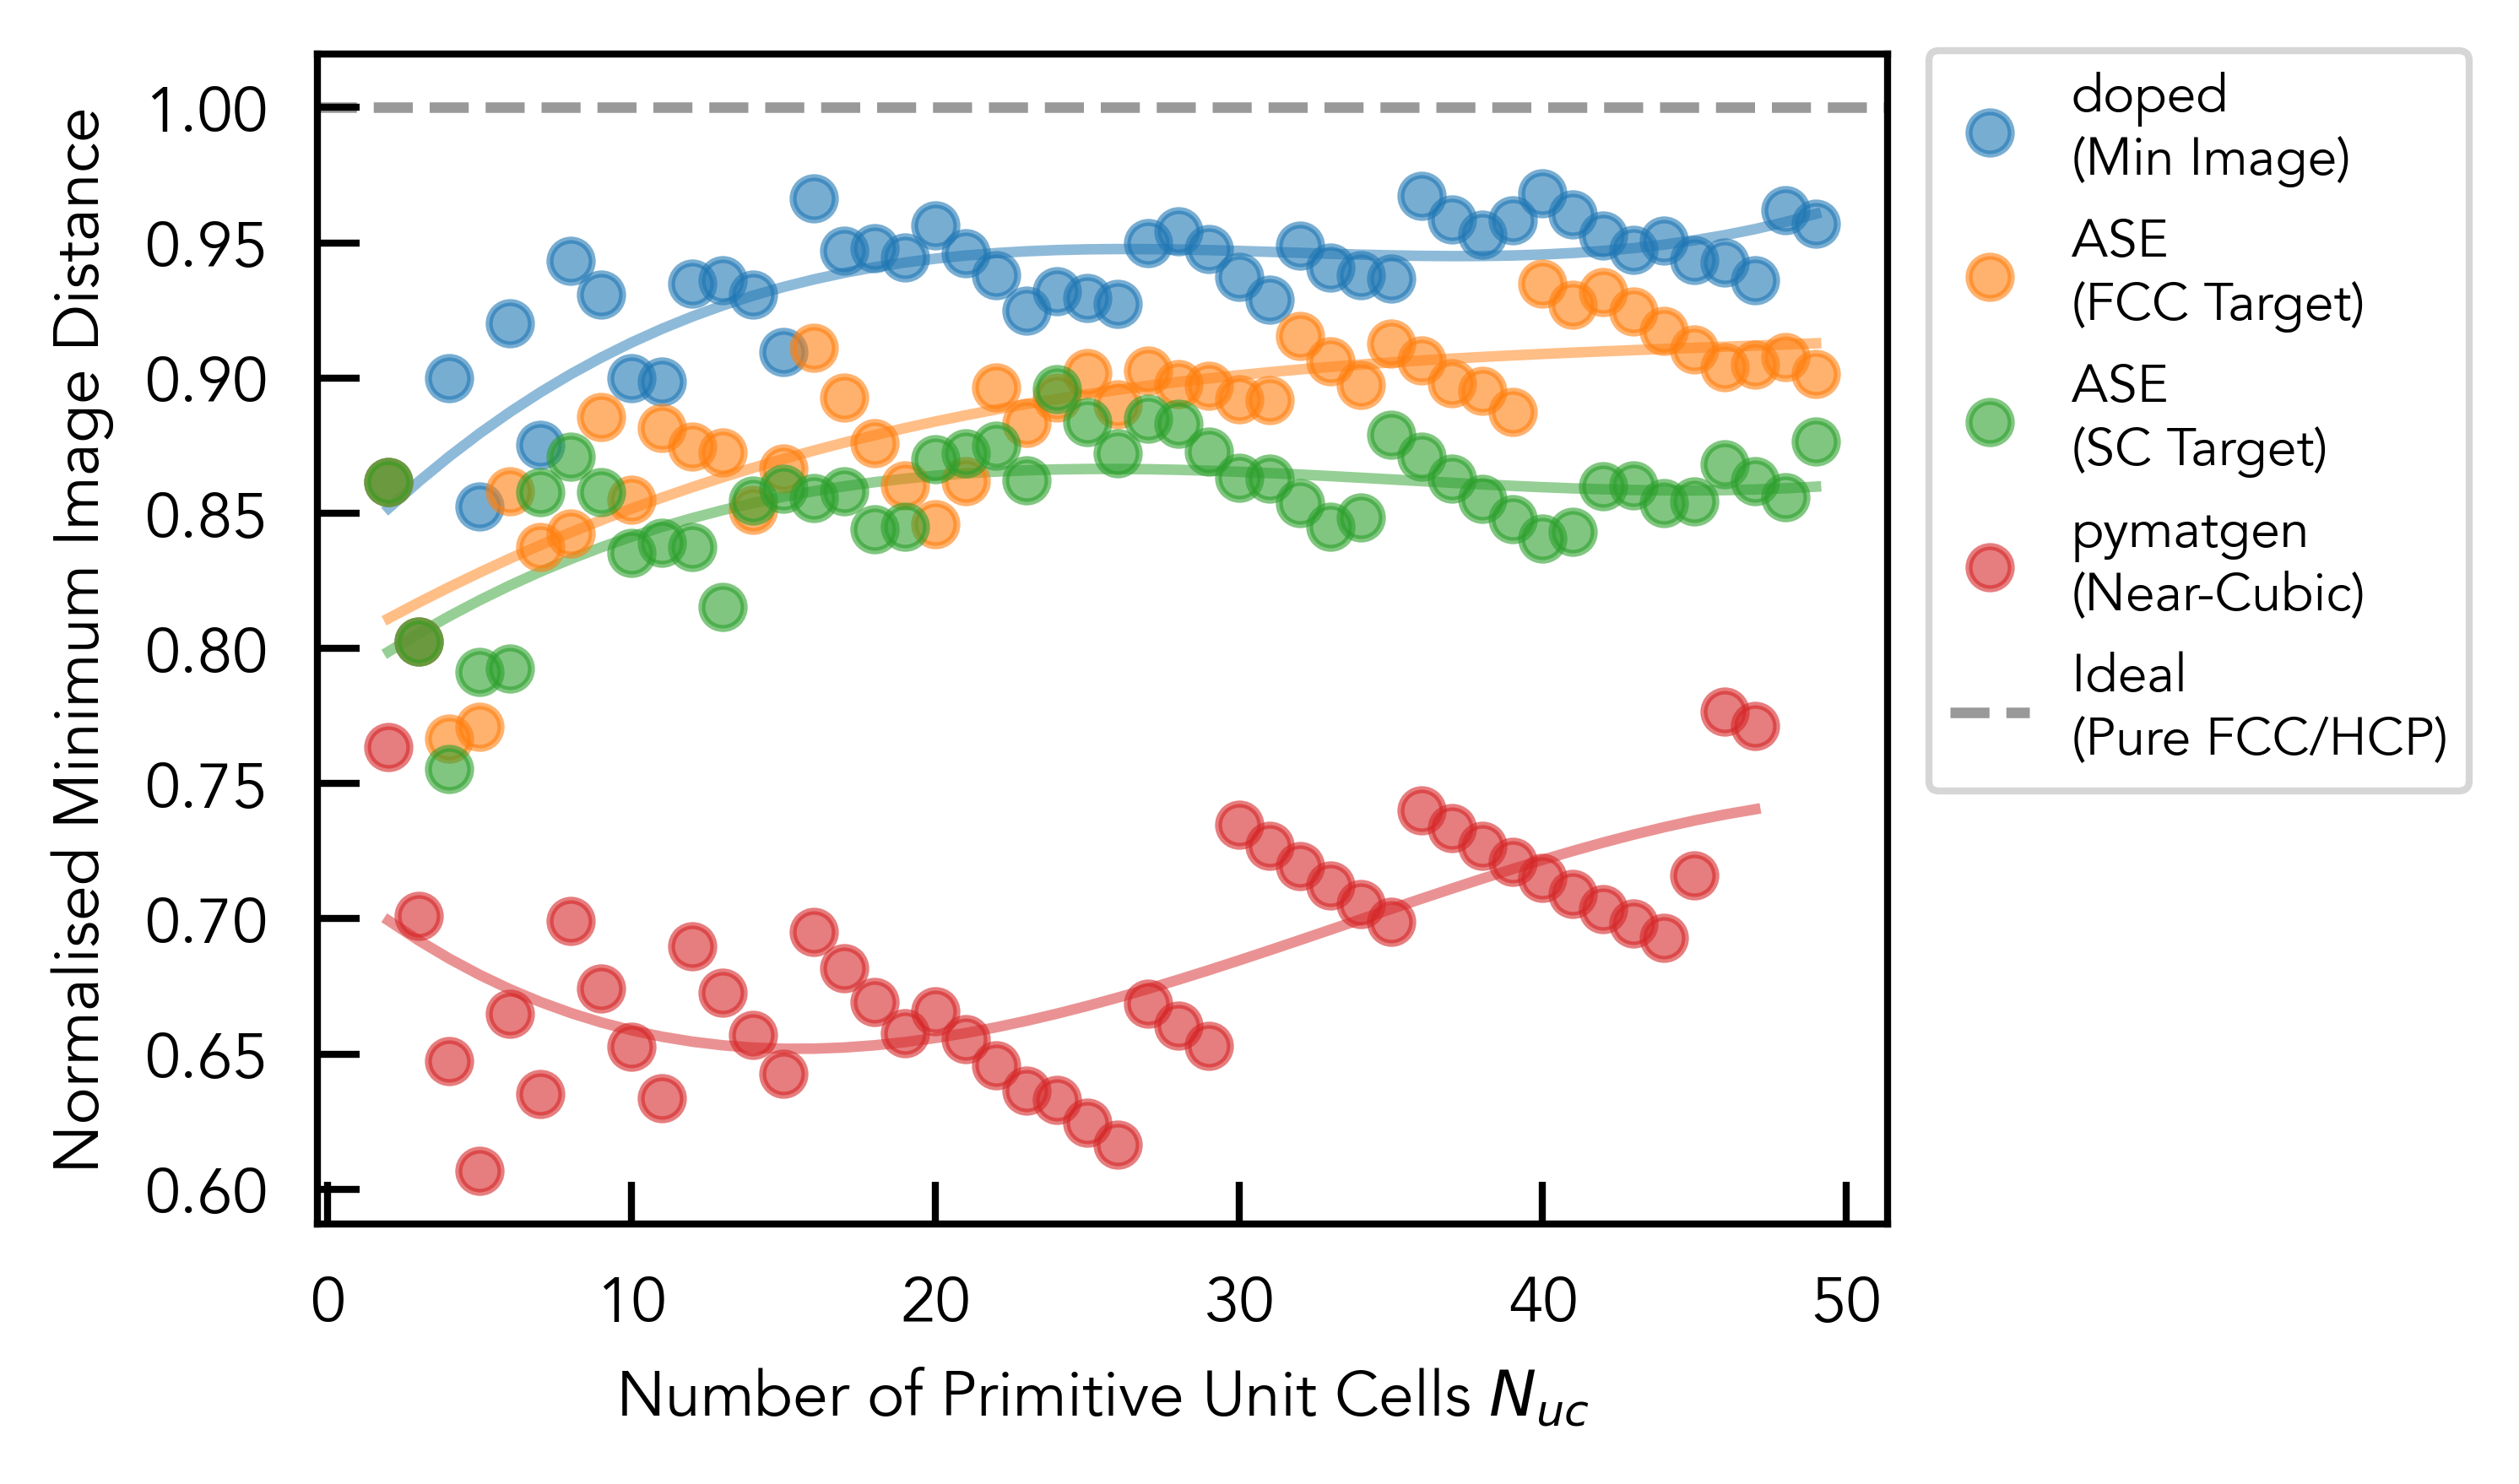

In [245]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
plt.rcdefaults()
plt.style.use("../../doped/utils/doped.mplstyle")

f, ax = plt.subplots(figsize=(4, 3))
ax.set_xlabel(r"Number of Primitive Unit Cells $N_{uc}$")
ax.set_ylabel(r"Normalised Minimum Image Distance")
legend_dict = {
        "doped (Min Image)": "doped\n(Min Image)", 
        "ASE (FCC)": "ASE\n(FCC Target)", 
        "ASE (SC)": "ASE\n(SC Target)", 
        "pymatgen": "pymatgen\n(Near-Cubic)",
}

for i, label in enumerate(["doped (Min Image)", "ASE (FCC)", "ASE (SC)", "pymatgen"]):
    lists = scores[label]
    array_list = [np.array(sub_list) for sub_list in lists]
    max_num_ucs = min([len(array) for array in array_list])  # pmg dict limits to <50
    mean_vals = sum([sub_array[:max_num_ucs] for sub_array in array_list])/len(array_list)

    ax.plot(list(range(2,max_num_ucs+2)), mean_vals, "o", alpha=0.6, label=legend_dict[label],
            c=f"C{i}")
    
    tck, u = splprep([list(range(2,max_num_ucs+2)), mean_vals], s=2)
    new_points = splev(u, tck)
    ax.plot(new_points[0], new_points[1], c=f"C{i}", zorder=0, alpha=0.5)

ax.axhline(1, ls="dashed", c="k", alpha=0.4, zorder=0, label="Ideal\n(Pure FCC/HCP)")
f.legend(bbox_to_anchor=[1.2,0.9])
plt.show()
f.savefig("doped_JOSS_supercell_figure.png", bbox_inches="tight", dpi=600)

# Charge State Guessing (Subfigure **b**)

Here we compare the `doped` charge-state guessing algorithm (with the default `probability_threshold`, though note this can easily be tuned by the user to be more lean/comprehensive) to charge state ranges output by `pymatgen-analysis-defects`, `pyCDT` and `Defectivator` (scripts which use oxidation state probabilities based on ICSD occurrences).

False positives (i.e. efficiency/leanness) not as bad as false negatives (i.e. (in)completeness)

In [1]:
from doped.generation import DefectsGenerator
from pymatgen.core import Structure

In [2]:
def print_false_pos_neg_hits(false_positives, false_negatives, hits):
    print(f"False positives: {false_positives}")
    print(f"False negatives: {false_negatives}")
    print(f"Hits: {hits}")
    print(f"\nFalse positives: {sum([len(val) for val in false_positives.values()])}")
    print(f"False negatives: {sum([len(val) for val in false_negatives.values()])}")
    print(f"Hits: {sum([len(val) for val in hits.values()])}")

def generate_and_compare_doped_charges(tld_stable_charges, struct=None, defect_gen=None):
    if defect_gen is None:
        defect_gen = DefectsGenerator(struct)
    false_positives = {}
    false_negatives = {}
    hits = {}
    for defect, charge_list in tld_stable_charges.items():
        generated_defect_charges = set([
            defect_gen.defect_entries[defect_entry_name
            ].charge_state for defect_entry_name in defect_gen.defect_entries
            if defect_entry_name.startswith(defect)])

        false_negatives[defect] = set(charge_list) - generated_defect_charges
        false_positives[defect] = generated_defect_charges - set(charge_list)
        hits[defect] = (set(charge_list) & generated_defect_charges)
    print_false_pos_neg_hits(false_positives, false_negatives, hits)

def generate_and_compare_pmg_charges(tld_stable_charges, struct=None, defect_gen=None):
    if defect_gen is None:
        defect_gen = DefectsGenerator(struct)
    # pymatgen analysis defects charge states
    false_positives = {}
    false_negatives = {}
    hits = {}
    for defect, charge_list in tld_stable_charges.items():
        generated_defect_charges = [
            defect_gen.defect_entries[defect_entry_name
            ].defect.get_charge_states() for defect_entry_name in defect_gen.defect_entries
            if defect_entry_name.startswith(defect)]
        # flatten:
        generated_defect_charges = set(
            [item for sublist in generated_defect_charges for item in sublist])

        #print(f"{defect}: {generated_defect_charges}")
        false_negatives[defect] = set(charge_list) - generated_defect_charges
        false_positives[defect] = generated_defect_charges - set(charge_list)
        hits[defect] = (set(charge_list) & generated_defect_charges)

    print_false_pos_neg_hits(false_positives, false_negatives, hits)

# https://github.com/alexsquires/defectivator
from defectivator.point_defects import PointDefectSet
def generate_and_compare_defectivator_charges(tld_stable_charges, struct=None,
                                              extrinsic=None):
    if extrinsic is None:
        extrinsic = []
    pds = PointDefectSet(host_structure = struct)
    pds.substitutions = pds._generate_all_antisites()
    pds_defects = pds.vacancies + pds.interstitials + pds.substitutions
    for defect in pds_defects:
        all_charge_states = defect.charge_decorate_structures()

    false_positives = {}
    false_negatives = {}
    hits = {}
    for defect, charge_list in tld_stable_charges.items():
        if any([(f"{i}_" in defect or f"_{i}" in defect) for i in extrinsic]):
            continue
        generated_defect_charges = [
            pds_defect.charges for pds_defect in pds_defects if pds_defect.name.startswith(defect)]
        # flatten:
        generated_defect_charges = set(
            [item for sublist in generated_defect_charges for item in sublist])

        #print(f"{defect}: {generated_defect_charges}")
        false_negatives[defect] = set(charge_list) - generated_defect_charges
        false_positives[defect] = generated_defect_charges - set(charge_list)
        hits[defect] = (set(charge_list) & generated_defect_charges)

    print_false_pos_neg_hits(false_positives, false_negatives, hits)

### CdTe

In [3]:
CdTe_tld_stable_charges = {  # from Kavanagh et al.
    "v_Cd": list(range(-2, 0 + 1)),
    "v_Te": list(range(0, +2 + 1)),
    "Cd_i": list(range(0, +2 + 1)),
    "Te_i": list(range(0, +2 + 1)),
    "Cd_Te": list(range(0, +2 + 1)),
    "Te_Cd": list(range(-2, +2 + 1)),
}

In [5]:
primitive_cdte = Structure.from_file("../../examples/CdTe/relaxed_primitive_POSCAR")
CdTe_defect_gen = DefectsGenerator(primitive_cdte)

Generating DefectEntry objects: 100.0%|██████████| [00:28,   3.45it/s]                             

Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Cd         [+1,0,-1,-2]       [0.000,0.000,0.000]  4a
v_Te         [+2,+1,0,-1]       [0.250,0.250,0.250]  4c

Substitutions    Guessed Charges        Conv. Cell Coords    Wyckoff
---------------  ---------------------  -------------------  ---------
Cd_Te            [+4,+3,+2,+1,0]        [0.250,0.250,0.250]  4c
Te_Cd            [+2,+1,0,-1,-2,-3,-4]  [0.000,0.000,0.000]  4a

Interstitials    Guessed Charges        Conv. Cell Coords    Wyckoff
---------------  ---------------------  -------------------  ---------
Cd_i_C3v         [+2,+1,0]              [0.625,0.625,0.625]  16e
Cd_i_Td_Cd2.83   [+2,+1,0]              [0.750,0.750,0.750]  4d
Cd_i_Td_Te2.83   [+2,+1,0]              [0.500,0.500,0.500]  4b
Te_i_C3v         [+4,+3,+2,+1,0,-1,-2]  [0.625,0.625,0.625]  16e
Te_i_Td_Cd2.83   [+4,+3,+2,+1,0,-1,-2]  [0.750,0.750,0.750]  4d
Te_i_Td_Te2.83   [+4,+3,+2,+1,0,

In [6]:
generate_and_compare_doped_charges(CdTe_tld_stable_charges, defect_gen=CdTe_defect_gen)

False positives: {'v_Cd': {1}, 'v_Te': {-1}, 'Cd_i': set(), 'Te_i': {3, 4, -2, -1}, 'Cd_Te': {3, 4}, 'Te_Cd': {-4, -3}}
False negatives: {'v_Cd': set(), 'v_Te': set(), 'Cd_i': set(), 'Te_i': set(), 'Cd_Te': set(), 'Te_Cd': set()}
Hits: {'v_Cd': {0, -2, -1}, 'v_Te': {0, 1, 2}, 'Cd_i': {0, 1, 2}, 'Te_i': {0, 1, 2}, 'Cd_Te': {0, 1, 2}, 'Te_Cd': {0, 1, 2, -2, -1}}

False positives: 10
False negatives: 0
Hits: 20


In [7]:
# pymatgen analysis defects charge states
generate_and_compare_pmg_charges(CdTe_tld_stable_charges, defect_gen=CdTe_defect_gen)

False positives: {'v_Cd': {1, -3}, 'v_Te': {3, -1}, 'Cd_i': {3, -1}, 'Te_i': {3, 4, 5, -1}, 'Cd_Te': {3, 4, 5, -1}, 'Te_Cd': {-5, -4, -3}}
False negatives: {'v_Cd': set(), 'v_Te': set(), 'Cd_i': set(), 'Te_i': set(), 'Cd_Te': set(), 'Te_Cd': {2}}
Hits: {'v_Cd': {0, -2, -1}, 'v_Te': {0, 1, 2}, 'Cd_i': {0, 1, 2}, 'Te_i': {0, 1, 2}, 'Cd_Te': {0, 1, 2}, 'Te_Cd': {0, 1, -1, -2}}

False positives: 17
False negatives: 1
Hits: 19


In [9]:
import warnings
warnings.filterwarnings("ignore", "The 'delim")
generate_and_compare_defectivator_charges(CdTe_tld_stable_charges, struct=primitive_cdte)

False positives: {'v_Cd': set(), 'v_Te': {-1, -6, -5, -4, -3, -2}, 'Cd_i': set(), 'Te_i': {3, 4, 5, 6, -2, -1}, 'Cd_Te': {3, 4, 5, 6}, 'Te_Cd': {-4, -3}}
False negatives: {'v_Cd': set(), 'v_Te': set(), 'Cd_i': set(), 'Te_i': set(), 'Cd_Te': set(), 'Te_Cd': set()}
Hits: {'v_Cd': {0, -1, -2}, 'v_Te': {0, 1, 2}, 'Cd_i': {0, 1, 2}, 'Te_i': {0, 1, 2}, 'Cd_Te': {0, 1, 2}, 'Te_Cd': {0, 1, 2, -2, -1}}

False positives: 18
False negatives: 0
Hits: 20


### ZnS

In [10]:
zns_tld_stable_charges = {  # Hoang et al. and unpublished work from Aggarwal et al
    "v_Zn": list(range(-2, +2 + 1)),  # oddly stable as +2!
    "v_S": list(range(-2, +2 + 1)),  # -2 has tiny stability window
    "Zn_i": list(range(0, +2 + 1)),
    "S_i": list(range(0, +2 + 1)),  # low energy neutral split interstitial
    "Zn_S": list(range(-2, +2 + 1)),  # -2 is odd...
    "S_Zn": list(range(-2, +2 + 1)),
}

In [12]:
supercell_zns = Structure.from_file("../../tests/data/non_diagonal_ZnS_supercell_POSCAR")
zns_defect_gen = DefectsGenerator(supercell_zns)

Generating DefectEntry objects: 100.0%|██████████| [00:24,   4.17it/s]                             

Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Zn         [+1,0,-1,-2]       [0.000,0.000,0.000]  4a
v_S          [+2,+1,0,-1]       [0.250,0.250,0.250]  4c

Substitutions    Guessed Charges        Conv. Cell Coords    Wyckoff
---------------  ---------------------  -------------------  ---------
Zn_S             [+4,+3,+2,+1,0]        [0.250,0.250,0.250]  4c
S_Zn             [+2,+1,0,-1,-2,-3,-4]  [0.000,0.000,0.000]  4a

Interstitials    Guessed Charges    Conv. Cell Coords    Wyckoff
---------------  -----------------  -------------------  ---------
Zn_i_C3v         [+2,+1,0]          [0.625,0.625,0.625]  16e
Zn_i_Td_S2.35    [+2,+1,0]          [0.500,0.500,0.500]  4b
Zn_i_Td_Zn2.35   [+2,+1,0]          [0.750,0.750,0.750]  4d
S_i_C3v          [+2,+1,0,-1,-2]    [0.625,0.625,0.625]  16e
S_i_Td_S2.35     [+2,+1,0,-1,-2]    [0.500,0.500,0.500]  4b
S_i_Td_Zn2.35    [+2,+1,0,-1,-2]    [0.750,0.750,0.750]  4d


In [13]:
generate_and_compare_doped_charges(zns_tld_stable_charges, defect_gen=zns_defect_gen)

False positives: {'v_Zn': set(), 'v_S': set(), 'Zn_i': set(), 'S_i': {-2, -1}, 'Zn_S': {3, 4}, 'S_Zn': {-4, -3}}
False negatives: {'v_Zn': {2}, 'v_S': {-2}, 'Zn_i': set(), 'S_i': set(), 'Zn_S': {-1, -2}, 'S_Zn': set()}
Hits: {'v_Zn': {0, 1, -1, -2}, 'v_S': {0, 1, 2, -1}, 'Zn_i': {0, 1, 2}, 'S_i': {0, 1, 2}, 'Zn_S': {0, 1, 2}, 'S_Zn': {0, 1, 2, -2, -1}}

False positives: 6
False negatives: 4
Hits: 22


False negatives here are the odd charge states as expected

In [14]:
# pymatgen analysis defects charge states
generate_and_compare_pmg_charges(zns_tld_stable_charges, defect_gen=zns_defect_gen)

False positives: {'v_Zn': {-3}, 'v_S': {3}, 'Zn_i': {3, -1}, 'S_i': {3, -1}, 'Zn_S': {3, 4, 5}, 'S_Zn': {-5, -4, -3}}
False negatives: {'v_Zn': {2}, 'v_S': {-2}, 'Zn_i': set(), 'S_i': set(), 'Zn_S': {-2}, 'S_Zn': {2}}
Hits: {'v_Zn': {0, 1, -1, -2}, 'v_S': {0, 1, 2, -1}, 'Zn_i': {0, 1, 2}, 'S_i': {0, 1, 2}, 'Zn_S': {0, 1, 2, -1}, 'S_Zn': {0, 1, -1, -2}}

False positives: 12
False negatives: 4
Hits: 22


In [15]:
generate_and_compare_defectivator_charges(zns_tld_stable_charges, struct=supercell_zns)

False positives: {'v_Zn': set(), 'v_S': {-6, -5, -4, -3}, 'Zn_i': set(), 'S_i': {3, 4, 5, 6, -2, -1}, 'Zn_S': {3, 4, 5, 6}, 'S_Zn': {-4, -3}}
False negatives: {'v_Zn': {1, 2}, 'v_S': set(), 'Zn_i': set(), 'S_i': set(), 'Zn_S': {-1, -2}, 'S_Zn': set()}
Hits: {'v_Zn': {0, -1, -2}, 'v_S': {0, 1, 2, -2, -1}, 'Zn_i': {0, 1, 2}, 'S_i': {0, 1, 2}, 'Zn_S': {0, 1, 2}, 'S_Zn': {0, 1, 2, -2, -1}}

False positives: 16
False negatives: 4
Hits: 22


### YTOS

In [16]:
ytos_tld_stable_charges = {  # unpublished work from Nicolson, Brlec et al.
    "v_O": list(range(0, +2 + 1)),
    "v_S": list(range(0, +2 + 1)),
    "v_Y": list(range(-3, 0 + 1)),
    "v_Ti": list(range(-4, 0 + 1)),
    "O_i": list(range(-2, 0 + 1)),
    "Ti_i": list(range(0, +4 + 1)),
    "S_i": list(range(0, +4 + 1)),
    "Y_i": list(range(0, +3 + 1)),
    "O_S": list(range(0, 0 + 1)),
    "S_O": list(range(0, 0 + 1)),
    "S_Ti": list(range(0, +2 + 1)),  # not stable in a negative charge state?
    "S_Y": list(range(0, +3 + 1)),  # not stable in a negative charge state?
    "Ti_Y": list(range(0, +1 + 1)),
    "Y_Ti": list(range(-1, 0 + 1)),
}

In [18]:
ytos_struc = Structure.from_file("../../examples/YTOS/Bulk/POSCAR")  # Y2Ti2S2O5
ytos_defect_gen = DefectsGenerator(ytos_struc)

Generating DefectEntry objects: 100.0%|██████████| [01:08,   1.45it/s]                            

Vacancies    Guessed Charges     Conv. Cell Coords    Wyckoff
-----------  ------------------  -------------------  ---------
v_Y          [+1,0,-1,-2,-3]     [0.000,0.000,0.334]  4e
v_Ti         [+1,0,-1,-2,-3,-4]  [0.000,0.000,0.079]  4e
v_S          [+2,+1,0,-1]        [0.000,0.000,0.205]  4e
v_O_C2v      [+2,+1,0,-1]        [0.000,0.500,0.099]  8g
v_O_D4h      [+2,+1,0,-1]        [0.000,0.000,0.000]  2a

Substitutions    Guessed Charges              Conv. Cell Coords    Wyckoff
---------------  ---------------------------  -------------------  ---------
Y_Ti             [0,-1]                       [0.000,0.000,0.079]  4e
Y_S              [+5,+4,+3,+2,+1,0]           [0.000,0.000,0.205]  4e
Y_O_C2v          [+5,+4,+3,+2,+1,0]           [0.000,0.500,0.099]  8g
Y_O_D4h          [+5,+4,+3,+2,+1,0]           [0.000,0.000,0.000]  2a
Ti_Y             [+1,0,-1]                    [0.000,0.000,0.334]  4e
Ti_S             [+6,+5,+4,+3,+2,+1,0]        [0.000,0.000,0.205]  4e
Ti_O_C2v        

In [19]:
generate_and_compare_doped_charges(ytos_tld_stable_charges, defect_gen=ytos_defect_gen)

False positives: {'v_O': {-1}, 'v_S': {-1}, 'v_Y': {1}, 'v_Ti': {1}, 'O_i': set(), 'Ti_i': set(), 'S_i': {-2, -1}, 'Y_i': set(), 'O_S': {1, -1}, 'S_O': {1, -1}, 'S_Ti': {-1, -6, -5, -4, -3, -2}, 'S_Y': {-1, -5, -4, -3, -2}, 'Ti_Y': {-1}, 'Y_Ti': set()}
False negatives: {'v_O': set(), 'v_S': set(), 'v_Y': set(), 'v_Ti': set(), 'O_i': set(), 'Ti_i': set(), 'S_i': set(), 'Y_i': set(), 'O_S': set(), 'S_O': set(), 'S_Ti': set(), 'S_Y': set(), 'Ti_Y': set(), 'Y_Ti': set()}
Hits: {'v_O': {0, 1, 2}, 'v_S': {0, 1, 2}, 'v_Y': {0, -3, -2, -1}, 'v_Ti': {0, -2, -4, -3, -1}, 'O_i': {0, -1, -2}, 'Ti_i': {0, 1, 2, 3, 4}, 'S_i': {0, 1, 2, 3, 4}, 'Y_i': {0, 1, 2, 3}, 'O_S': {0}, 'S_O': {0}, 'S_Ti': {0, 1, 2}, 'S_Y': {0, 1, 2, 3}, 'Ti_Y': {0, 1}, 'Y_Ti': {0, -1}}

False positives: 22
False negatives: 0
Hits: 45


In [20]:
# pymatgen analysis defects charge states
generate_and_compare_pmg_charges(ytos_tld_stable_charges, defect_gen=ytos_defect_gen)

False positives: {'v_O': {3, -1}, 'v_S': {3, -1}, 'v_Y': {1, -4}, 'v_Ti': {1, -5}, 'O_i': {1, -3}, 'Ti_i': {-1}, 'S_i': {-1}, 'Y_i': {4, -1}, 'O_S': {1, -1}, 'S_O': {1, -1}, 'S_Ti': {-2, -7, -6, -5, -4, -3, -1}, 'S_Y': {-2, -6, -5, -4, -3, -1}, 'Ti_Y': {2, -1}, 'Y_Ti': {1, -2}}
False negatives: {'v_O': set(), 'v_S': set(), 'v_Y': set(), 'v_Ti': set(), 'O_i': set(), 'Ti_i': set(), 'S_i': {4}, 'Y_i': set(), 'O_S': set(), 'S_O': set(), 'S_Ti': {2}, 'S_Y': {2, 3}, 'Ti_Y': set(), 'Y_Ti': set()}
Hits: {'v_O': {0, 1, 2}, 'v_S': {0, 1, 2}, 'v_Y': {0, -3, -2, -1}, 'v_Ti': {0, -2, -4, -3, -1}, 'O_i': {0, -2, -1}, 'Ti_i': {0, 1, 2, 3, 4}, 'S_i': {0, 1, 2, 3}, 'Y_i': {0, 1, 2, 3}, 'O_S': {0}, 'S_O': {0}, 'S_Ti': {0, 1}, 'S_Y': {0, 1}, 'Ti_Y': {0, 1}, 'Y_Ti': {0, -1}}

False positives: 35
False negatives: 4
Hits: 41


In [21]:
generate_and_compare_defectivator_charges(ytos_tld_stable_charges, struct=ytos_struc)

False positives: {'v_O': set(), 'v_S': {-1, -6, -5, -4, -3, -2}, 'v_Y': set(), 'v_Ti': set(), 'O_i': set(), 'Ti_i': set(), 'S_i': {-2, 5, 6, -1}, 'Y_i': set(), 'O_S': {-2, -1}, 'S_O': {-1, -8, -7, -6, -5, -4, -3, -2}, 'S_Ti': {3, 4, -1, -2}, 'S_Y': {-3, -1, -2}, 'Ti_Y': {2, 3, -1}, 'Y_Ti': {1, 2, 3, 4}}
False negatives: {'v_O': set(), 'v_S': set(), 'v_Y': set(), 'v_Ti': set(), 'O_i': set(), 'Ti_i': set(), 'S_i': set(), 'Y_i': set(), 'O_S': set(), 'S_O': set(), 'S_Ti': set(), 'S_Y': set(), 'Ti_Y': set(), 'Y_Ti': {-1}}
Hits: {'v_O': {0, 1, 2}, 'v_S': {0, 1, 2}, 'v_Y': {0, -3, -1, -2}, 'v_Ti': {0, -1, -4, -3, -2}, 'O_i': {0, -2, -1}, 'Ti_i': {0, 1, 2, 3, 4}, 'S_i': {0, 1, 2, 3, 4}, 'Y_i': {0, 1, 2, 3}, 'O_S': {0}, 'S_O': {0}, 'S_Ti': {0, 1, 2}, 'S_Y': {0, 1, 2, 3}, 'Ti_Y': {0, 1}, 'Y_Ti': {0}}

False positives: 34
False negatives: 1
Hits: 44


### LMNO

In [22]:
lmno_tld_stable_charges = {  # Cen et al; https://pubs.rsc.org/en/content/articlelanding/2023/ta/d3ta00532a
    "v_Li": list(range(-1, 0 + 1)),
    "v_Mn": list(range(-3, 0 + 1)),
    "v_Ni": list(range(-2, 0 + 1)),
    "v_O": list(range(0, 1 + 1)),
    "Li_i": list(range(0, 1 + 1)),
    "Mn_i": list(range(0, +3 + 1)),
    "Ni_i": list(range(0, +2 + 1)),
    "O_i": list(range(-1, 0 + 1)),
    "Li_Mn": list(range(-2, 0 + 1)),
    "Mn_Li": list(range(1, 1 + 1)),
    "Ni_Li": list(range(0, +1 + 1)),
    "Li_Ni": list(range(-1, 0 + 1)),
    "Mn_Ni": list(range(0, +1 + 1)),
    "Ni_Mn": list(range(-1, 0 + 1)),
}

In [23]:
lmno_struct = Structure.from_file("../../tests/data/Li2Mn3NiO8_POSCAR")
lmno_defect_gen = DefectsGenerator(lmno_struct)

Generating DefectEntry objects: 100.0%|██████████| [01:15,   1.33it/s]                            

Vacancies    Guessed Charges     Conv. Cell Coords    Wyckoff
-----------  ------------------  -------------------  ---------
v_Li         [+1,0,-1]           [0.004,0.004,0.004]  8c
v_Mn         [+1,0,-1,-2,-3,-4]  [0.121,0.129,0.625]  12d
v_Ni         [+1,0,-1,-2]        [0.625,0.625,0.625]  4b
v_O_C1       [+2,+1,0,-1]        [0.101,0.124,0.392]  24e
v_O_C3       [+2,+1,0,-1]        [0.385,0.385,0.385]  8c

Substitutions    Guessed Charges        Conv. Cell Coords    Wyckoff
---------------  ---------------------  -------------------  ---------
Li_Mn            [0,-1,-2,-3]           [0.121,0.129,0.625]  12d
Li_Ni            [0,-1]                 [0.625,0.625,0.625]  4b
Li_O_C1          [+3,+2,+1,0]           [0.101,0.124,0.392]  24e
Li_O_C3          [+3,+2,+1,0]           [0.385,0.385,0.385]  8c
Mn_Li            [+3,+2,+1,0]           [0.004,0.004,0.004]  8c
Mn_Ni            [+2,+1,0]              [0.625,0.625,0.625]  4b
Mn_O_C1          [+6,+5,+4,+3,+2,+1,0]  [0.101,0.124,0.392] 

In [24]:
generate_and_compare_doped_charges(lmno_tld_stable_charges, defect_gen=lmno_defect_gen)

False positives: {'v_Li': {1}, 'v_Mn': {1, -4}, 'v_Ni': {1}, 'v_O': {2, -1}, 'Li_i': set(), 'Mn_i': {4}, 'Ni_i': {3, 4}, 'O_i': {-2}, 'Li_Mn': {-3}, 'Mn_Li': {0, 2, 3}, 'Ni_Li': {2, 3}, 'Li_Ni': set(), 'Mn_Ni': {2}, 'Ni_Mn': {-3, -2}}
False negatives: {'v_Li': set(), 'v_Mn': set(), 'v_Ni': set(), 'v_O': set(), 'Li_i': set(), 'Mn_i': set(), 'Ni_i': set(), 'O_i': set(), 'Li_Mn': set(), 'Mn_Li': set(), 'Ni_Li': set(), 'Li_Ni': set(), 'Mn_Ni': set(), 'Ni_Mn': set()}
Hits: {'v_Li': {0, -1}, 'v_Mn': {0, -3, -2, -1}, 'v_Ni': {0, -2, -1}, 'v_O': {0, 1}, 'Li_i': {0, 1}, 'Mn_i': {0, 1, 2, 3}, 'Ni_i': {0, 1, 2}, 'O_i': {0, -1}, 'Li_Mn': {0, -2, -1}, 'Mn_Li': {1}, 'Ni_Li': {0, 1}, 'Li_Ni': {0, -1}, 'Mn_Ni': {0, 1}, 'Ni_Mn': {0, -1}}

False positives: 19
False negatives: 0
Hits: 34


In [25]:
# pymatgen analysis defects charge states
generate_and_compare_pmg_charges(lmno_tld_stable_charges, defect_gen=lmno_defect_gen)

False positives: {'v_Li': {1, -2}, 'v_Mn': {1, -5, -4}, 'v_Ni': {1, -3}, 'v_O': {2, 3, -1}, 'Li_i': {2, -1}, 'Mn_i': {4, -1}, 'Ni_i': {3, -1}, 'O_i': {1, -3, -2}, 'Li_Mn': {1, -4, -3}, 'Mn_Li': {0, 2, 3, 4, -1}, 'Ni_Li': {2, -1}, 'Li_Ni': {1, -2}, 'Mn_Ni': {2, 3, -1}, 'Ni_Mn': {1, -3, -2}}
False negatives: {'v_Li': set(), 'v_Mn': set(), 'v_Ni': set(), 'v_O': set(), 'Li_i': set(), 'Mn_i': set(), 'Ni_i': set(), 'O_i': set(), 'Li_Mn': set(), 'Mn_Li': set(), 'Ni_Li': set(), 'Li_Ni': set(), 'Mn_Ni': set(), 'Ni_Mn': set()}
Hits: {'v_Li': {0, -1}, 'v_Mn': {0, -3, -2, -1}, 'v_Ni': {0, -2, -1}, 'v_O': {0, 1}, 'Li_i': {0, 1}, 'Mn_i': {0, 1, 2, 3}, 'Ni_i': {0, 1, 2}, 'O_i': {0, -1}, 'Li_Mn': {0, -2, -1}, 'Mn_Li': {1}, 'Ni_Li': {0, 1}, 'Li_Ni': {0, -1}, 'Mn_Ni': {0, 1}, 'Ni_Mn': {0, -1}}

False positives: 37
False negatives: 0
Hits: 34


In [26]:
generate_and_compare_defectivator_charges(lmno_tld_stable_charges, struct=lmno_struct)

False positives: {'v_Li': set(), 'v_Mn': {-4}, 'v_Ni': {-3}, 'v_O': {2}, 'Li_i': set(), 'Mn_i': {4}, 'Ni_i': {3}, 'O_i': {-2}, 'Li_Mn': {1, 2, 3, 4}, 'Mn_Li': {0, -3, -1, -2}, 'Ni_Li': {-2, -1}, 'Li_Ni': {1, 2, 3}, 'Mn_Ni': {2, 3, -1}, 'Ni_Mn': {1, 2, 3, 4}}
False negatives: {'v_Li': set(), 'v_Mn': set(), 'v_Ni': set(), 'v_O': set(), 'Li_i': set(), 'Mn_i': set(), 'Ni_i': set(), 'O_i': set(), 'Li_Mn': {-2, -1}, 'Mn_Li': set(), 'Ni_Li': set(), 'Li_Ni': {-1}, 'Mn_Ni': set(), 'Ni_Mn': {-1}}
Hits: {'v_Li': {0, -1}, 'v_Mn': {0, -3, -2, -1}, 'v_Ni': {0, -2, -1}, 'v_O': {0, 1}, 'Li_i': {0, 1}, 'Mn_i': {0, 1, 2, 3}, 'Ni_i': {0, 1, 2}, 'O_i': {0, -1}, 'Li_Mn': {0}, 'Mn_Li': {1}, 'Ni_Li': {0, 1}, 'Li_Ni': {0}, 'Mn_Ni': {0, 1}, 'Ni_Mn': {0}}

False positives: 26
False negatives: 4
Hits: 30


### Na$_2$FePO$_4$F

In [27]:
na2fepo4f_tld_stable_charges = {  # unpublished work from Dan Sykes
    "v_Na": list(range(-1, 0 + 1)),
    "v_Fe": list(range(-2, 0 + 1)),
    "v_P": list(range(-5, 0 + 1)),
    "v_O": list(range(0, +2 + 1)),
    "v_F": list(range(0, +1 + 1)),
    "Na_i": list(range(0, +1 + 1)),
    "Fe_i": list(range(0, +2 + 1)),
    "P_i": list(range(0, +5 + 1)),
    "O_i": list(range(-2, 0 + 1)),
    "F_i": list(range(-1, 0 + 1)),
    "Na_Fe": list(range(-1, 0 + 1)),
    "Na_P": list(range(-4, 0 + 1)),
    "Na_O": list(range(0, +1 + 1)), # +2, +3 -> tested but not stable
    "Na_F": list(range(0, +2 + 1)),
    "Fe_Na": list(range(0, +1 + 1)),  # Comments below are charge states that were tested but not stable
    "Fe_P": list(range(-2, 0 + 1)), # -3
    "Fe_O": list(range(0, +2 + 1)), # +3, +4
    "Fe_F": list(range(0, +2 + 1)), # +3
    "P_Na": list(range(0, +1 + 1)), # +2, +3. +4
    "P_Fe": list(range(0, +3 + 1)), # +1, +2
    "P_O": list(range(0, +1 + 1)), # +2, +3, +4, +5, +6, +7
    "P_F": list(range(0, +1 + 1)), # +2, +3, +4, +5, +6
    "O_Na": list(range(-2, 0 + 1)), # -3
    "O_Fe": list(range(-2, 0 + 1)), # -3, -4
    "O_P": list(range(-2, 0 + 1)), # -3, -4, -5, -6, -7
    "O_F": list(range(-1, 0 + 1)), # 0
    "F_Na": list(range(-1, 0 + 1)), # -2
    "F_Fe": list(range(-2, 0 + 1)), # -3
    "F_P": list(range(-2, 0 + 1)), # -3, -4, -5, -6
    "F_O": list(range(0, +1 + 1)),
}

In [29]:
mp_na2fepo4f = Structure.from_file("data/Na2FePO4F_POSCAR")
na2fepo4f_defect_gen = DefectsGenerator(mp_na2fepo4f)

Generating DefectEntry objects: 100.0%|██████████| [03:17,   1.98s/it]                            

Vacancies      Guessed Charges        Conv. Cell Coords    Wyckoff
-------------  ---------------------  -------------------  ---------
v_Na_C1_F2.38  [+1,0,-1]              [0.236,0.255,0.328]  8d
v_Na_C1_O2.32  [+1,0,-1]              [0.261,0.375,0.083]  8d
v_Fe           [+1,0,-1,-2]           [0.272,0.490,0.326]  8d
v_P            [+1,0,-1,-2,-3,-4,-5]  [0.296,0.119,0.087]  8d
v_O_C1_P1.54   [+2,+1,0,-1]           [0.215,0.217,0.133]  8d
v_O_C1_P1.55   [+2,+1,0,-1]           [0.267,0.388,0.460]  8d
v_O_C1_P1.57   [+2,+1,0,-1]           [0.161,0.036,0.151]  8d
v_O_C1_P1.58   [+2,+1,0,-1]           [0.409,0.106,0.397]  8d
v_F            [+1,0,-1,+1,0,-1]      [0.272,0.490,0.326]  8d
v_F_C2         [+1,0,-1]              [0.500,0.376,0.250]  4c

Substitutions    Guessed Charges                                        Conv. Cell Coords    Wyckoff
---------------  -----------------------------------------------------  -------------------  ---------
Na_Fe            [0,-1]                

In [30]:
generate_and_compare_doped_charges(na2fepo4f_tld_stable_charges, defect_gen=na2fepo4f_defect_gen)

False positives: {'v_Na': {1}, 'v_Fe': {1}, 'v_P': {1}, 'v_O': {-1}, 'v_F': {-1, -2}, 'Na_i': set(), 'Fe_i': {3}, 'P_i': {-3, -2, -1}, 'O_i': set(), 'F_i': set(), 'Na_Fe': set(), 'Na_P': set(), 'Na_O': {2, 3}, 'Na_F': {-1}, 'Fe_Na': {2}, 'Fe_P': {-3}, 'Fe_O': {3, 4, 5}, 'Fe_F': {3, 4}, 'P_Na': {2, 3, 4, -1, -4, -3, -2}, 'P_Fe': {-1, -5, -4, -3, -2}, 'P_O': {2, 3, 4, 5, 6, 7, -1}, 'P_F': {2, 3, 4, 5, 6, -2, -5, -4, -3, -1}, 'O_Na': {-3}, 'O_Fe': {-4, -3}, 'O_P': {-7, -6, -5, -4, -3}, 'O_F': {-4, -3, -2}, 'F_Na': {-2}, 'F_Fe': {-3}, 'F_P': {-6, -5, -4, -3}, 'F_O': set()}
False negatives: {'v_Na': set(), 'v_Fe': set(), 'v_P': set(), 'v_O': set(), 'v_F': set(), 'Na_i': set(), 'Fe_i': set(), 'P_i': set(), 'O_i': set(), 'F_i': set(), 'Na_Fe': set(), 'Na_P': set(), 'Na_O': set(), 'Na_F': set(), 'Fe_Na': set(), 'Fe_P': set(), 'Fe_O': set(), 'Fe_F': set(), 'P_Na': set(), 'P_Fe': set(), 'P_O': set(), 'P_F': set(), 'O_Na': set(), 'O_Fe': set(), 'O_P': set(), 'O_F': set(), 'F_Na': set(), 'F_Fe': s

In [31]:
# pymatgen analysis defects charge states
generate_and_compare_pmg_charges(na2fepo4f_tld_stable_charges, defect_gen=na2fepo4f_defect_gen)

False positives: {'v_Na': {1, -2}, 'v_Fe': {1, -3}, 'v_P': {1, -6}, 'v_O': {3, -1}, 'v_F': {2, -3, -1, -2}, 'Na_i': {2, -1}, 'Fe_i': {3, 4, -1}, 'P_i': {-1}, 'O_i': {1, -3}, 'F_i': {1, -2}, 'Na_Fe': {1, -2}, 'Na_P': {1, -5}, 'Na_O': {2, 3, 4, -1}, 'Na_F': {3, -1, -2}, 'Fe_Na': {2, -1}, 'Fe_P': {1, -4, -3}, 'Fe_O': {3, 4, 5, -1}, 'Fe_F': {3, 4, -1}, 'P_Na': {2, 3, 4, 5, -1}, 'P_Fe': {4, -1}, 'P_O': {2, 3, 4, 5, 6, 7, 8, -1}, 'P_F': {2, 3, 4, 5, 6, 7, -1}, 'O_Na': {1, -4, -3}, 'O_Fe': {1, -5, -4, -3}, 'O_P': {1, -8, -7, -6, -5, -4, -3}, 'O_F': {1, -5, -4, -3, -2}, 'F_Na': {1, -3, -2}, 'F_Fe': {1, -4, -3}, 'F_P': {1, -7, -6, -5, -4, -3}, 'F_O': {2, -1}}
False negatives: {'v_Na': set(), 'v_Fe': set(), 'v_P': set(), 'v_O': set(), 'v_F': set(), 'Na_i': set(), 'Fe_i': set(), 'P_i': set(), 'O_i': set(), 'F_i': set(), 'Na_Fe': set(), 'Na_P': set(), 'Na_O': set(), 'Na_F': set(), 'Fe_Na': set(), 'Fe_P': set(), 'Fe_O': set(), 'Fe_F': set(), 'P_Na': set(), 'P_Fe': set(), 'P_O': set(), 'P_F': set(),

In [32]:
generate_and_compare_defectivator_charges(na2fepo4f_tld_stable_charges, struct=mp_na2fepo4f)

False positives: {'v_Na': set(), 'v_Fe': {-3}, 'v_P': {1, 2, 3}, 'v_O': set(), 'v_F': {-3, -2, -1}, 'Na_i': set(), 'Fe_i': {3}, 'P_i': {-3, -1, -2}, 'O_i': set(), 'F_i': set(), 'Na_Fe': {1, 2, 3}, 'Na_P': {1, 2, 3, 4, 5}, 'Na_O': set(), 'Na_F': {3}, 'Fe_Na': {-2, -1}, 'Fe_P': {1, 2, 3, 4, 5}, 'Fe_O': set(), 'Fe_F': set(), 'P_Na': {-4, -3, -1, -2}, 'P_Fe': {-1, -2}, 'P_O': {-2, -7, -6, -5, -4, -3, -1}, 'P_F': {2, 3, -2, -6, -5, -4, -3, -1}, 'O_Na': set(), 'O_Fe': set(), 'O_P': {-3}, 'O_F': set(), 'F_Na': set(), 'F_Fe': set(), 'F_P': {-3}, 'F_O': {-2, -1}}
False negatives: {'v_Na': set(), 'v_Fe': set(), 'v_P': set(), 'v_O': set(), 'v_F': set(), 'Na_i': set(), 'Fe_i': set(), 'P_i': set(), 'O_i': set(), 'F_i': set(), 'Na_Fe': {-1}, 'Na_P': {-4, -3, -1, -2}, 'Na_O': {0, 1}, 'Na_F': set(), 'Fe_Na': set(), 'Fe_P': {-2, -1}, 'Fe_O': {0, 1, 2}, 'Fe_F': {0, 1, 2}, 'P_Na': set(), 'P_Fe': set(), 'P_O': {1}, 'P_F': set(), 'O_Na': {0, -2, -1}, 'O_Fe': {0, -2, -1}, 'O_P': set(), 'O_F': set(), 'F_Na':

Antisites missing from defectivator here? Not sure why, will account for this later

### BaBi2O$_6$

In [52]:
babio_tld_stable_charges = {  # Ganose & Spooner et al, 10.1021/acs.chemmater.1c02164
    "v_Ba": list(range(-2, 0 + 1)),
    "v_Bi": list(range(-2, 0 + 1)),
    "v_O": list(range(0, +2 + 1)),

    "Ba_i": list(range(0, +2 + 1)),
    "Bi_i": list(range(+1, +2 + 1)),
    "O_i": list(range(0, 0 + 1)),

    "Ba_Bi": list(range(-2, 0 + 1)),
    "Bi_Ba": list(range(+1, +1 + 1)),

    "La_i": list(range(0, +3 + 1)),
    "La_Ba": list(range(+1, +1 + 1)),
    "La_Bi": list(range(-2, 0 + 1)),

    "F_i": list(range(-1, +1 + 1)),
    "F_O": list(range(+1, +1 + 1)),
}
# The O is a bit anomalous, for the vacancy it's not negative-U like similar oxides, and for the
# interstitial it relaxes close to another oxygen and forms a neutral defect through the whole band gap

In [53]:
oqmd_babio = Structure.from_file("data/BaBi2O6_POSCAR")
babio_defect_gen = DefectsGenerator(oqmd_babio, extrinsic=["La", "F"])

Generating DefectEntry objects: 100.0%|██████████| [00:45,   2.22it/s]                            

Vacancies    Guessed Charges        Conv. Cell Coords    Wyckoff
-----------  ---------------------  -------------------  ---------
v_Ba         [+1,0,-1,-2]           [0.000,0.000,0.000]  1a
v_Bi         [+1,0,-1,-2,-3,-4,-5]  [0.333,0.667,0.500]  2d
v_O          [+2,+1,0,-1]           [0.382,0.382,0.287]  6k

Substitutions    Guessed Charges           Conv. Cell Coords    Wyckoff
---------------  ------------------------  -------------------  ---------
Ba_Bi            [0,-1,-2,-3]              [0.333,0.667,0.500]  2d
Ba_O             [+4,+3,+2,+1,0]           [0.382,0.382,0.287]  6k
Bi_Ba            [+3,+2,+1,0,-1]           [0.000,0.000,0.000]  1a
Bi_O             [+7,+6,+5,+4,+3,+2,+1,0]  [0.382,0.382,0.287]  6k
O_Ba             [0,-1,-2,-3,-4]           [0.000,0.000,0.000]  1a
O_Bi             [0,-1,-2,-3,-4,-5,-6,-7]  [0.333,0.667,0.500]  2d
F_Ba             [0,-1,-2,-3]              [0.000,0.000,0.000]  1a
F_Bi             [0,-1,-2,-3,-4,-5,-6]     [0.333,0.667,0.500]  2d
F_O  

In [54]:
generate_and_compare_doped_charges(babio_tld_stable_charges, defect_gen=babio_defect_gen)

False positives: {'v_Ba': {1}, 'v_Bi': {1, -5, -4, -3}, 'v_O': {-1}, 'Ba_i': set(), 'Bi_i': {0, 3, 4, 5}, 'O_i': {-1, -2}, 'Ba_Bi': {-3}, 'Bi_Ba': {0, 2, 3, -1}, 'La_i': set(), 'La_Ba': {0}, 'La_Bi': {-3}, 'F_i': set(), 'F_O': {0}}
False negatives: {'v_Ba': set(), 'v_Bi': set(), 'v_O': set(), 'Ba_i': set(), 'Bi_i': set(), 'O_i': set(), 'Ba_Bi': set(), 'Bi_Ba': set(), 'La_i': set(), 'La_Ba': set(), 'La_Bi': set(), 'F_i': {1}, 'F_O': set()}
Hits: {'v_Ba': {0, -2, -1}, 'v_Bi': {0, -2, -1}, 'v_O': {0, 1, 2}, 'Ba_i': {0, 1, 2}, 'Bi_i': {1, 2}, 'O_i': {0}, 'Ba_Bi': {0, -2, -1}, 'Bi_Ba': {1}, 'La_i': {0, 1, 2, 3}, 'La_Ba': {1}, 'La_Bi': {0, -2, -1}, 'F_i': {0, -1}, 'F_O': {1}}

False positives: 20
False negatives: 1
Hits: 30


In [55]:
# pymatgen analysis defects charge states
generate_and_compare_pmg_charges(babio_tld_stable_charges, defect_gen=babio_defect_gen)

False positives: {'v_Ba': {1, -3}, 'v_Bi': {1, -6, -5, -4, -3}, 'v_O': {3, -1}, 'Ba_i': {3, -1}, 'Bi_i': {0, 3, -1}, 'O_i': {1, -3, -1, -2}, 'Ba_Bi': {1, -4, -3}, 'Bi_Ba': {0, 2, 3, 4, -1}, 'La_i': {4, -1}, 'La_Ba': {0, 2, -1}, 'La_Bi': {1, -3}, 'F_i': {-2}, 'F_O': {0, 2, -1}}
False negatives: {'v_Ba': set(), 'v_Bi': set(), 'v_O': set(), 'Ba_i': set(), 'Bi_i': set(), 'O_i': set(), 'Ba_Bi': set(), 'Bi_Ba': set(), 'La_i': set(), 'La_Ba': set(), 'La_Bi': set(), 'F_i': set(), 'F_O': set()}
Hits: {'v_Ba': {0, -2, -1}, 'v_Bi': {0, -2, -1}, 'v_O': {0, 1, 2}, 'Ba_i': {0, 1, 2}, 'Bi_i': {1, 2}, 'O_i': {0}, 'Ba_Bi': {0, -2, -1}, 'Bi_Ba': {1}, 'La_i': {0, 1, 2, 3}, 'La_Ba': {1}, 'La_Bi': {0, -2, -1}, 'F_i': {0, 1, -1}, 'F_O': {1}}

False positives: 37
False negatives: 0
Hits: 31


In [56]:
# defectivator doesn't work with extrinsic
generate_and_compare_defectivator_charges(babio_tld_stable_charges, struct=oqmd_babio,
                                          extrinsic=["La", "F"])

False positives: {'v_Ba': set(), 'v_Bi': {-3}, 'v_O': set(), 'Ba_i': set(), 'Bi_i': {0, 3}, 'O_i': {-2, -1}, 'Ba_Bi': {1, 2, 3}, 'Bi_Ba': {0, 2, -1}}
False negatives: {'v_Ba': set(), 'v_Bi': set(), 'v_O': set(), 'Ba_i': set(), 'Bi_i': set(), 'O_i': set(), 'Ba_Bi': {-2, -1}, 'Bi_Ba': set()}
Hits: {'v_Ba': {0, -1, -2}, 'v_Bi': {0, -2, -1}, 'v_O': {0, 1, 2}, 'Ba_i': {0, 1, 2}, 'Bi_i': {1, 2}, 'O_i': {0}, 'Ba_Bi': {0}, 'Bi_Ba': {1}}

False positives: 11
False negatives: 2
Hits: 17


### Sb$_2$O$_5$

In [57]:
sb2o5_tld_stable_charges = {  # Ke Li et al, doi.org/10.26434/chemrxiv-2023-8l7pb
"v_Sb": list(range(-4, 0 + 1)),
"v_O": list(range(0, +2 + 1)),
"Sb_i": list(range(+2, +5 + 1)),
"O_i": list(range(0, 0 + 1)),
"Sb_O": list(range(+1, +1 + 1)),
"F_O": list(range(+1, +1 + 1)),
"F_i": list(range(-1, +1 + 1)),
}

In [58]:
sb2o5 = Structure.from_file("data/Sb2O5_POSCAR")
sb2o5_defect_gen = DefectsGenerator(sb2o5, extrinsic="F")

Generating DefectEntry objects: 100.0%|██████████| [00:53,   1.86it/s]                            

Vacancies      Guessed Charges        Conv. Cell Coords    Wyckoff
-------------  ---------------------  -------------------  ---------
v_Sb           [+1,0,-1,-2,-3,-4,-5]  [0.000,0.365,0.065]  8f
v_O_C2v        [+2,+1,0,-1]           [0.000,0.293,0.250]  4c
v_O_Cs_Sb1.94  [+2,+1,0,-1]           [0.500,0.050,0.119]  8f
v_O_Cs_Sb2.04  [+2,+1,0,-1]           [0.000,0.184,0.537]  8f

Substitutions    Guessed Charges              Conv. Cell Coords    Wyckoff
---------------  ---------------------------  -------------------  ---------
Sb_O_C2v         [+7,+6,+5,+4,+3,+2,+1,0,-1]  [0.000,0.293,0.250]  4c
Sb_O_Cs_Sb1.94   [+7,+6,+5,+4,+3,+2,+1,0,-1]  [0.500,0.050,0.119]  8f
Sb_O_Cs_Sb2.04   [+7,+6,+5,+4,+3,+2,+1,0,-1]  [0.000,0.184,0.537]  8f
O_Sb             [0,-1,-2,-3,-4,-5,-6,-7]     [0.000,0.365,0.065]  8f
F_Sb             [0,-1,-2,-3,-4,-5,-6]        [0.000,0.365,0.065]  8f
F_O_C2v          [+1,0]                       [0.000,0.293,0.250]  4c
F_O_Cs_Sb1.94    [+1,0]                    

In [59]:
generate_and_compare_doped_charges(sb2o5_tld_stable_charges, defect_gen=sb2o5_defect_gen)

False positives: {'v_Sb': {1, -5}, 'v_O': {-1}, 'Sb_i': {0, 1, -1, -3, -2}, 'O_i': {-1, -2}, 'Sb_O': {0, 2, 3, 4, 5, 6, 7, -1}, 'F_O': {0}, 'F_i': set()}
False negatives: {'v_Sb': set(), 'v_O': set(), 'Sb_i': set(), 'O_i': set(), 'Sb_O': set(), 'F_O': set(), 'F_i': {1}}
Hits: {'v_Sb': {0, -2, -4, -3, -1}, 'v_O': {0, 1, 2}, 'Sb_i': {2, 3, 4, 5}, 'O_i': {0}, 'Sb_O': {1}, 'F_O': {1}, 'F_i': {0, -1}}

False positives: 19
False negatives: 1
Hits: 17


F_i^+1 is an odd charge state, and is the one false negative here. Happens due to a F-O bond forming (also seen in BaBi2O6). Tricky one, very hard to guess the probability of this one based just on the defect type...

In [60]:
# pymatgen analysis defects charge states
generate_and_compare_pmg_charges(sb2o5_tld_stable_charges, defect_gen=sb2o5_defect_gen)

False positives: {'v_Sb': {1, -6, -5}, 'v_O': {3, -1}, 'Sb_i': {0, 1, -1}, 'O_i': {1, -3, -1, -2}, 'Sb_O': {0, 2, 3, 4, 5, 6, 7, 8, -1}, 'F_O': {0, 2, -1}, 'F_i': {-2}}
False negatives: {'v_Sb': set(), 'v_O': set(), 'Sb_i': {5}, 'O_i': set(), 'Sb_O': set(), 'F_O': set(), 'F_i': set()}
Hits: {'v_Sb': {0, -2, -4, -3, -1}, 'v_O': {0, 1, 2}, 'Sb_i': {2, 3, 4}, 'O_i': {0}, 'Sb_O': {1}, 'F_O': {1}, 'F_i': {0, 1, -1}}

False positives: 25
False negatives: 1
Hits: 17


In [61]:
# defectivator doesn't work with extrinsic
generate_and_compare_defectivator_charges(sb2o5_tld_stable_charges, struct=sb2o5,
                                          extrinsic=["F"])

False positives: {'v_Sb': {1, 2, 3, -5}, 'v_O': set(), 'Sb_i': {0, 1, -2, -3, -1}, 'O_i': {-2, -1}, 'Sb_O': {0, -1, -7, -6, -5, -4, -3, -2}}
False negatives: {'v_Sb': set(), 'v_O': set(), 'Sb_i': set(), 'O_i': set(), 'Sb_O': {1}}
Hits: {'v_Sb': {0, -2, -4, -3, -1}, 'v_O': {0, 1, 2}, 'Sb_i': {2, 3, 4, 5}, 'O_i': {0}, 'Sb_O': set()}

False positives: 19
False negatives: 1
Hits: 13


### Al$_2$O$_3$

In [62]:
al2o3_tld_stable_charges = {  # unpublished work from Ke Li et al.
"v_Al": list(range(-3, 0, + 1)),
"v_O": list(range(0, +2 + 1)),
"O_i": list(range(-2, 0 + 1)),
"Al_i": list(range(0, +3 + 1)),
}

In [65]:
al2o3 = Structure.from_file("data/Al2O3_POSCAR")
al2o3_defect_gen = DefectsGenerator(al2o3)

Generating DefectEntry objects: 100.0%|██████████| [02:03,   1.23s/it]                             

Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Al         [+1,0,-1,-2,-3]    [0.000,0.000,0.148]  12c
v_O          [+2,+1,0,-1]       [0.306,0.306,0.750]  18e

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Al_O             [+5,+4,+3,+2,+1,0]  [0.306,0.306,0.750]  18e
O_Al             [0,-1,-2,-3,-4,-5]  [0.000,0.000,0.148]  12c

Interstitials    Guessed Charges    Conv. Cell Coords    Wyckoff
---------------  -----------------  -------------------  ---------
Al_i_C1          [+3,+2,+1,0]       [0.002,0.326,0.044]  36f
Al_i_C3i         [+3,+2,+1,0]       [0.000,0.000,0.000]  6b
Al_i_D3          [+3,+2,+1,0]       [0.000,0.000,0.250]  6a
O_i_C1           [0,-1,-2]          [0.002,0.326,0.044]  36f
O_i_C3i          [0,-1,-2]          [0.000,0.000,0.000]  6b
O_i_D3           [0,-1,-2]          [0.000,0.000,0.250]  6a

The num

In [68]:
generate_and_compare_doped_charges(al2o3_tld_stable_charges, defect_gen=al2o3_defect_gen)

False positives: {'v_Al': {0, 1}, 'v_O': {-1}, 'O_i': set(), 'Al_i': set()}
False negatives: {'v_Al': set(), 'v_O': set(), 'O_i': set(), 'Al_i': set()}
Hits: {'v_Al': {-3, -2, -1}, 'v_O': {0, 1, 2}, 'O_i': {0, -1, -2}, 'Al_i': {0, 1, 2, 3}}

False positives: 3
False negatives: 0
Hits: 13


In [69]:
# pymatgen analysis defects charge states
generate_and_compare_pmg_charges(al2o3_tld_stable_charges, defect_gen=al2o3_defect_gen)

False positives: {'v_Al': {0, 1, -4}, 'v_O': {3, -1}, 'O_i': {1, -3}, 'Al_i': {4, -1}}
False negatives: {'v_Al': set(), 'v_O': set(), 'O_i': set(), 'Al_i': set()}
Hits: {'v_Al': {-3, -2, -1}, 'v_O': {0, 1, 2}, 'O_i': {0, -2, -1}, 'Al_i': {0, 1, 2, 3}}

False positives: 9
False negatives: 0
Hits: 13


In [70]:
# defectivator doesn't work with extrinsic
generate_and_compare_defectivator_charges(al2o3_tld_stable_charges, struct=al2o3)

False positives: {'v_Al': {0}, 'v_O': set(), 'O_i': set(), 'Al_i': set()}
False negatives: {'v_Al': set(), 'v_O': set(), 'O_i': set(), 'Al_i': set()}
Hits: {'v_Al': {-3, -2, -1}, 'v_O': {0, 1, 2}, 'O_i': {0, -2, -1}, 'Al_i': {0, 1, 2, 3}}

False positives: 1
False negatives: 0
Hits: 13


Simple ionic system, easiest case for guessing charge states.

### AlSbO$_4$

In [71]:
alsbo4_tld_stable_charges = {  # unpublished work from Bonan Zhu et al
    "v_O": list(range(0, 2 + 1)),
    "v_Sb": list(range(-5, 0 + 1)),
    "v_Al": list(range(-3, 0 + 1)),
    "Sb_Al": list(range(-2, 0 +1)),
    "Al_Sb": list(range(-2, 0 + 1)),
}

In [73]:
alsbo4 = Structure.from_file("data/AlSbO4_POSCAR")
alsbo4_defect_gen = DefectsGenerator(alsbo4)

Generating DefectEntry objects: 100.0%|██████████| [00:33,   3.00it/s]                             

Vacancies             Guessed Charges        Conv. Cell Coords    Wyckoff
--------------------  ---------------------  -------------------  ---------
v_Al                  [+1,0,-1,-2,-3]        [0.000,0.500,0.500]  2c
v_Sb                  [+1,0,-1,-2,-3,-4,-5]  [0.000,0.000,0.000]  2a
v_O_C2v_Al1.92Sb1.95  [+2,+1,0,-1]           [0.311,0.000,0.000]  4g
v_O_C2v_Al1.92Sb1.99  [+2,+1,0,-1]           [0.500,0.298,0.500]  4j

Substitutions          Guessed Charges              Conv. Cell Coords    Wyckoff
---------------------  ---------------------------  -------------------  ---------
Al_Sb                  [0,-1,-2]                    [0.000,0.000,0.000]  2a
Al_O_C2v_Al1.92Sb1.95  [+5,+4,+3,+2,+1,0]           [0.311,0.000,0.000]  4g
Al_O_C2v_Al1.92Sb1.99  [+5,+4,+3,+2,+1,0]           [0.500,0.298,0.500]  4j
Sb_Al                  [+2,+1,0,-1,-2,-3,-4,-5,-6]  [0.000,0.500,0.500]  2c
Sb_O_C2v_Al1.92Sb1.95  [+7,+6,+5,+4,+3,+2,+1,0,-1]  [0.311,0.000,0.000]  4g
Sb_O_C2v_Al1.92Sb1.99  [+7,+6

In [74]:
generate_and_compare_doped_charges(alsbo4_tld_stable_charges, defect_gen=alsbo4_defect_gen)

False positives: {'v_O': {-1}, 'v_Sb': {1}, 'v_Al': {1}, 'Sb_Al': {1, 2, -6, -5, -4, -3}, 'Al_Sb': set()}
False negatives: {'v_O': set(), 'v_Sb': set(), 'v_Al': set(), 'Sb_Al': set(), 'Al_Sb': set()}
Hits: {'v_O': {0, 1, 2}, 'v_Sb': {0, -2, -5, -4, -3, -1}, 'v_Al': {0, -3, -2, -1}, 'Sb_Al': {0, -2, -1}, 'Al_Sb': {0, -1, -2}}

False positives: 9
False negatives: 0
Hits: 19


In [75]:
# pymatgen analysis defects charge states
generate_and_compare_pmg_charges(alsbo4_tld_stable_charges, defect_gen=alsbo4_defect_gen)

False positives: {'v_O': {3, -1}, 'v_Sb': {1, -6}, 'v_Al': {1, -4}, 'Sb_Al': {1, 2, 3}, 'Al_Sb': {1, -3}}
False negatives: {'v_O': set(), 'v_Sb': set(), 'v_Al': set(), 'Sb_Al': {-2}, 'Al_Sb': set()}
Hits: {'v_O': {0, 1, 2}, 'v_Sb': {0, -2, -5, -4, -3, -1}, 'v_Al': {0, -3, -2, -1}, 'Sb_Al': {0, -1}, 'Al_Sb': {0, -2, -1}}

False positives: 11
False negatives: 1
Hits: 18


In [76]:
# defectivator doesn't work with extrinsic
generate_and_compare_defectivator_charges(alsbo4_tld_stable_charges, struct=alsbo4)

False positives: {'v_O': set(), 'v_Sb': {1, 2, 3}, 'v_Al': set(), 'Sb_Al': {1, 2, 3}, 'Al_Sb': {1, 2, 3, 4, 5}}
False negatives: {'v_O': set(), 'v_Sb': set(), 'v_Al': set(), 'Sb_Al': set(), 'Al_Sb': {-2, -1}}
Hits: {'v_O': {0, 1, 2}, 'v_Sb': {0, -2, -5, -4, -3, -1}, 'v_Al': {0, -3, -1, -2}, 'Sb_Al': {0, -2, -1}, 'Al_Sb': {0}}

False positives: 11
False negatives: 2
Hits: 17


### Sb$_2$Se$_3$

In [77]:
sb2se3_tld_stable_charges = {  # Wang et al. doi.org/10.48550/arXiv.2402.04434
    "v_Se": list(range(-2, +2 + 1)),
    "v_Sb": list(range(-3, +1 + 1)),
    "Sb_Se": list(range(-1, +3 +1)),
    "Se_Sb": list(range(-1, +1 +1)),
    "Sb_i": list(range(-1, +3 +1)),
    "Se_i": list(range(0, +4 + 1)),
}

In [79]:
sb2se3 = Structure.from_file("../../tests/data/Sb2Se3_bulk_supercell_POSCAR")
sb2se3_defect_gen = DefectsGenerator(sb2se3)

Generating DefectEntry objects: 100.0%|██████████| [00:50,   1.97it/s]                            

Vacancies       Guessed Charges    Conv. Cell Coords    Wyckoff
--------------  -----------------  -------------------  ---------
v_Sb_Cs_Se2.57  [+1,0,-1,-2,-3]    [0.537,0.250,0.355]  4c
v_Sb_Cs_Se2.63  [+1,0,-1,-2,-3]    [0.328,0.250,0.032]  4c
v_Se_Cs_Sb2.57  [+2,+1,0,-1]       [0.628,0.250,0.553]  4c
v_Se_Cs_Sb2.63  [+2,+1,0,-1]       [0.192,0.250,0.210]  4c
v_Se_Cs_Sb2.65  [+2,+1,0,-1]       [0.445,0.750,0.128]  4c

Substitutions    Guessed Charges              Conv. Cell Coords    Wyckoff
---------------  ---------------------------  -------------------  ---------
Sb_Se_Cs_Sb2.57  [+7,+6,+5,+4,+3,+2,+1,0,-1]  [0.628,0.250,0.553]  4c
Sb_Se_Cs_Sb2.63  [+7,+6,+5,+4,+3,+2,+1,0,-1]  [0.192,0.250,0.210]  4c
Sb_Se_Cs_Sb2.65  [+7,+6,+5,+4,+3,+2,+1,0,-1]  [0.445,0.750,0.128]  4c
Se_Sb_Cs_Se2.57  [+1,0,-1,-2,-3,-4,-5]        [0.537,0.250,0.355]  4c
Se_Sb_Cs_Se2.63  [+1,0,-1,-2,-3,-4,-5]        [0.328,0.250,0.032]  4c

Interstitials         Guessed Charges              Conv. Cell Coords   

In [80]:
generate_and_compare_doped_charges(sb2se3_tld_stable_charges, defect_gen=sb2se3_defect_gen)

False positives: {'v_Se': set(), 'v_Sb': set(), 'Sb_Se': {4, 5, 6, 7}, 'Se_Sb': {-5, -4, -3, -2}, 'Sb_i': {-3, 4, 5, -2}, 'Se_i': {-2, -1}}
False negatives: {'v_Se': {-2}, 'v_Sb': set(), 'Sb_Se': set(), 'Se_Sb': set(), 'Sb_i': set(), 'Se_i': set()}
Hits: {'v_Se': {0, 1, 2, -1}, 'v_Sb': {0, 1, -1, -3, -2}, 'Sb_Se': {0, 1, 2, 3, -1}, 'Se_Sb': {0, 1, -1}, 'Sb_i': {0, 1, 2, 3, -1}, 'Se_i': {0, 1, 2, 3, 4}}

False positives: 14
False negatives: 1
Hits: 27


Surprisingly good job, for a relatively tricky system.

In [81]:
# pymatgen analysis defects charge states
generate_and_compare_pmg_charges(sb2se3_tld_stable_charges, defect_gen=sb2se3_defect_gen)

False positives: {'v_Se': {3}, 'v_Sb': {-4}, 'Sb_Se': {4, 5, 6}, 'Se_Sb': {-6, -5, -4, -3, -2}, 'Sb_i': {4}, 'Se_i': {5, -1}}
False negatives: {'v_Se': {-2}, 'v_Sb': set(), 'Sb_Se': set(), 'Se_Sb': set(), 'Sb_i': set(), 'Se_i': set()}
Hits: {'v_Se': {0, 1, 2, -1}, 'v_Sb': {0, 1, -2, -3, -1}, 'Sb_Se': {0, 1, 2, 3, -1}, 'Se_Sb': {0, 1, -1}, 'Sb_i': {0, 1, 2, 3, -1}, 'Se_i': {0, 1, 2, 3, 4}}

False positives: 13
False negatives: 1
Hits: 27


In [82]:
# defectivator doesn't work with extrinsic
generate_and_compare_defectivator_charges(sb2se3_tld_stable_charges, struct=sb2se3)

False positives: {'v_Se': {-6, -5, -4, -3}, 'v_Sb': {2, 3, -4, -5}, 'Sb_Se': {4, 5, 6}, 'Se_Sb': {2, 3, 4, 5}, 'Sb_i': {-3, 4, 5, -2}, 'Se_i': {-2, 5, 6, -1}}
False negatives: {'v_Se': set(), 'v_Sb': set(), 'Sb_Se': {-1}, 'Se_Sb': set(), 'Sb_i': set(), 'Se_i': set()}
Hits: {'v_Se': {0, 1, 2, -2, -1}, 'v_Sb': {0, 1, -2, -3, -1}, 'Sb_Se': {0, 1, 2, 3}, 'Se_Sb': {0, 1, -1}, 'Sb_i': {0, 1, 2, 3, -1}, 'Se_i': {0, 1, 2, 3, 4}}

False positives: 23
False negatives: 1
Hits: 27


### Se

In [83]:
se_tld_stable_charges = {  # unpublished work from Kavanagh et al.
    "v_Se": list(range(-2, +1 + 1)),  # +1 just about
    "Se_i": list(range(-2, 0 + 1)),  # -2 just about
    "F_Se": list(range(-1, +1 + 1)),
    "F_i": list(range(-1, +1 + 1)),
    "Br_Se": list(range(-1, +1 + 1)),
    "Br_i": list(range(-1, +1 + 1)),
    "Cl_Se": list(range(-1, +1 + 1)),
    "Cl_i": list(range(-1, +1 + 1)),
    "H_Se": list(range(-1, +1 + 1)),
    "H_i": list(range(-1, +1 + 1)),
    "O_Se": list(range(-2, 0 + 1)),  # -2 just about
    "O_i": list(range(-2, 0 + 1)),
    "S_Se": list(range(-1, 0 + 1)),
    "S_i": list(range(0, 0 + 1)),  # -2 at CBM
    "Te_Se": list(range(-1, 0 + 1)),  # -2 for a tiny bit below CBM
    "Te_i": list(range(-2, 0 + 1)),  # -2 for a small bit below CBM
}

In [90]:
se = Structure.from_file("data/Se_HSE06_D3_CONTCAR")
se_defect_gen = DefectsGenerator(se, extrinsic=["F", "Br", "Cl", "H", "O", "S", "Te"])

Generating DefectEntry objects: 100.0%|██████████| [00:18,   5.42it/s]                             

Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Se         [+1,0,-1]          [0.776,0.776,0.000]  3a

Substitutions    Guessed Charges        Conv. Cell Coords    Wyckoff
---------------  ---------------------  -------------------  ---------
Br_Se            [0,-1]                 [0.776,0.776,0.000]  3a
Cl_Se            [0,-1]                 [0.776,0.776,0.000]  3a
F_Se             [0,-1]                 [0.776,0.776,0.000]  3a
H_Se             [+1,0,-1]              [0.776,0.776,0.000]  3a
O_Se             [0,-1,-2]              [0.776,0.776,0.000]  3a
S_Se             [0,-1,-2]              [0.776,0.776,0.000]  3a
Te_Se            [+4,+3,+2,+1,0,-1,-2]  [0.776,0.776,0.000]  3a

Interstitials    Guessed Charges        Conv. Cell Coords    Wyckoff
---------------  ---------------------  -------------------  ---------
Se_i_C2          [0,-1,-2]              [0.612,0.612,0.500]  3b
Br_i_C2          [0,-1]   

In [92]:
generate_and_compare_doped_charges(se_tld_stable_charges, defect_gen=se_defect_gen)

False positives: {'v_Se': set(), 'Se_i': set(), 'F_Se': set(), 'F_i': set(), 'Br_Se': set(), 'Br_i': set(), 'Cl_Se': set(), 'Cl_i': set(), 'H_Se': set(), 'H_i': set(), 'O_Se': set(), 'O_i': set(), 'S_Se': {-2}, 'S_i': {-1, -2}, 'Te_Se': {1, 2, 3, 4, -2}, 'Te_i': {1, 2, 3, 4}}
False negatives: {'v_Se': {-2}, 'Se_i': set(), 'F_Se': {1}, 'F_i': {1}, 'Br_Se': {1}, 'Br_i': {1}, 'Cl_Se': {1}, 'Cl_i': {1}, 'H_Se': set(), 'H_i': set(), 'O_Se': set(), 'O_i': set(), 'S_Se': set(), 'S_i': set(), 'Te_Se': set(), 'Te_i': set()}
Hits: {'v_Se': {0, 1, -1}, 'Se_i': {0, -1, -2}, 'F_Se': {0, -1}, 'F_i': {0, -1}, 'Br_Se': {0, -1}, 'Br_i': {0, -1}, 'Cl_Se': {0, -1}, 'Cl_i': {0, -1}, 'H_Se': {0, 1, -1}, 'H_i': {0, 1, -1}, 'O_Se': {0, -1, -2}, 'O_i': {0, -1, -2}, 'S_Se': {0, -1}, 'S_i': {0}, 'Te_Se': {0, -1}, 'Te_i': {0, -2, -1}}

False positives: 12
False negatives: 7
Hits: 38


Misses the (unusual) positive charge states as you might expect. 
`Te_Se` and `Te_i` are the main false positives here (in charge states +1 to +4). Increasing `probability_threshold` slightly from 0.0075 to 0.009 would omit these 

In [91]:
se_defect_gen["Te_i_C2_0"].charge_state_guessing_log

[{'input_parameters': {'charge_state': -2,
   'oxi_state': -2,
   'oxi_probability': 0.446,
   'max_host_oxi_magnitude': 0},
  'probability_factors': {'oxi_probability': 0.446,
   'charge_state_magnitude': 0.6299605249474366,
   'charge_state_vs_max_host_charge': 0.3968502629920499,
   'oxi_state_vs_max_host_charge': 0.3968502629920499},
  'probability': 0.04424880432361356,
  'probability_threshold': 0.0075},
 {'input_parameters': {'charge_state': -1,
   'oxi_state': -1,
   'oxi_probability': 0.082,
   'max_host_oxi_magnitude': 0},
  'probability_factors': {'oxi_probability': 0.082,
   'charge_state_magnitude': 1.0,
   'charge_state_vs_max_host_charge': 0.6299605249474366,
   'oxi_state_vs_max_host_charge': 0.6299605249474366},
  'probability': 0.03254172156534809,
  'probability_threshold': 0.0075},
 {'input_parameters': {'charge_state': 4,
   'oxi_state': 4,
   'oxi_probability': 0.347,
   'max_host_oxi_magnitude': 0},
  'probability_factors': {'oxi_probability': 0.347,
   'charge_s

In [94]:
# pymatgen analysis defects charge states
generate_and_compare_pmg_charges(se_tld_stable_charges, defect_gen=se_defect_gen)

False positives: {'v_Se': set(), 'Se_i': {1, 2, 3, 4, 5}, 'F_Se': {-2}, 'F_i': {-2}, 'Br_Se': {-2}, 'Br_i': {2, 3, 4, 5, 6}, 'Cl_Se': {-2}, 'Cl_i': {-2}, 'H_Se': {-2}, 'H_i': {2}, 'O_Se': {1, -3}, 'O_i': {1, -3}, 'S_Se': {1, -3, -2}, 'S_i': {1, 2, 3, -1}, 'Te_Se': {1, -3, -2}, 'Te_i': {1, 2, 3, 4, 5}}
False negatives: {'v_Se': {-2}, 'Se_i': {-2}, 'F_Se': set(), 'F_i': set(), 'Br_Se': set(), 'Br_i': set(), 'Cl_Se': set(), 'Cl_i': set(), 'H_Se': set(), 'H_i': set(), 'O_Se': set(), 'O_i': set(), 'S_Se': set(), 'S_i': set(), 'Te_Se': set(), 'Te_i': {-2}}
Hits: {'v_Se': {0, 1, -1}, 'Se_i': {0, -1}, 'F_Se': {0, 1, -1}, 'F_i': {0, 1, -1}, 'Br_Se': {0, 1, -1}, 'Br_i': {0, 1, -1}, 'Cl_Se': {0, 1, -1}, 'Cl_i': {0, 1, -1}, 'H_Se': {0, 1, -1}, 'H_i': {0, 1, -1}, 'O_Se': {0, -2, -1}, 'O_i': {0, -2, -1}, 'S_Se': {0, -1}, 'S_i': {0}, 'Te_Se': {0, -1}, 'Te_i': {0, -1}}

False positives: 36
False negatives: 3
Hits: 42


In [95]:
# defectivator doesn't work with extrinsic
generate_and_compare_defectivator_charges(se_tld_stable_charges, struct=se,
                                          extrinsic=["F", "Br", "Cl", "H", "O", "S", "Te"])

False positives: {'Se_i': {1, 2, 3, 4, 5, 6}}
False negatives: {'Se_i': set()}
Hits: {'Se_i': {0, -2, -1}}

False positives: 6
False negatives: 0
Hits: 3


### Zn$_3$P$_2$:

In [96]:
zn3p2_tld_stable_charges = {  # from Yihuang and Geoffroy's: https://arxiv.org/abs/2306.13583
    "v_Zn": list(range(-2, 0 + 1)),
    "v_P": list(range(-1, +1 + 1)),
    "Zn_i": list(range(0, +2 + 1)),
    "P_i": list(range(-1, +3 + 1)),
    "Zn_P": list(range(-2, +3 + 1)),  # -2 just below CBM...
    "P_Zn": list(range(-1, +3 + 1)),
}

In [97]:
from pymatgen.core import Structure
from doped.generation import DefectsGenerator

zn3p2 = Structure.from_file("data/Zn3P2_POSCAR")
zn3p2_defect_gen = DefectsGenerator(zn3p2)

Generating DefectEntry objects: 100.0%|██████████| [01:02,   1.60it/s]                            

Vacancies             Guessed Charges    Conv. Cell Coords    Wyckoff
--------------------  -----------------  -------------------  ---------
v_Zn_Cs_P2.32         [+1,0,-1,-2]       [0.000,0.247,0.352]  8g
v_Zn_Cs_P2.35         [+1,0,-1,-2]       [0.283,0.000,0.385]  8g
v_Zn_Cs_P2.36         [+1,0,-1,-2]       [0.217,0.000,0.106]  8g
v_P_C2_Zn2.38         [+3,+2,+1,0,-1]    [0.254,0.254,0.000]  8f
v_P_C2v_Zn2.32Zn2.35  [+3,+2,+1,0,-1]    [0.500,0.000,0.246]  4d
v_P_C2v_Zn2.32Zn2.36  [+3,+2,+1,0,-1]    [0.000,0.000,0.246]  4c

Substitutions          Guessed Charges              Conv. Cell Coords    Wyckoff
---------------------  ---------------------------  -------------------  ---------
Zn_P_C2_Zn2.38         [+5,+4,+3,+2,+1,0]           [0.254,0.254,0.000]  8f
Zn_P_C2v_Zn2.32Zn2.35  [+5,+4,+3,+2,+1,0]           [0.500,0.000,0.246]  4d
Zn_P_C2v_Zn2.32Zn2.36  [+5,+4,+3,+2,+1,0]           [0.000,0.000,0.246]  4c
P_Zn_Cs_P2.32          [+3,+2,+1,0,-1,-2,-3,-4,-5]  [0.000,0.247,0.352]  8g

In [99]:
generate_and_compare_doped_charges(zn3p2_tld_stable_charges, defect_gen=zn3p2_defect_gen)

False positives: {'v_Zn': {1}, 'v_P': {2, 3}, 'Zn_i': set(), 'P_i': {-3, 4, 5, -2}, 'Zn_P': {4, 5}, 'P_Zn': {-5, -4, -3, -2}}
False negatives: {'v_Zn': set(), 'v_P': set(), 'Zn_i': set(), 'P_i': set(), 'Zn_P': {-1, -2}, 'P_Zn': set()}
Hits: {'v_Zn': {0, -2, -1}, 'v_P': {0, 1, -1}, 'Zn_i': {0, 1, 2}, 'P_i': {0, 1, 2, 3, -1}, 'Zn_P': {0, 1, 2, 3}, 'P_Zn': {0, 1, 2, 3, -1}}

False positives: 13
False negatives: 2
Hits: 23


Quite a good job at predicting the Zn3P2 defect charge states, which is a pretty tricky
system! https://arxiv.org/abs/2306.13583

In [100]:
# pymatgen analysis defects charge states
generate_and_compare_pmg_charges(zn3p2_tld_stable_charges, defect_gen=zn3p2_defect_gen)

False positives: {'v_Zn': {1, -3}, 'v_P': {2, 3, 4}, 'Zn_i': {3, -1}, 'P_i': {4, 5}, 'Zn_P': {4, 5, 6}, 'P_Zn': {-6, -5, -4, -3, -2}}
False negatives: {'v_Zn': set(), 'v_P': set(), 'Zn_i': set(), 'P_i': set(), 'Zn_P': {-2}, 'P_Zn': {2, 3}}
Hits: {'v_Zn': {0, -2, -1}, 'v_P': {0, 1, -1}, 'Zn_i': {0, 1, 2}, 'P_i': {0, 1, 2, 3, -1}, 'Zn_P': {0, 1, 2, 3, -1}, 'P_Zn': {0, 1, -1}}

False positives: 17
False negatives: 3
Hits: 22


In [101]:
generate_and_compare_defectivator_charges(zn3p2_tld_stable_charges, struct=zn3p2)

False positives: {'v_Zn': set(), 'v_P': {2, 3, -5, -4, -3, -2}, 'Zn_i': set(), 'P_i': {-3, 4, 5, -2}, 'Zn_P': {4, 5}, 'P_Zn': {-3, -2}}
False negatives: {'v_Zn': set(), 'v_P': set(), 'Zn_i': set(), 'P_i': set(), 'Zn_P': {-1, -2}, 'P_Zn': {3}}
Hits: {'v_Zn': {0, -1, -2}, 'v_P': {0, 1, -1}, 'Zn_i': {0, 1, 2}, 'P_i': {0, 1, 2, 3, -1}, 'Zn_P': {0, 1, 2, 3}, 'P_Zn': {0, 1, 2, -1}}

False positives: 14
False negatives: 3
Hits: 22


## Comparison Plots

In [102]:
doped_results = {"CdTe": (10, 0, 20),
                 "Y$_2$Ti$_2$S$_2$O$_5$": (22, 0, 45),
                 "ZnS": (6, 4, 22),
                 "Li$_2$Mn$_3$NiO$_8$": (19, 0, 34),
                 "BaBi$_2$O$_6$": (20, 1, 30),
                 "Sb$_2$O$_5$": (19, 1, 17),
                 "Al$_2$O$_3$": (3, 0, 13),
                 "AlSbO$_4$": (9, 0, 19),
                 "Sb$_2$Se$_3$": (14, 1, 27), 
                 "Zn$_3$P$_2$": (13, 2, 23),
                 "Na$_2$FePO$_4$F": (66, 0, 86),
                 "Se": (12, 7, 38)} 

In [103]:
pmg_results = {"CdTe": (17, 1, 19),
               "Y$_2$Ti$_2$S$_2$O$_5$": (35, 4, 41),
               "ZnS": (12, 4, 22),
               "Li$_2$Mn$_3$NiO$_8$": (37, 0, 34),
               "BaBi$_2$O$_6$": (37, 0, 31),
               "Sb$_2$O$_5$": (25, 1, 17),
               "Al$_2$O$_3$": (9, 0, 13),
               "AlSbO$_4$": (11, 1, 18),
               "Sb$_2$Se$_3$": (13, 1, 27),
               "Zn$_3$P$_2$": (17, 3, 22),
               "Na$_2$FePO$_4$F": (100, 0, 86),
               "Se": (36, 3, 42),}

In [104]:
defectivator_results = {"CdTe": (18, 0, 20),
                        "Y$_2$Ti$_2$S$_2$O$_5$": (34, 1, 44),
                        "ZnS": (16, 4, 22),
                        "Li$_2$Mn$_3$NiO$_8$": (26, 4, 30),
                        "Sb$_2$O$_5$": (19, 1, 13),
                        "BaBi$_2$O$_6$": (11, 2, 17),
                        "Al$_2$O$_3$": (1, 0, 13),
                        "AlSbO$_4$": (11, 2, 17),
                        "Sb$_2$Se$_3$": (23, 1, 27),
                        "Zn$_3$P$_2$": (14, 3, 22),
                        "Na$_2$FePO$_4$F": (52, 28, 58),  # some antisites missing here though?
                        "Se": (6, 0, 3)}  # no extrinsic here (which are the hard ones)

In [105]:
pycdt_results = {"CdTe": (16, 0, 20),  # remember this is biased to have low false negatives!
                 "Y$_2$Ti$_2$S$_2$O$_5$": (44, 0, 45),
                 "ZnS": (10, 0, 26),
                 "Li$_2$Mn$_3$NiO$_8$": (52, 0, 34),
                 "BaBi$_2$O$_6$": (29, 1, 30),
                 "Sb$_2$O$_5$": (25, 1, 17),
                 "Al$_2$O$_3$": (6, 0, 13),
                 "AlSbO$_4$": (18, 0, 19),
                 "Sb$_2$Se$_3$": (18, 0, 28), 
                 "Zn$_3$P$_2$": (13, 0, 25),
                 "Na$_2$FePO$_4$F": (104, 1, 85),
                 "Se": (64, 1, 44), 
                 }

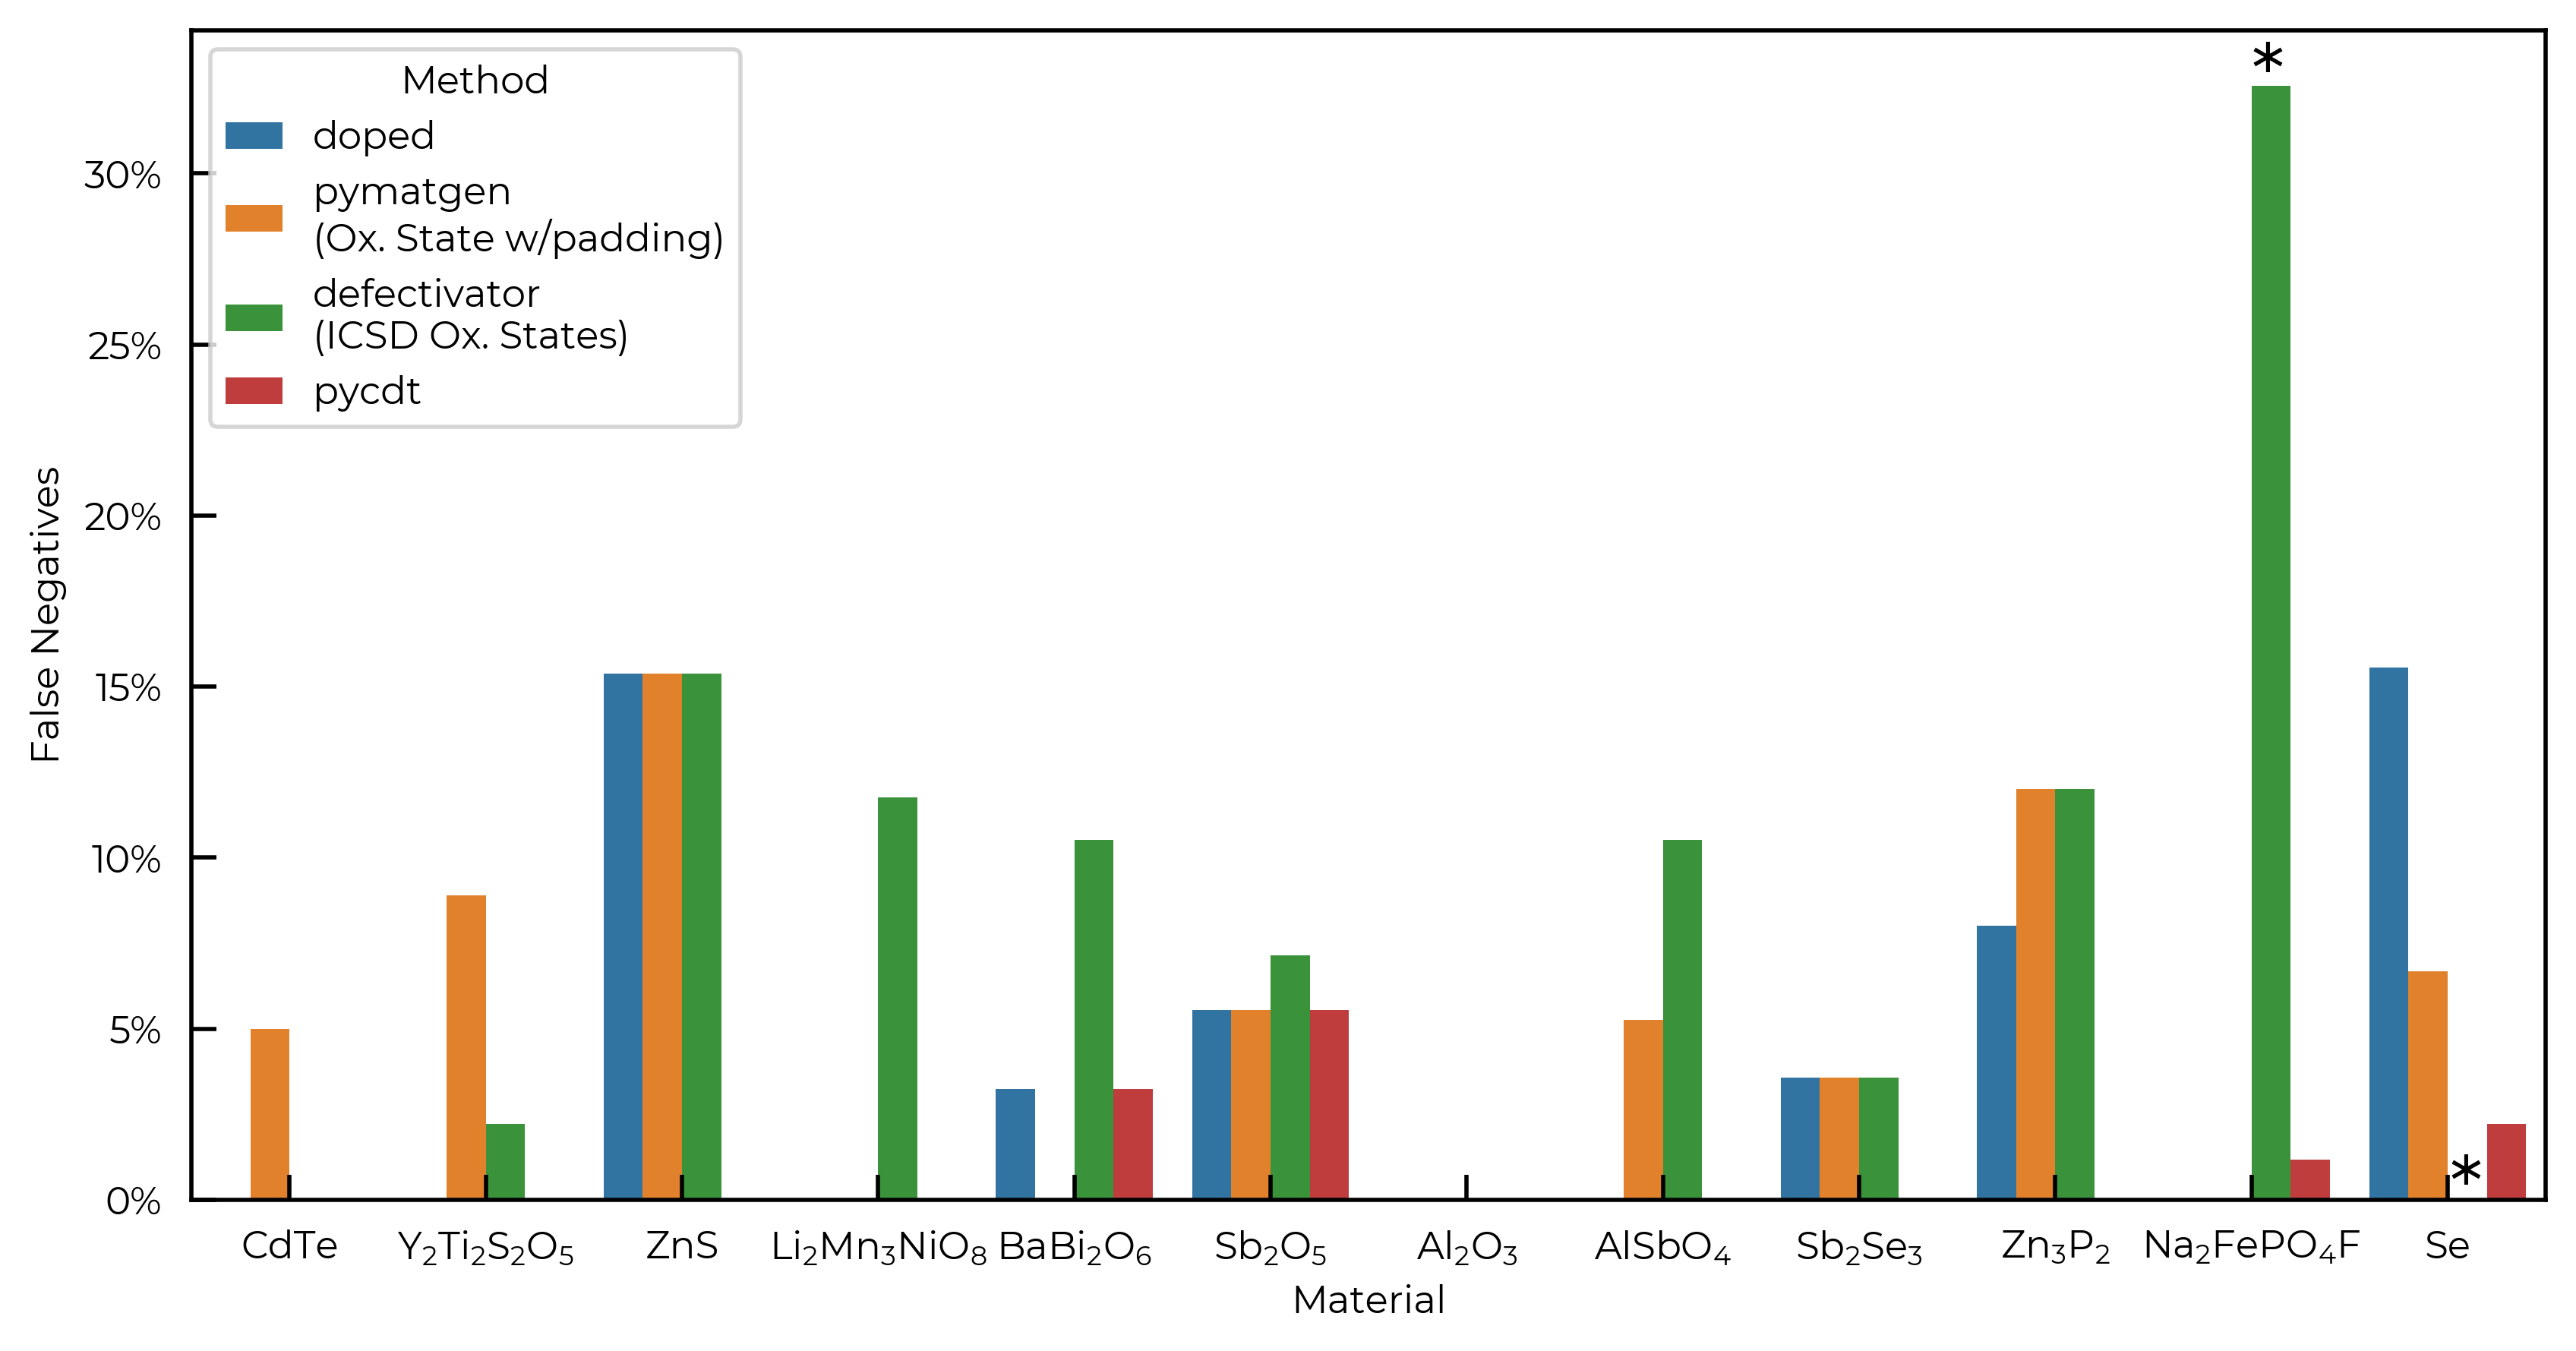

In [115]:
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings("ignore", "When grouping")
warnings.filterwarnings("ignore", "set_tick")

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.style.use("../../doped/utils/doped.mplstyle")
f,ax = plt.subplots(figsize=(10, 5))

materials = list(doped_results.keys())
materials = [[material,]*4 for material in materials]
materials = [item for sublist in materials for item in sublist]

df = pd.DataFrame({
    "Material": materials,
    "Method": ["doped", "pymatgen\n(Ox. State w/padding)", "defectivator\n(ICSD Ox. States)", "pycdt"]*len
    (doped_results),
    "False Negatives": [results_dict[material][1]/(
        results_dict[material][1] + results_dict[material][2]) for material in
                          doped_results.keys() for results_dict in
                          [doped_results, pmg_results, defectivator_results, pycdt_results]],
})

# Create a barplot with Material on the x-axis, Score on the y-axis, and different bars for each Method
sns.barplot(x='Material', y='False Negatives', hue='Method', data=df, ax=ax)
plt.legend(title='Method')

# add star to top of "Na2FePO4F" defectivator bar (f*d antisites)
ax.text(10, 0.32, "*", fontsize=20)
# add star to top of "Se" defectivator bar (missing extrinsic so unfair comparison)
ax.text(11.01, -0.005, "*", fontsize=20)

vals = ax.get_yticks()  # format y axis as percent
ax.set_yticklabels([f"{x:.0%}" for x in vals])
plt.savefig("false_negatives_comparison_plot.pdf", bbox_inches="tight", dpi=500)
plt.show()

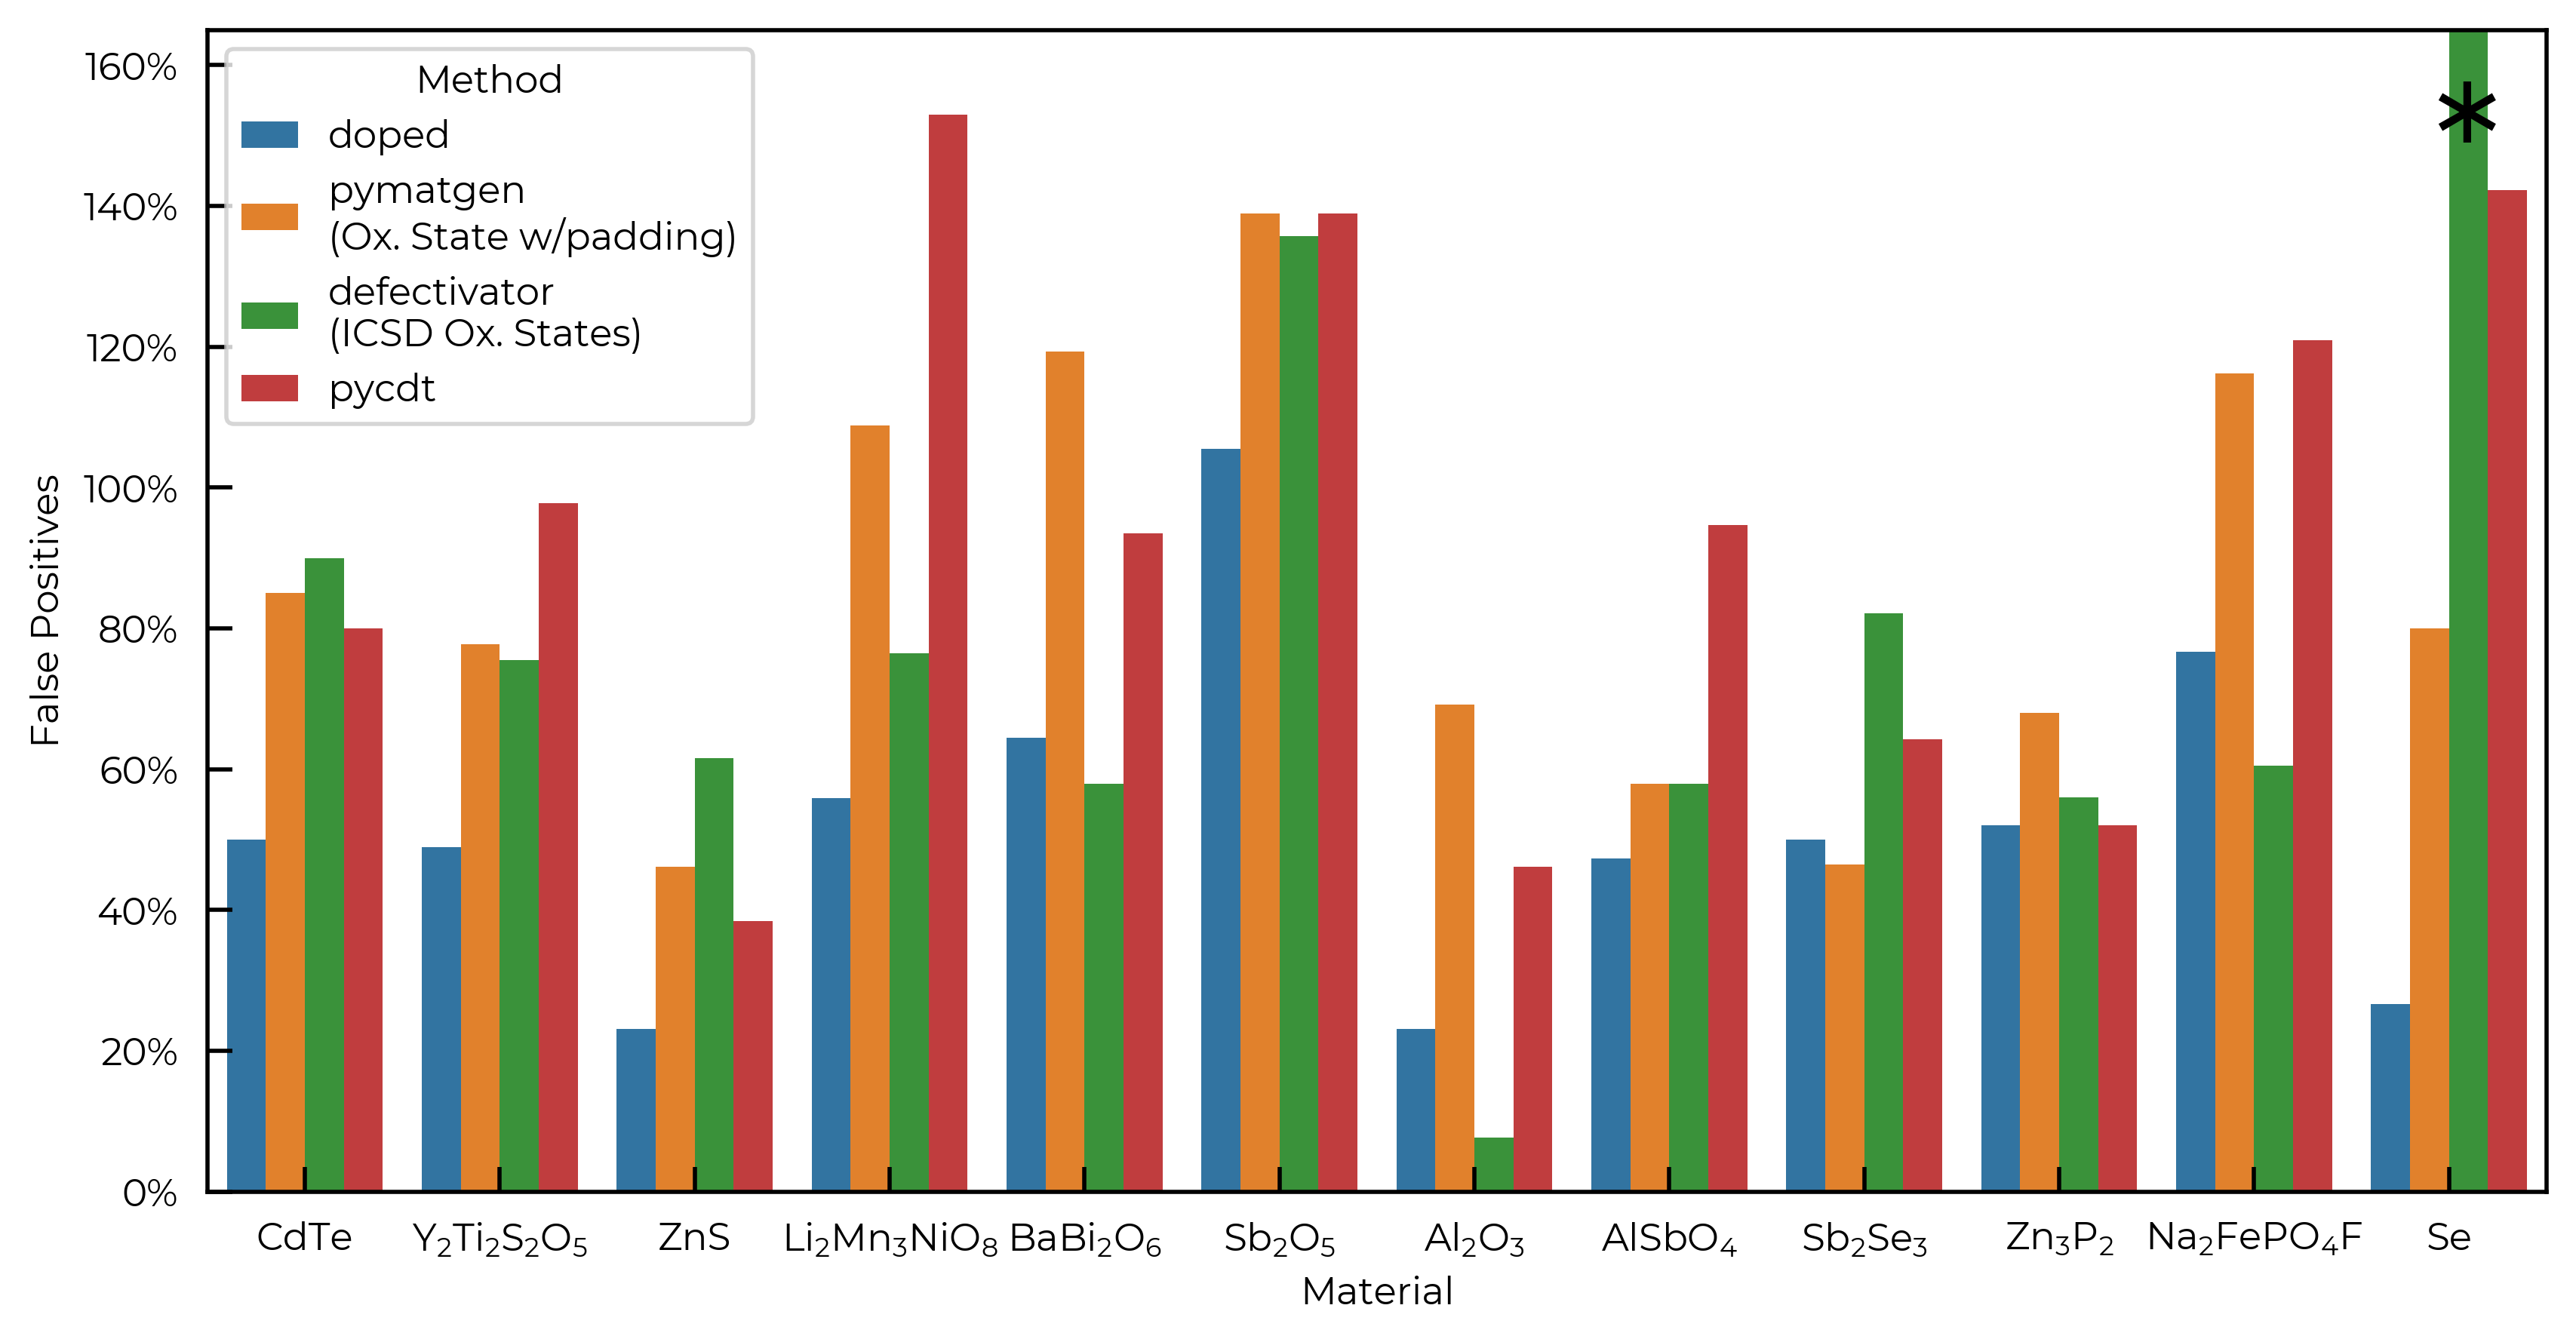

In [121]:
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings("ignore", "When grouping")
warnings.filterwarnings("ignore", "set_tick")

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.style.use("../../doped/utils/doped.mplstyle")
f,ax = plt.subplots(figsize=(10, 5))

materials = list(doped_results.keys())
materials = [[material,]*4 for material in materials]
materials = [item for sublist in materials for item in sublist]

df = pd.DataFrame({
    "Material": materials,
    "Method": ["doped", "pymatgen\n(Ox. State w/padding)", "defectivator\n(ICSD Ox. States)", "pycdt"]*len(doped_results),
    "False Positives": [results_dict[material][0]/(
        results_dict[material][1] + results_dict[material][2]) for material in
                          doped_results.keys() for results_dict in
                          [doped_results, pmg_results, defectivator_results, pycdt_results]],
})

bar_plot = sns.barplot(x='Material', y='False Positives', hue='Method', data=df, ax=ax)
plt.legend(title='Method')

# add star to top of "Se" defectivator bar (missing extrinsic so unfair comparison)
ax.text(10.925, 1.4, "*", fontsize=40)
ax.set_ylim(0, 1.65)
vals = ax.get_yticks()  # format y axis as percent
ax.set_yticklabels([f"{x:.0%}" for x in vals])
plt.savefig("false_positives_comparison_plot.pdf", bbox_inches="tight", dpi=500) 
plt.show()

Note that further work on charge-state guessing algorithms (potentially ML-based?) could try using the data included in the SI of the `PyCDT` paper on this:
https://www.sciencedirect.com/science/article/pii/S0010465518300079#appA: 
> The algorithm successfully includes all charge states from our benchmark list in Table A.2 by yielding, on an average, 6.4 states per defect. The average number of excess charge states produced per defect, in comparison to the literature, is 1.1 and 1.9 at the lower (more negative) and at the upper (more positive) charge bound, respectively. This is desirable because including more charge states on either side ensures no extra states become stabilized when varying the Fermi level within the band gap. Hence, the effective relative excess in charge states is and, thus, acceptable."

Also note that the `PyCDT` algorithm was split between semiconductors and insulators, and there is possibly a slight bias of the data being from defect results without structure-searching which can stabilise more unusual charge states (e.g. ShakeNBreak finds other stable charge states in Sb2Se3 (https://arxiv.org/abs/2402.04434 & https://doi.org/10.1103/PhysRevB.108.134102) and ZnS (unpublished) compared to previous work/that dataset), and Hoang et al. (https://www.sciencedirect.com/science/article/am/pii/S0927025619301442) found other stable charge states in ZnS (also found in unpublished work with SnB from Savya Aggarwal) which aren't in that dataset.

And of course there is a bias to low numbers of false negatives for the `PyCDT` results here, as many of these investigations used the guessed charge state ranges from `PyCDT` (so there may be unknown false negatives). 

## Average Plots

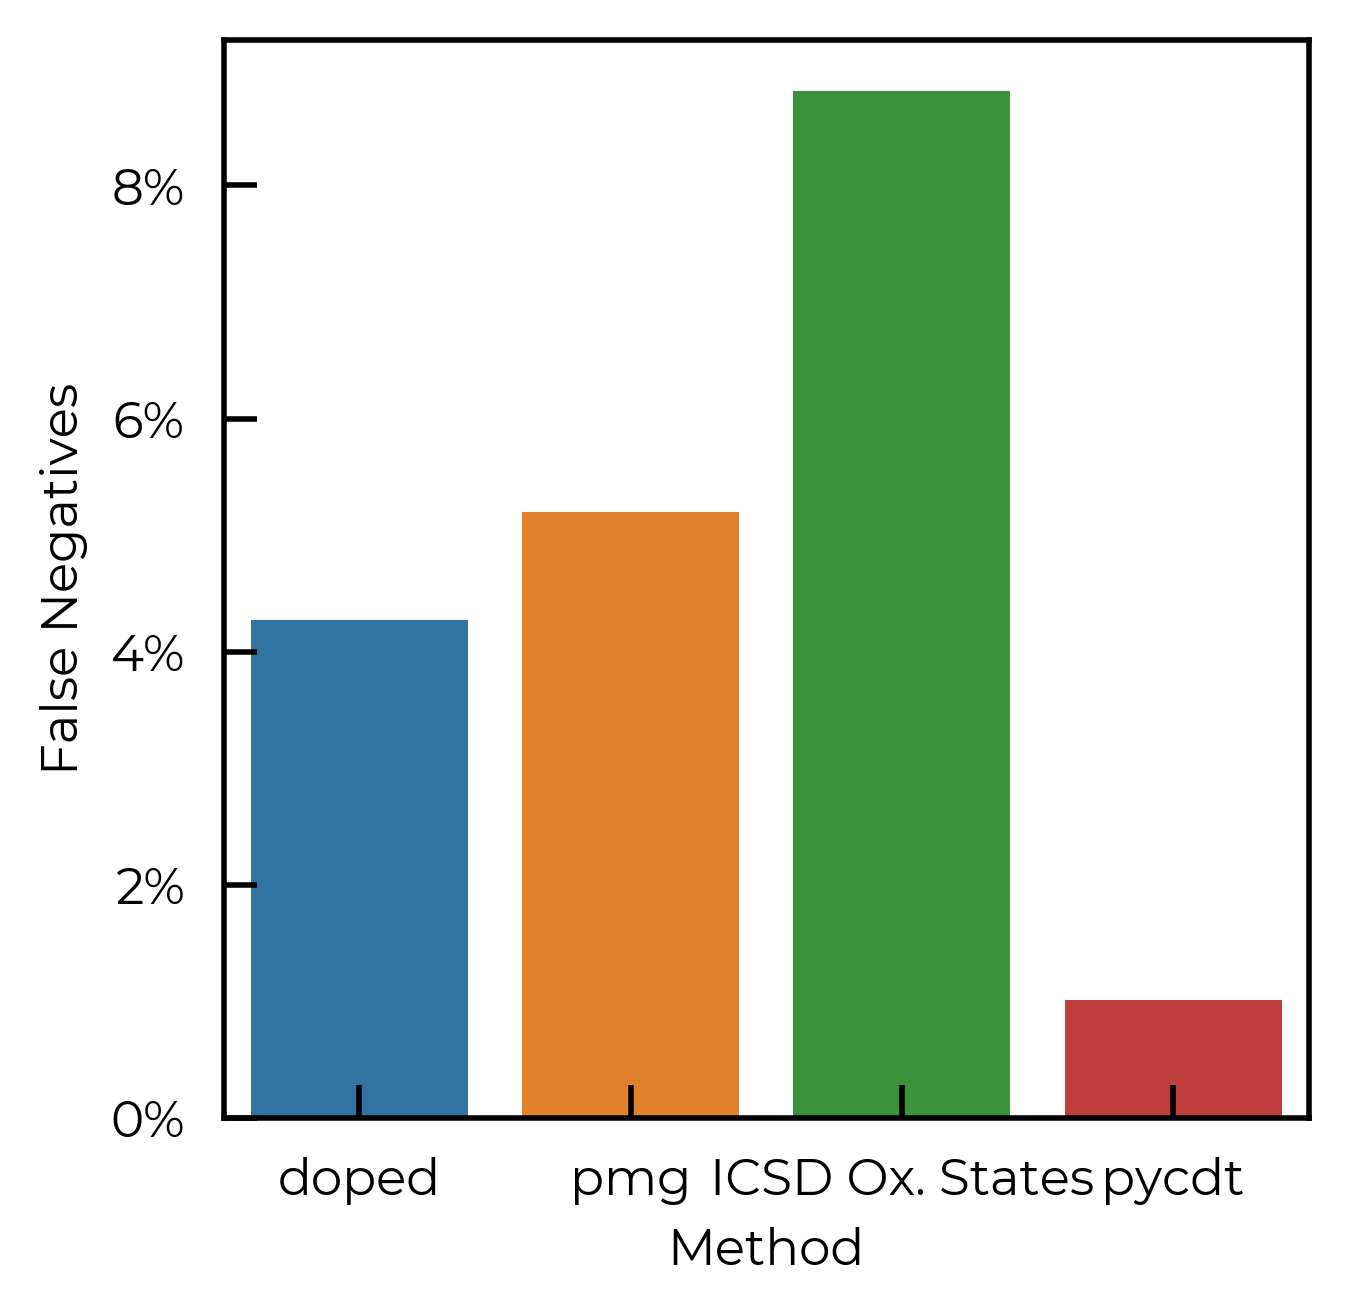

In [122]:
import seaborn as sns
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings("ignore", "When grouping")
warnings.filterwarnings("ignore", "set_tick")

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.style.use("../../doped/utils/doped.mplstyle")
f,ax = plt.subplots()

average_false_negatives = [np.mean(np.array([val[1] for val in results_dict.values()])/(
        np.array([val[1] + val[2] for val in results_dict.values()]))) for results_dict in
                          [doped_results, pmg_results, defectivator_results, pycdt_results]]
df = pd.DataFrame({
    "Method": ["doped", "pmg", "ICSD Ox. States", "pycdt"],
    "False Negatives": average_false_negatives
})
sns.barplot(data=df, x="Method", y="False Negatives", ax=ax, hue="Method")

vals = ax.get_yticks()  # format y axis as percent
ax.set_yticklabels([f"{x:.0%}" for x in vals])
plt.show()

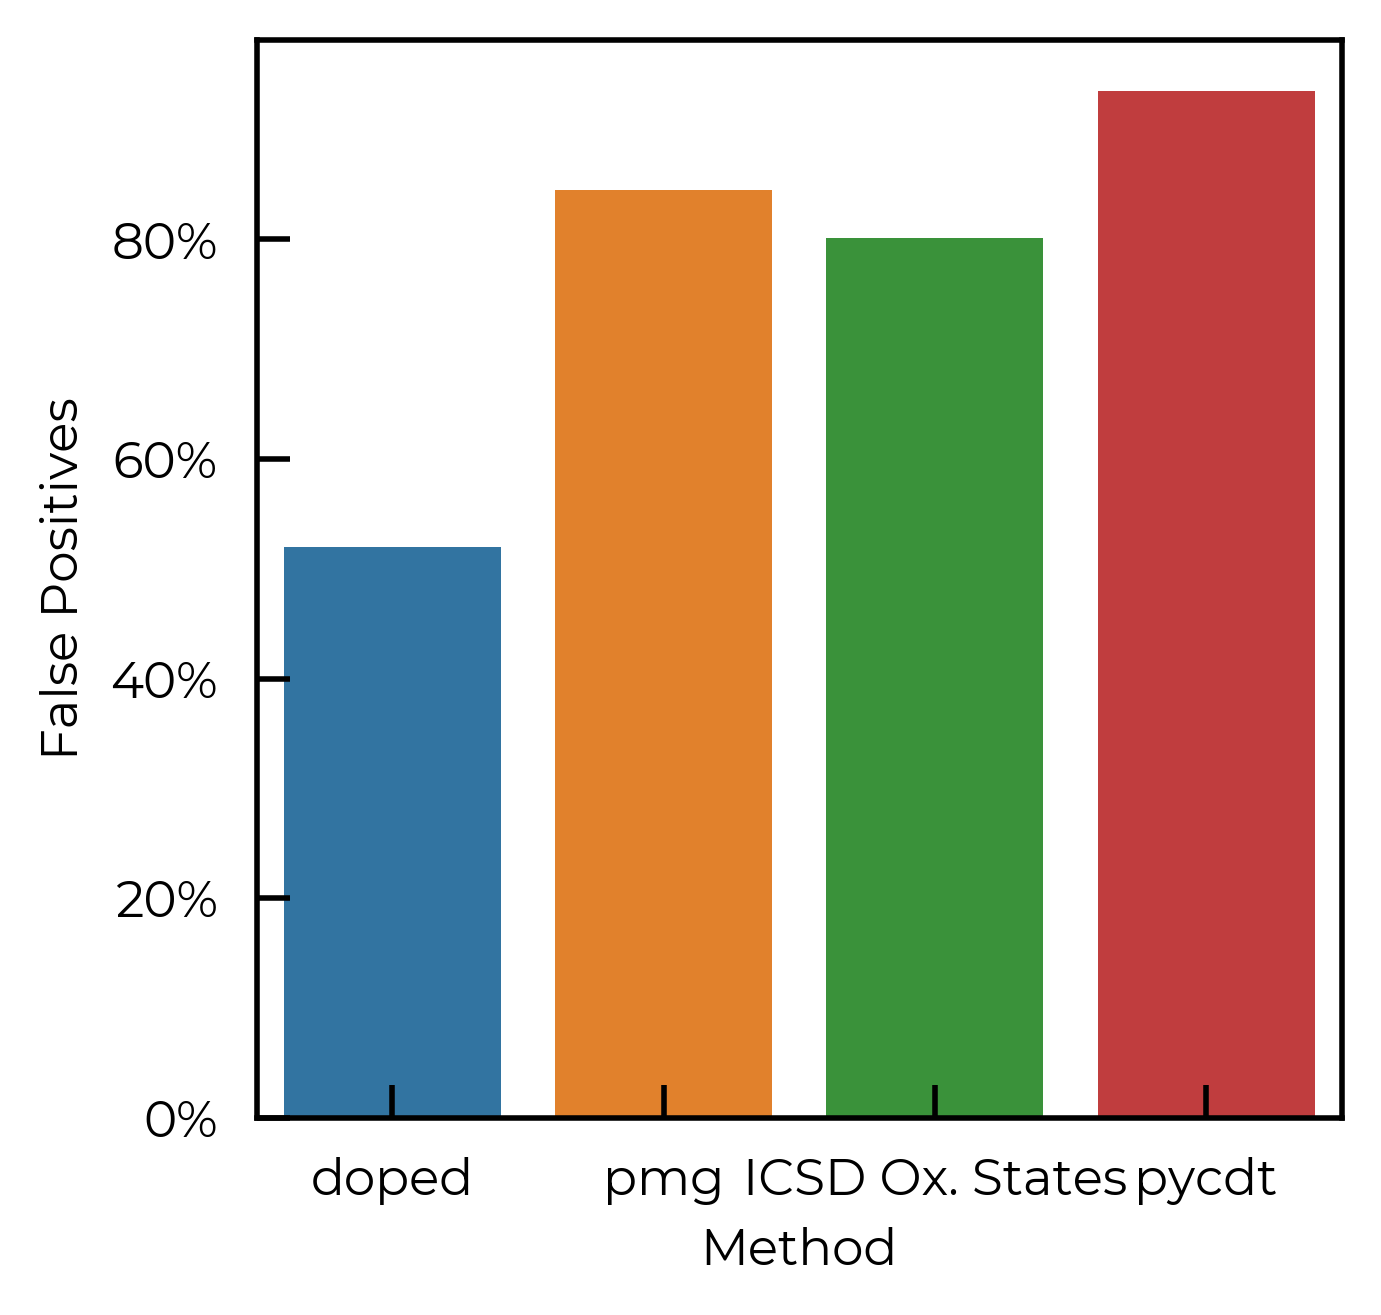

In [123]:
import seaborn as sns
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings("ignore", "When grouping")
warnings.filterwarnings("ignore", "set_tick")

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.style.use("../../doped/utils/doped.mplstyle")
f,ax = plt.subplots()

average_false_positives = [np.mean(np.array([val[0] for val in results_dict.values()])/(
        np.array([val[1] + val[2] for val in results_dict.values()]))) for results_dict in
                          [doped_results, pmg_results, defectivator_results, pycdt_results]]
df = pd.DataFrame({
    "Method": ["doped", "pmg", "ICSD Ox. States", "pycdt"],
    "False Positives": average_false_positives
})
sns.barplot(data=df, x="Method", y="False Positives", hue="Method", ax=ax)

vals = ax.get_yticks()  # format y axis as percent
ax.set_yticklabels([f"{x:.0%}" for x in vals])
plt.show()

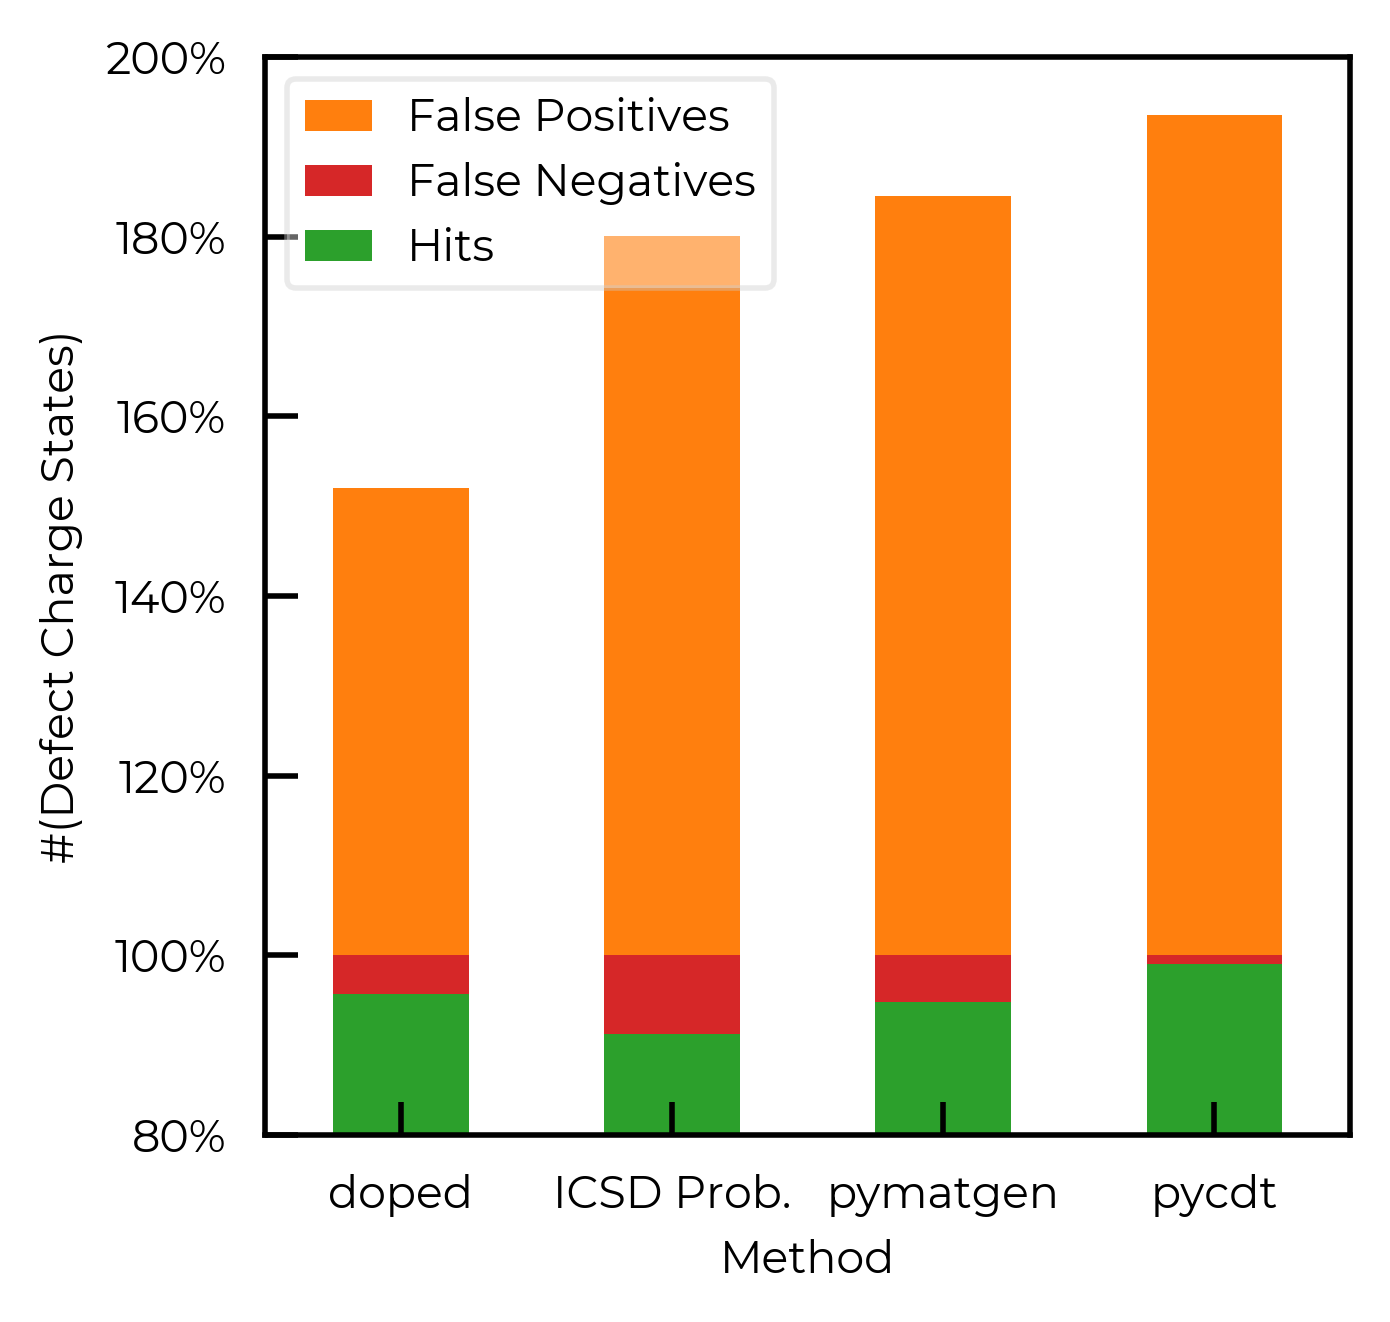

In [138]:
# plot a stacked bar chart of hits in green, false negatives in red, and false positives in light red/orange:
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings("ignore", "When grouping")
warnings.filterwarnings("ignore", "set_tick")

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.style.use("../../doped/utils/doped.mplstyle")
plt.rcParams["font.size"] = 8
f,ax = plt.subplots()

average_false_positives = [np.mean(np.array([val[0] for val in results_dict.values()])/(
        np.array([val[1] + val[2] for val in results_dict.values()]))) for results_dict in
                          [doped_results, defectivator_results, pmg_results, pycdt_results]]
average_false_negatives = [np.mean(np.array([val[1] for val in results_dict.values()])/(
        np.array([val[1] + val[2] for val in results_dict.values()]))) for results_dict in
                          [doped_results, defectivator_results, pmg_results, pycdt_results]]
average_hits = [np.mean(np.array([val[2] for val in results_dict.values()])/(
        np.array([val[1] + val[2] for val in results_dict.values()]))) for results_dict in
                          [doped_results, defectivator_results, pmg_results, pycdt_results]]

df = pd.DataFrame({
    "Method": ["doped", "ICSD Prob.", "pymatgen", "pycdt"],
    "Hits": average_hits,
    "False Negatives": average_false_negatives,
    "False Positives": average_false_positives,
})
df = df.set_index("Method")
df.plot.bar(stacked=True, ax=ax, rot=0, color=["#2ca02c", "#d62728", "#ff7f0e"])
ax.set_ylabel("#(Defect Charge States)")
ax.legend(reverse=True, framealpha=0.4)

# format y axis as percent:
ax.set_ylim(0.8, 2)
vals = ax.get_yticks()
ax.set_yticks(vals)
ax.set_yticklabels([f"{x:.0%}" for x in vals])

plt.savefig("defect_charge_states_comparison.pdf", bbox_inches="tight", dpi=500)
plt.show()

## Materials without data:
(To sanity check outputs)

#### Cu:

In [139]:
from pymatgen.core import Structure
from doped.generation import DefectsGenerator

primitive_cu = Structure.from_file("../../tests/data/Cu_prim_POSCAR")
defect_gen = DefectsGenerator(primitive_cu)

Generating DefectEntry objects: 100.0%|██████████| [00:12,   7.88it/s]                            

Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Cu         [+1,0,-1]          [0.000,0.000,0.000]  4a

Interstitials    Guessed Charges    Conv. Cell Coords    Wyckoff
---------------  -----------------  -------------------  ---------
Cu_i_Oh          [+2,+1,0]          [0.500,0.500,0.500]  4b
Cu_i_Td          [+2,+1,0]          [0.250,0.250,0.250]  8c

The number in the Wyckoff label is the site multiplicity/degeneracy of that defect in the conventional ('conv.') unit cell, which comprises 4 formula unit(s) of Cu.
Note that Wyckoff letters can depend on the ordering of elements in the conventional standard structure, for which doped uses the spglib convention.


In [140]:
# pymatgen analysis defects charge states
for defect_entry in defect_gen.defect_entries.values():
    if defect_entry.charge_state == 0:
        print(f"{defect_entry.name}: {defect_entry.defect.get_charge_states()}")

v_Cu_0: [-1, 0, 1]
Cu_i_Oh_0: [-1, 0, 1, 2, 3]
Cu_i_Td_0: [-1, 0, 1, 2, 3]


#### Intermetallic CuAg:

In [141]:
from doped.generation import DefectsGenerator
from ase.build import bulk, make_supercell
from pymatgen.io.ase import AseAtomsAdaptor

# test initialising with an intermetallic (where pymatgen oxidation state guessing fails)
atoms = bulk("Cu")
atoms = make_supercell(atoms, [[2, 0, 0], [0, 2, 0], [0, 0, 2]])
atoms.set_chemical_symbols(["Cu", "Ag"] * 4)

aaa = AseAtomsAdaptor()
cuag_structure = aaa.get_structure(atoms)
defect_gen = DefectsGenerator(cuag_structure)

Generating DefectEntry objects: 100.0%|██████████| [00:28,   3.46it/s]                             


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Cu         [+1,0,-1]          [0.000,0.000,0.000]  3a
v_Ag         [+1,0,-1]          [0.000,0.000,0.500]  3b

Substitutions    Guessed Charges    Conv. Cell Coords    Wyckoff
---------------  -----------------  -------------------  ---------
Cu_Ag            [+2,+1,0,-1]       [0.000,0.000,0.500]  3b
Ag_Cu            [+1,0,-1]          [0.000,0.000,0.000]  3a

Interstitials                 Guessed Charges    Conv. Cell Coords    Wyckoff
----------------------------  -----------------  -------------------  ---------
Cu_i_C3v_Cu1.56Ag1.56Cu2.99a  [+2,+1,0]          [0.000,0.000,0.125]  6c
Cu_i_C3v_Cu1.56Ag1.56Cu2.99b  [+2,+1,0]          [0.000,0.000,0.375]  6c
Cu_i_C3v_Cu1.80               [+2,+1,0]          [0.000,0.000,0.250]  6c
Ag_i_C3v_Cu1.56Ag1.56Cu2.99a  [+1,0]             [0.000,0.000,0.125]  6c
Ag_i_C3v_Cu1.56Ag1.56Cu2.99b  [+1,0]             [0.000,0.00

In [142]:
# pymatgen analysis defects charge states
for defect_entry in defect_gen.defect_entries.values():
    if defect_entry.charge_state == 0:
        print(f"{defect_entry.name}: {defect_entry.defect.get_charge_states()}")

v_Cu_0: [-1, 0, 1]
v_Ag_0: [-1, 0, 1]
Cu_Ag_0: [-1, 0, 1]
Ag_Cu_0: [-1, 0, 1]
Cu_i_C3v_Cu1.56Ag1.56Cu2.99a_0: [-1, 0, 1, 2, 3]
Cu_i_C3v_Cu1.56Ag1.56Cu2.99b_0: [-1, 0, 1, 2, 3]
Cu_i_C3v_Cu1.80_0: [-1, 0, 1, 2, 3]
Ag_i_C3v_Cu1.56Ag1.56Cu2.99a_0: [-1, 0, 1, 2, 3]
Ag_i_C3v_Cu1.56Ag1.56Cu2.99b_0: [-1, 0, 1, 2, 3]
Ag_i_C3v_Cu1.80_0: [-1, 0, 1, 2, 3]


#### Si:

In [143]:
from pymatgen.core import Structure
from doped.generation import DefectsGenerator

struc = Structure.from_file("../../tests/data/Si_MP_conv_POSCAR")
defect_gen = DefectsGenerator(struc)

Generating DefectEntry objects: 100.0%|██████████| [00:24,   4.13it/s]                             

Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Si         [+1,0,-1]          [0.000,0.000,0.000]  8a

Interstitials    Guessed Charges    Conv. Cell Coords    Wyckoff
---------------  -----------------  -------------------  ---------
Si_i_D3d         [+4,+3,+2,+1,0]    [0.625,0.625,0.625]  16d
Si_i_Td          [+4,+3,+2,+1,0]    [0.500,0.500,0.500]  8b

The number in the Wyckoff label is the site multiplicity/degeneracy of that defect in the conventional ('conv.') unit cell, which comprises 8 formula unit(s) of Si.
Note that Wyckoff letters can depend on the ordering of elements in the conventional standard structure, for which doped uses the spglib convention.


In [144]:
# pymatgen analysis defects charge states
for defect_entry in defect_gen.defect_entries.values():
    if defect_entry.charge_state == 0:
        print(f"{defect_entry.name}: {defect_entry.defect.get_charge_states()}")
# all negative Si_i? – because pymatgen guesses the oxi state as -4 in this defect structure

v_Si_0: [-1, 0, 1]
Si_i_D3d_0: [-5, -4, -3, -2, -1, 0, 1]
Si_i_Td_0: [-5, -4, -3, -2, -1, 0, 1]


# Chemical Potential Plotting (Subfigure **e**)

In [1]:
from doped.chemical_potentials import CompetingPhasesAnalyzer
cpa = CompetingPhasesAnalyzer("Cs2SnBr6")
cpa.from_csv(csv_path="data/Cs2SnBr6_competing_phase_energies.csv")

In [3]:
# Plot!
from pymatgen.analysis.phase_diagram import PDPlotter
pd = cpa.intrinsic_phase_diagram
plotter = PDPlotter(pd, show_unstable=False)  # you can also try show_unstable=True
plotter.show()
# plotter.write_image("{}.png".format('-'.join(system)), "png")  # save figure


print('Stable Entries (formula)\n--------')
for e in pd.stable_entries:
    print(e.composition.reduced_formula)

print('\nUnstable Entries (formula, e_above_hull (eV/atom), decomposes_to)\n--------')
for e in pd.unstable_entries:
    decomp, e_above_hull = pd.get_decomp_and_e_above_hull(e)
    pretty_decomp = ["{}:{}".format(k.composition.reduced_formula, round(v, 2)) for k, v in decomp.items()]
    print(e.composition.reduced_formula, "%.3f" % e_above_hull, pretty_decomp)

Stable Entries (formula)
--------
CsSn2Br5
Cs2SnBr6
SnBr4
Sn
CsBr3
SnBr2
CsBr
Br
Cs

Unstable Entries (formula, e_above_hull (eV/atom), decomposes_to)
--------
CsSnBr3 0.000 ['CsSn2Br5:0.8', 'CsBr:0.2']


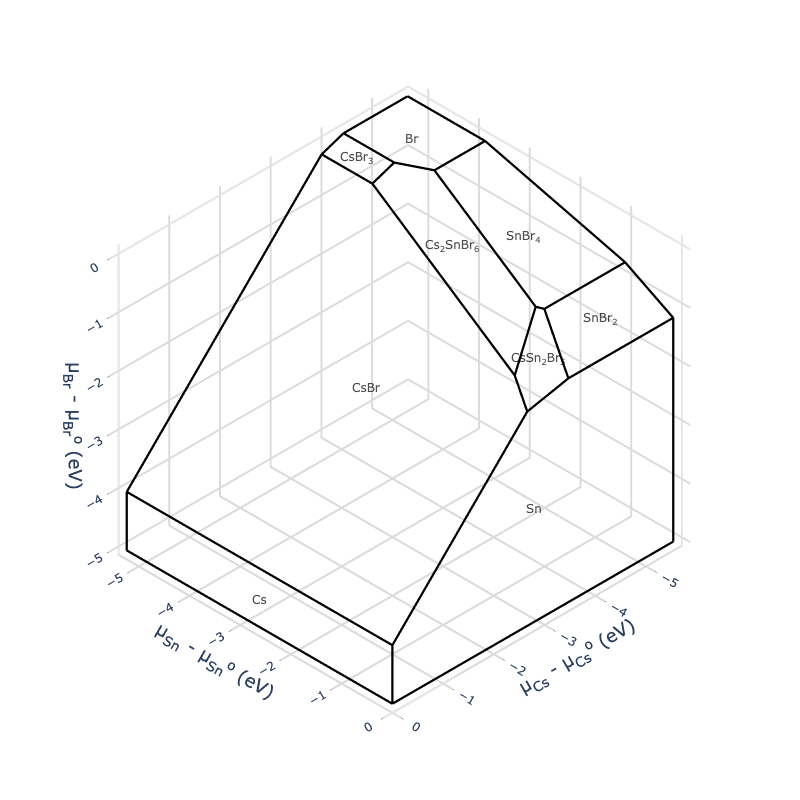

In [4]:
from pymatgen.analysis.chempot_diagram import ChemicalPotentialDiagram
cpd = ChemicalPotentialDiagram(pd.entries)
plot = cpd.get_plot()
plot.show("png", dpi=400)

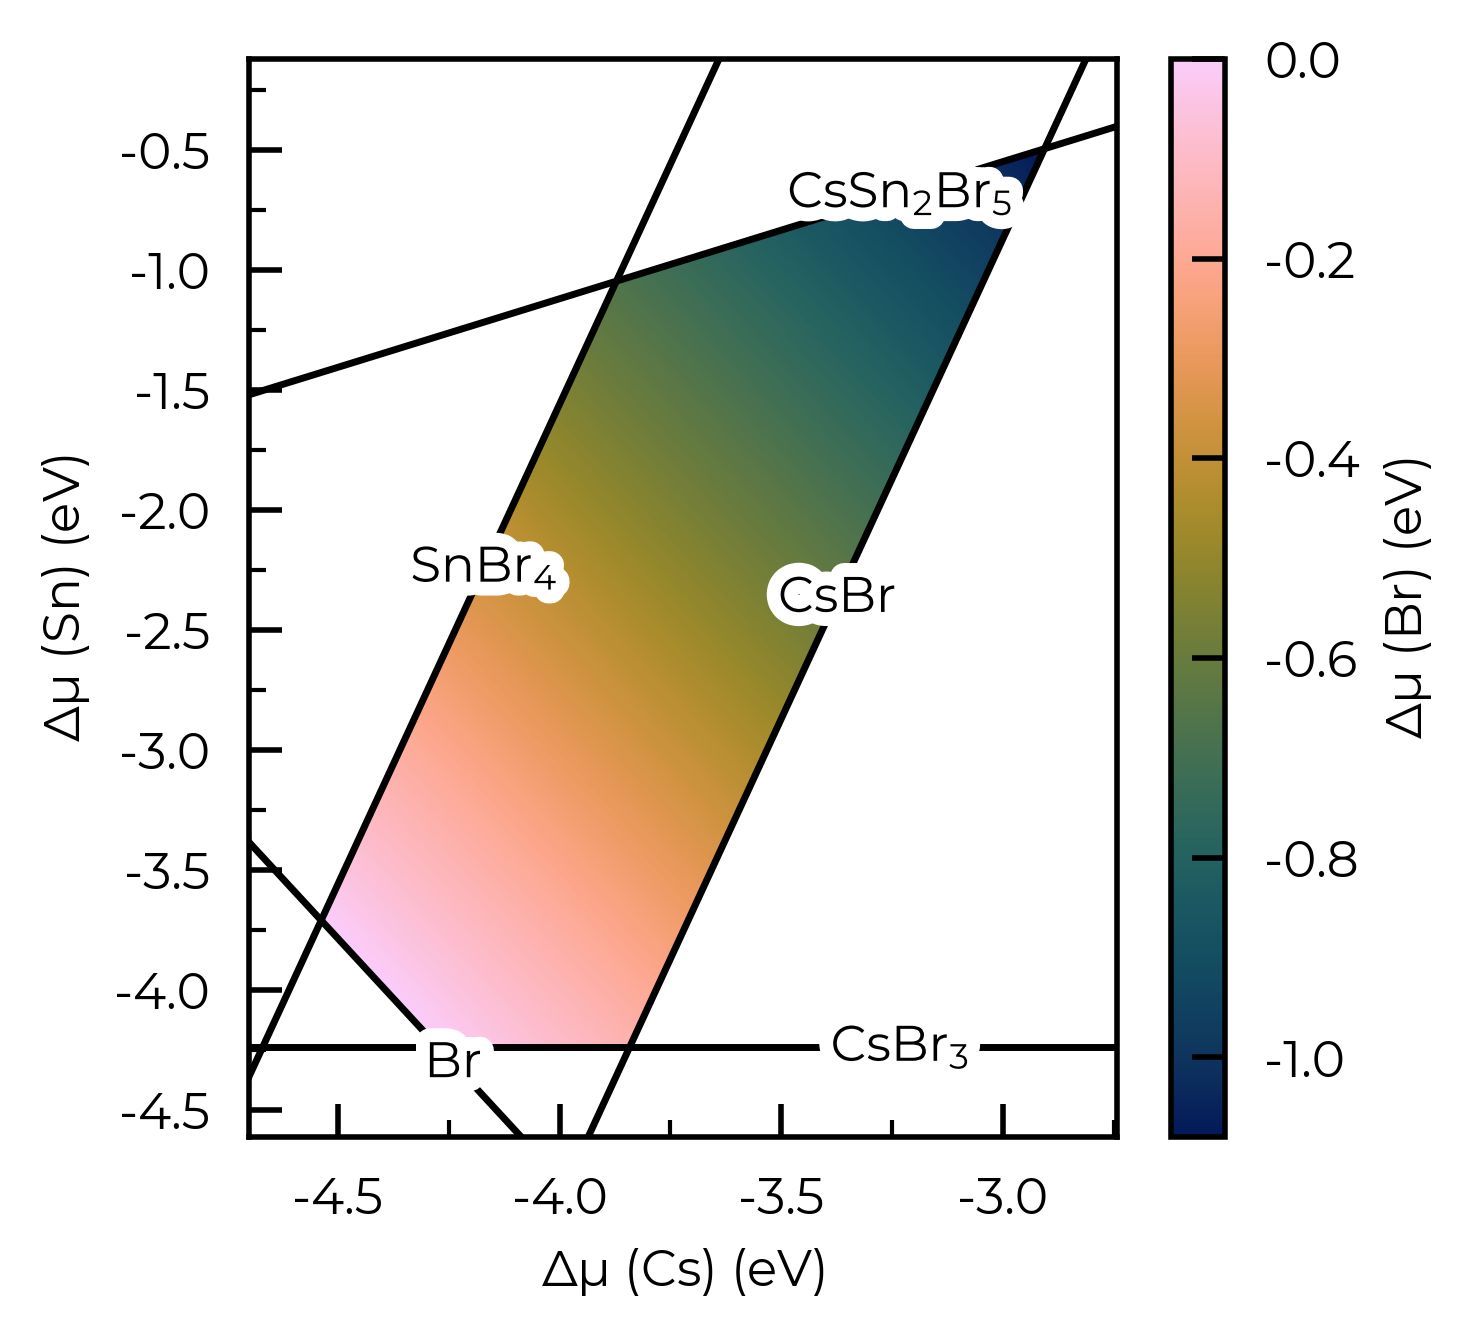

In [7]:
plot = cpa.plot_chempot_heatmap()

### Old Code for Colour Line Plotting:

In [0]:
from pymatgen.analysis.chempot_diagram import ChemicalPotentialDiagram
cpd = ChemicalPotentialDiagram(pd.entries)

In [108]:
host_domains = cpd.domains["Cs2SnBr6"]

In [13]:
bulk_ce = [entry for entry in pd.entries if entry.composition.reduced_formula == "Cs2SnBr6"][0]

In [67]:
import numpy as np
from scipy.spatial import ConvexHull, Delaunay
from scipy.interpolate import griddata

hull = ConvexHull(host_domains[:, :2])  # convex hull of points to get bounding polygon

# create a dense grid that covers the entire range of the vertices:
x_min, y_min = host_domains[:, :2].min(axis=0)
x_max, y_max = host_domains[:, :2].max(axis=0)
grid_x, grid_y = np.mgrid[x_min:x_max:1000j, y_min:y_max:1000j]
grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T

# Delaunay triangulation to get points inside the hull:
delaunay = Delaunay(hull.points[hull.vertices])
inside_hull = delaunay.find_simplex(grid_points) >= 0
points_inside = grid_points[inside_hull]
# interpolate the values to get the dependent chempot here:
values_inside = griddata(host_domains[:, :2], host_domains[:, 2], points_inside, method='linear')

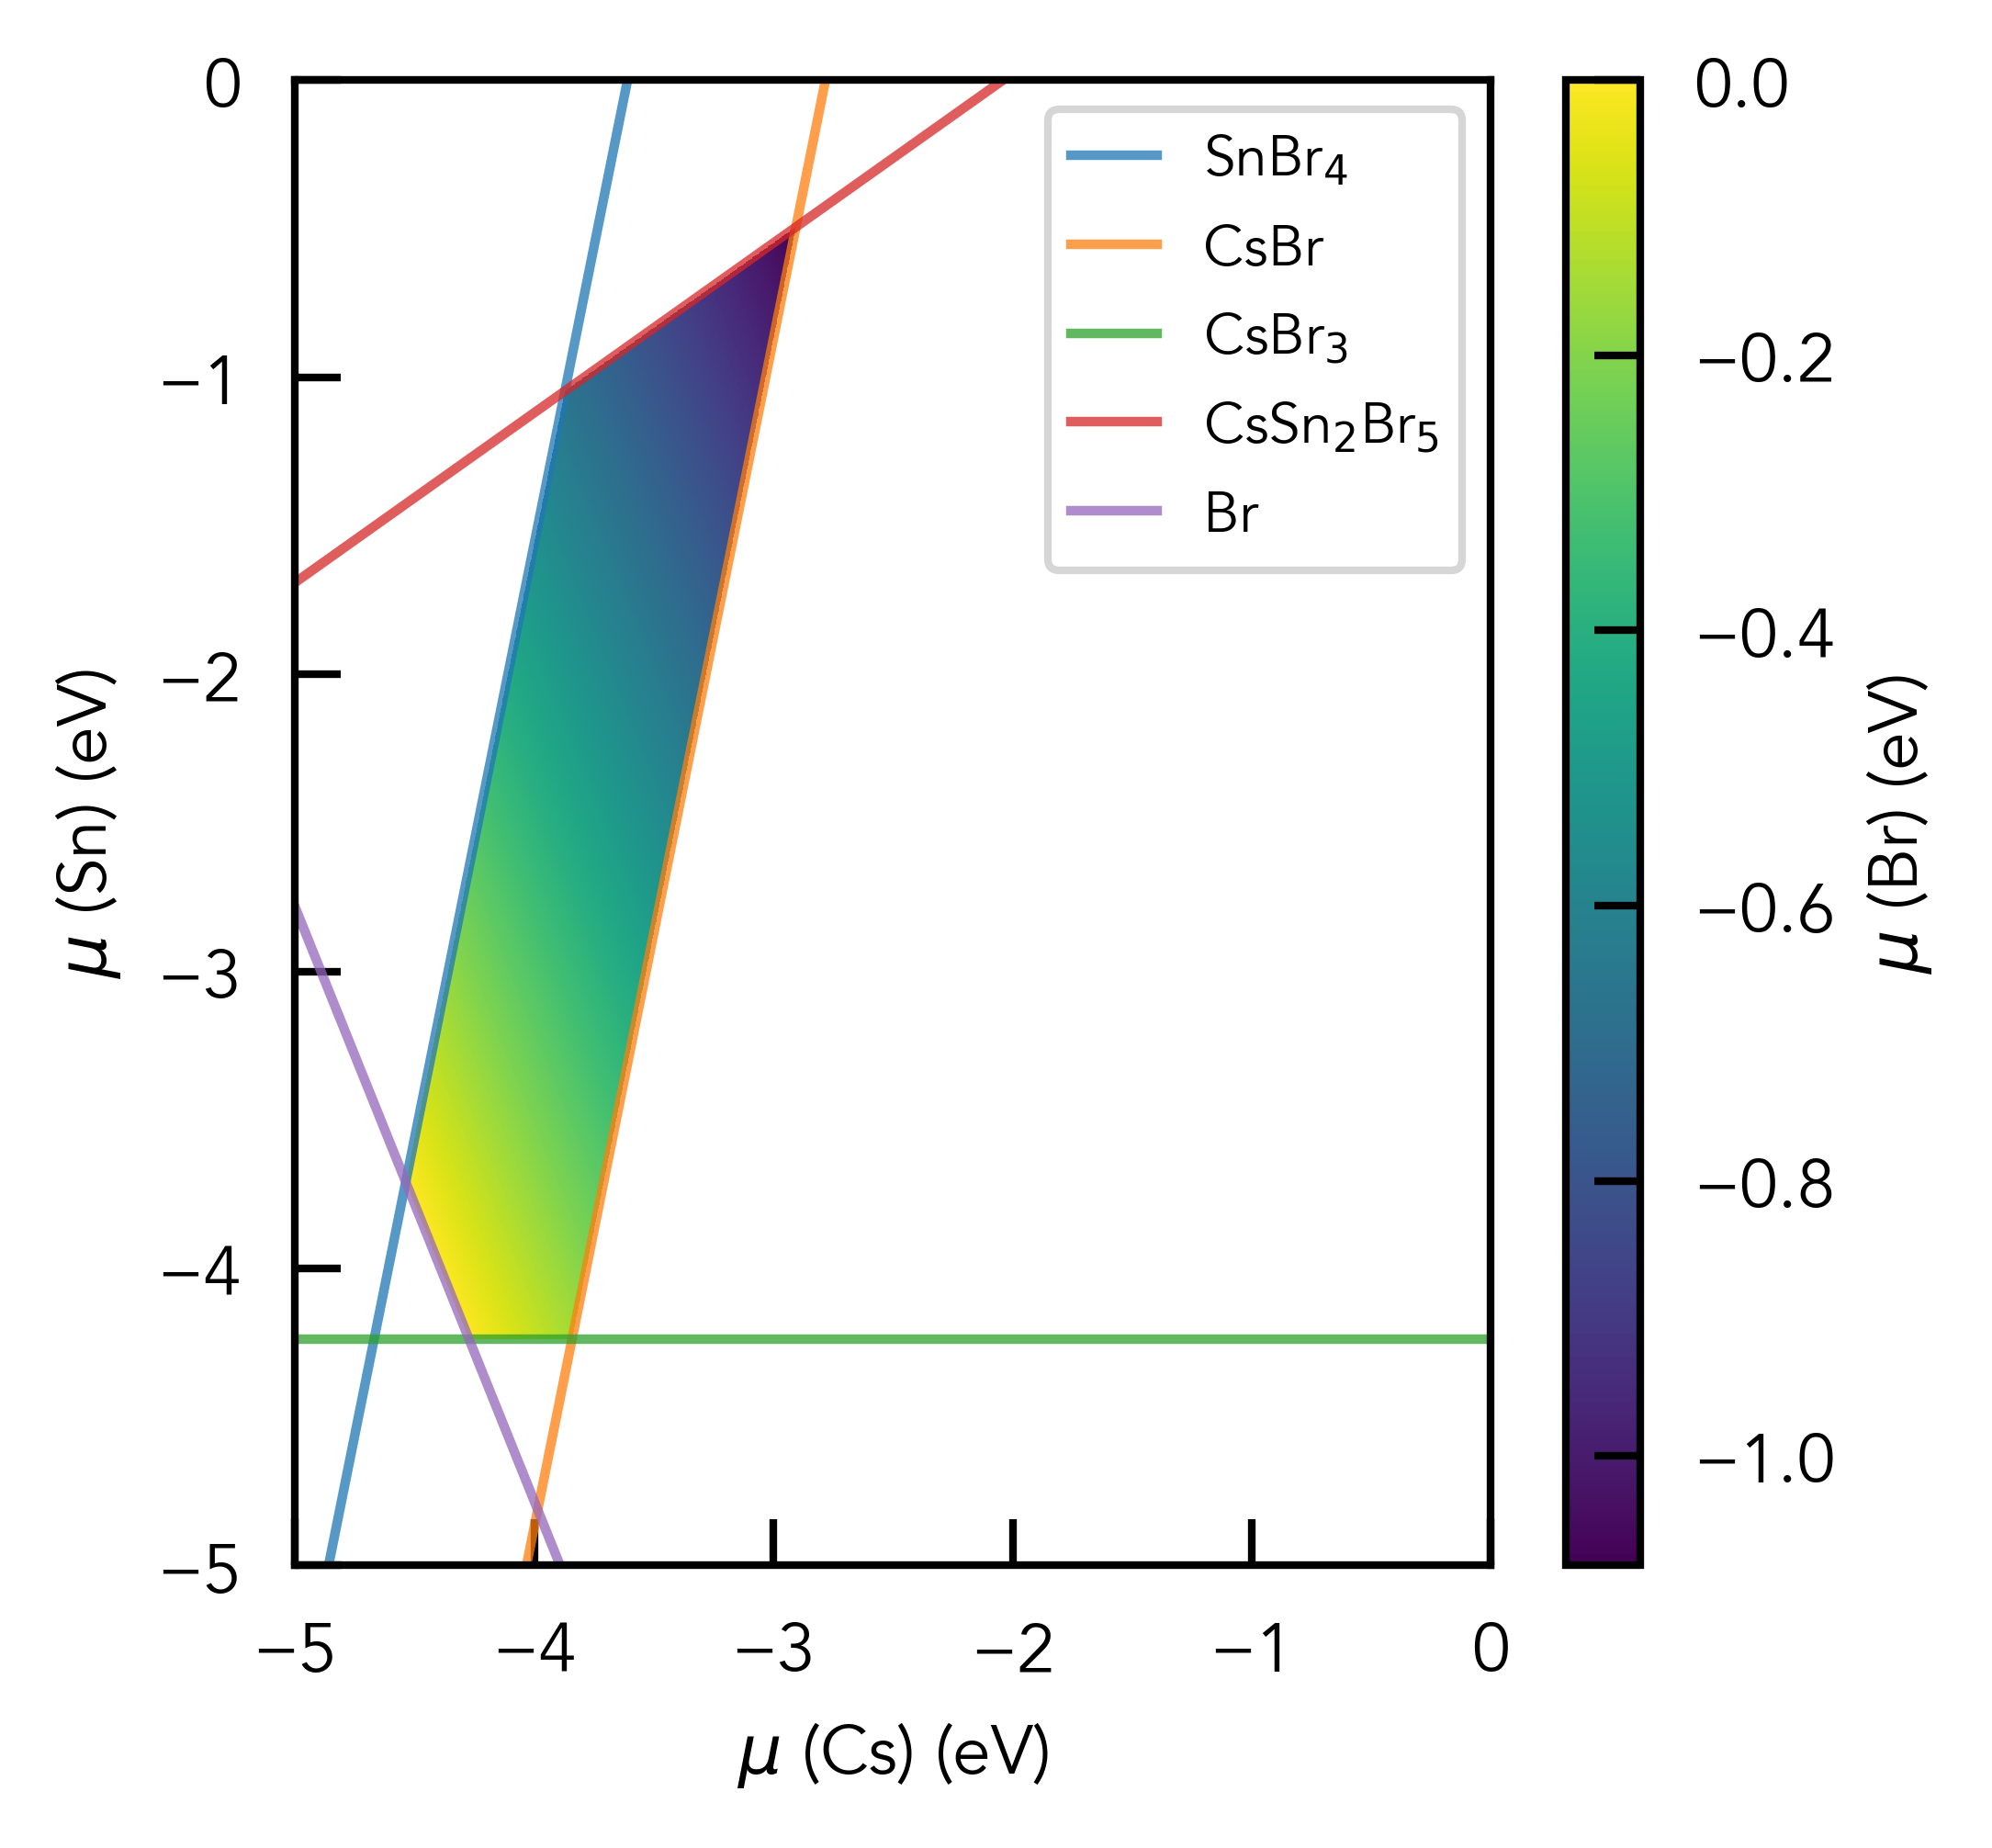

In [117]:
from scipy.interpolate import interp1d
from pymatgen.util.string import latexify

plt.rcdefaults()
plt.style.use("../../doped/utils/doped.mplstyle")
fig,ax = plt.subplots()
# mesh = host_domains
mesh_x = sorted(set(points_inside[:, 0]))
mesh_y = sorted(set(points_inside[:, 1]))
mesh_z = np.zeros((len(mesh_y), len(mesh_x))) * np.NaN
for (x, y), z in zip(points_inside, values_inside):
    ix = mesh_x.index(x)
    iy = mesh_y.index(y)
    mesh_z[iy, ix] = z
# mesh_z = np.ma.masked_invalid(mesh_z)

dep_mu = ax.pcolormesh(mesh_x, mesh_y, mesh_z, rasterized=True, cmap="viridis", shading="auto",
                       vmax=0)
cbar = fig.colorbar(dep_mu)
ax.set_xlim(-5, 0)
ax.set_ylim(-5, 0)
cbar.set_label(rf'$\mu$ (Br) (eV)')
ax.set_ylabel(r'$\mu$ (Sn) (eV)')
ax.set_xlabel(r'$\mu$ (Cs) (eV)')

# plot formation energy lines:
for formula, pts in cpd.domains.items():
    if formula == "Cs2SnBr6":
        continue
    x = np.linspace(-50, 0, 100)
    # get domain points which match those in host_domains:
    domain_pts = [chempot_coords for chempot_coords in pts
                  if any(np.allclose(chempot_coords, coords) for coords in host_domains)]
    if len(domain_pts) < 2:
        continue

    if len(domain_pts) > 2:
        print(formula, len(domain_pts), domain_pts)

    f = interp1d(np.array(domain_pts)[:, 0], np.array(domain_pts)[:, 1],
                 kind="linear", assume_sorted=False, fill_value="extrapolate")
    ax.plot(x, f(x), label=latexify(formula), lw=1.25, alpha=0.75)

ax.legend()
fig.savefig("Cs2SnBr6_chempot.png", bbox_inches="tight", dpi=600)

# Other Sub-Figures
The functions used to generate all other sub figures in the `doped` JOSS figure are shown in the parsing, thermodynamics & advanced analysis tutorials on the docs, with the necessary data provided in the `examples` folder of the GitHub repository. 